# Functions

In [1]:
import numpy as np
import pandas as pd

from EspPipeML import esp_utilities
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from torch_frame.nn import ResNet
from torch_frame.data import StatType
from torch_frame import TensorFrame, stype
from torch.utils.data import Dataset, DataLoader
import my_operations as ga

from sklearn.metrics import roc_auc_score
from my_operations import XDecode
import seaborn as sns

import torch
import torch.nn as nn
from icecream import ic

# from scipy.spatial import distance
from scipy.stats import entropy

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.tabular.all import *

#
def plot_roc_curve(y_true, y_scores, title='Receiver Operating Characteristic'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Create a figure object
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc_score)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    
    # Return the figure object along with the ROC AUC
    return fig, auc_score



def evaluate(y_true, y_pred_prob, y_multi_class, threshold=0.5):
    y_pred = np.where(y_pred_prob > threshold, 1, 0)

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    attackwise_accuracy = esp_utilities.compute_attackwise_accuracy(y_true, y_pred, y_multi_class)
    f1 = f1_score(y_true, y_pred)
    auc, roc = plot_roc_curve(y_true, y_pred_prob)

    results = {
        'f1': f1,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'attackwise_accuracy': attackwise_accuracy,
        'roc': roc,
        'auc': auc
    }
    return results

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)  # First hidden layer with 100 neurons
        self.fc2 = nn.Linear(100, 100)       # Second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 100)       # Third hidden layer with 100 neurons
        self.fc4 = nn.Linear(100, 1)         # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))         # Activation for first hidden layer
        x = torch.relu(self.fc2(x))         # Activation for second hidden layer
        x = torch.relu(self.fc3(x))         # Activation for third hidden layer
        x = self.fc4(x)                      # Output layer
        return x

def get_probabilities(model, X, device='cuda'):
    """
    Get the probabilities of the positive class for each sample in the dataset.
    parameters:
    model (nn.Module): Pre-trained MLP model.
    X (pd.DataFrame): Input features.

    returns:
    probabilities (pd.Series): Probabilities of the positive class for each sample.
    
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
        outputs = model(X_tensor)
        probabilities = torch.sigmoid(outputs)
        return pd.Series(probabilities.cpu().numpy().flatten())

def compute_accuracy(y_true, y_pred):
    """
    Computes the accuracy for a given set of predictions.

    Parameters:
        y_true (Series): The true labels.
        y_pred (Series): The predicted labels.

    Returns:
        float: The accuracy.
    """
    correct_predictions = (y_true == y_pred).sum()
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy


def select_detected_instances(y_pred_bl, y_pred_adv, factor, attack):
    """
    Selects the instances that were detected by the baseline model.
    """
    # Check if the sizes of the two arrays are the same
    if y_pred_bl.shape != y_pred_adv.shape:
        ic(len(y_pred_bl), len(y_pred_adv), factor, attack)
        raise ValueError("The input arrays must be of the same size.")
    else:
        # Use list comprehension to select elements from y_pred_adv where y_pred_bl is 1
        selected_elements = [adv for bl, adv in zip(y_pred_bl, y_pred_adv) if bl == 1]
        return np.array(selected_elements)



def custom_collate_fn(batch, dtype=torch.float64):
    """
    Custom collate function for combining TensorFrames and labels into a single batch.

    parameters:
    batch (list): List of items to combine.
    dtype (torch.dtype): Data type for the combined tensors.

    returns:
    combined_tensor_frame (TensorFrame): Combined tensor frame.
    """
    tensor_frames = [item[0] for item in batch]
    label_tensors = [item[1] for item in batch]

    combined_feat_dict = {}
    combined_col_names_dict = {}
    for stype in tensor_frames[0].feat_dict.keys():
        combined_feat_dict[stype] = torch.cat([tf.feat_dict[stype] for tf in tensor_frames], dim=0)
        combined_col_names_dict[stype] = tensor_frames[0].col_names_dict[stype]

    for stype in combined_feat_dict.keys():
        combined_feat_dict[stype] = combined_feat_dict[stype].type(dtype)

    combined_tensor_frame = TensorFrame(combined_feat_dict, combined_col_names_dict)
    labels_stacked = torch.stack(label_tensors).type(dtype)

    return combined_tensor_frame, labels_stacked

class TorchFrameCompatibleDataset(Dataset):
    """
    A PyTorch Dataset for handling tabular data with mixed-type columns. Converts rows from a pandas DataFrame 
    into typed PyTorch tensors, suitable for use with DataLoader.

    Parameters:
    - features (pandas.DataFrame): DataFrame of features.
    - labels (pandas.Series or pandas.DataFrame): Corresponding labels.
    - feature_col_names (list of str): Names of columns in the DataFrame to be used.
    - col_types (dict): Mapping of column names to their semantic types.
    - dtype (torch.dtype, optional): Data type for the tensors, default is torch.float64.
    """
    def __init__(self, features, labels, feature_col_names, col_types, dtype=torch.float64):
        self.features = features
        self.labels = labels
        self.feature_col_names = feature_col_names
        self.col_types = col_types  # Um dicionário mapeando nomes de colunas para seus tipos stype
        self.dtype = dtype

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.features.iloc[idx]
        

        feat_dict = {}
        col_names_dict = {}
        for stype in self.col_types.values():
            cols = [col for col in self.feature_col_names if self.col_types[col] == stype]
            col_names_dict[stype] = cols
            tensor = torch.tensor(sample[cols].values, dtype=self.dtype)
            if tensor.dim() == 1:
                tensor = tensor.unsqueeze(0)  # Corrige a dimensão das linhas
            feat_dict[stype] = tensor

        # 
        tensor_frame = TensorFrame(feat_dict, col_names_dict)
        if self.labels is not None:
            label = self.labels.iloc[idx]
            label_tensor = torch.tensor([label], dtype=self.dtype)
            return tensor_frame, label_tensor
        return tensor_frame

def convert_to_tensor_frame(X, y=None, batch_size=64, num_workers=10, pin_memory=True):
    """
    Convert a pandas DataFrame to a suitable input format for a PyTorch model.

    Parameters:
    - X (pandas.DataFrame): Input features.
    - y (pandas.Series or pandas.DataFrame, optional): Corresponding labels.
    - batch_size (int, optional): Batch size for the DataLoader, default is 64.
    - num_workers (int, optional): Number of workers for the DataLoader, default is 10.
    - pin_memory (bool, optional): Whether to pin memory for the DataLoader, default is True.
    
    """
    feature_col_names = X.columns.tolist()
    col_types = {col: stype.numerical for col in feature_col_names}  # Exemplo para colunas numéricas

    # Instanciar datasets para treino, validação e teste
    dataset = TorchFrameCompatibleDataset(X, y, feature_col_names, col_types)

    # Criar data loaders para treino, validação e teste
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

def get_probabilities_resnet(model, X, y, device=None, dtype=torch.float64):
    """
    Get the probabilities of the positive class for each sample in the dataset using a ResNet model.
    parameters:
    model (nn.Module): Pre-trained ResNet model.
    X (pd.DataFrame): Input features.

    returns:
    probabilities (pd.Series): Probabilities of the positive class for each sample.
    """
    ic(type(model),type(X),type(y))
    # Configure device
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).type(dtype)
    model.eval()

    # Convert DataFrame to a suitable input format for the ResNet model
    test_loader = convert_to_tensor_frame(X, y, batch_size=256, num_workers=96, pin_memory=True)
    all_probabilities = []

    # Process all data at once (assuming GPU memory is sufficient)
    all_tensor_frames = [tf.to(device) for tf_batch in test_loader for tf in tf_batch[0]]  # Assuming tf_batch[0] is tensor_frame

    with torch.no_grad():
        for tensor_frame in all_tensor_frames:
            outputs = model(tensor_frame)
            probabilities = torch.sigmoid(outputs)
            all_probabilities.extend(probabilities.cpu().numpy())

    return pd.Series(np.concatenate(all_probabilities).flatten())

def plot_attack_evaluation(results, figsize=(8, 6)):
    """
    Plot the evasion rates from the results of the attack_evaluation function.

    :param results: Dictionary with the attack evaluation results.
    """
    plt.figure(figsize=figsize)

    # Collect all unique factors from all models and attacks
    all_factors = set()
    for model_results in results.values():
        for attack_results in model_results.values():
            all_factors.update(attack_results.keys())
    all_factors = sorted(all_factors)

    # Convert factors to strings if they are not already
    all_factors_str = [str(factor) for factor in all_factors]

    # Iterate over each model in the results
    for model_name, attacks in results.items():
        # Iterate over each attack type in the model's results
        for attack_type, factors in attacks.items():
            # Prepare the data for plotting
            evasion_rates = []
            for factor in all_factors:
                # Get the evasion rate if the factor is present, otherwise use NaN
                evasion_rate = factors.get(factor, np.nan)
                evasion_rates.append(evasion_rate)

            # Plot the data
            plt.plot(all_factors_str, evasion_rates, label=f'{model_name} - {attack_type}')

    # Configurations for the plot
    plt.xticks(all_factors_str, all_factors_str, rotation=45)  # Set x-ticks explicitly
    plt.xlabel('Factor')
    plt.ylabel('Evasion Rate')
    plt.title('Evasion Rates for Different Attacks and Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

def plot_separated_grouped_bars(results, title_complement='', fig_size=(20, 5), bar_width=0.4, inter_group_gap=2, intra_group_gap=0.1):
    """
    Plots a grouped bar chart comparing values across multiple dictionaries with a space between the groups,
    and places a label for each bar and each group below the x-axis. Each bar has its value displayed above it,
    rotated by 90 degrees. Each group of bars is labeled with the group name, ordered by attack type.

    Parameters:
        results (dict of dict of dict): Nested dictionary containing the values to plot.
        title_complement (str, optional): Additional text to append to the title.
        fig_size (tuple, optional): Figure size.
        bar_width (float, optional): Width of the bars.
        inter_group_gap (int, optional): The gap between the groups.
        intra_group_gap (float, optional): The gap between bars within the same group.
    """
    # Ordena os grupos primeiro pelo tipo de ataque e depois pelo classificador
    # Sort the groups first by attack type and then by classifier
    classifiers = sorted(results.keys())  # Sort the classifiers
    attack_types = sorted(next(iter(results.values())).keys())  # Sort the attack types

    # Initialize the lists to store the plotting data
    dicts = []
    dict_labels = []

    # Build the list of dictionaries and labels in the desired order
    for attack in attack_types:
        for clf in classifiers:
            if attack in results[clf]:
                dicts.append(results[clf][attack])
                dict_labels.append(f'{clf}_{attack}')
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Calculate the group positions and the labels
    bar_positions = []
    group_label_positions = []
    current_pos = 0
    
    for dict_idx, dictionary in enumerate(dicts):
        num_bars = len(dictionary)
        bar_group_positions = np.arange(num_bars) * (bar_width + intra_group_gap) + current_pos
        bar_positions.extend(bar_group_positions)

        group_center = np.mean(bar_group_positions)
        group_label_positions.append(group_center)

        current_pos = bar_group_positions[-1] + bar_width + inter_group_gap

        # Plotting the bars for the current group
        values = list(dictionary.values())
        bars = ax.bar(bar_group_positions, values, color=plt.cm.viridis(np.linspace(0, 1, num_bars)), width=bar_width)

        # Adding the value labels on top of the bars
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)

    # Set the individual bar labels
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([str(key) for dictionary in dicts for key in dictionary.keys()], rotation=90, ha='center')

    # Manually add the group labels below the x-axis
    for pos, label in zip(group_label_positions, dict_labels):
        ax.text(pos, -0.15, label, ha='center', va='top', rotation=0, transform=ax.get_xaxis_transform())

    # Set the y-axis limit and ticks
    ax.set_ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.01, 0.1))

    # Setting the labels, title, and grid
    ax.set_ylabel('Attack Success Rate')
    ax.set_title(f'{title_complement} - Comparative Success Rates of Attacks Across Classifiers under Varying Perturbation Factors')
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    plt.tight_layout()

    # Display the plot
    plt.show()


def plot_attack_evaluation_bars(results, figsize=(10, 6)):
    """
    Plot the evasion rates from the results of the attack_evaluation function as a bar chart.

    :param results: Dictionary with the attack evaluation results.
    """
    plt.figure(figsize=figsize)

    # Collect all unique factors from all models and attacks
    all_factors = set()
    for model_results in results.values():
        for attack_results in model_results.values():
            all_factors.update(attack_results.keys())
    all_factors = sorted(all_factors)

    # Convert factors to strings if they are not already
    all_factors_str = [str(factor) for factor in all_factors]

    # Width of a bar
    bar_width = 0.1

    # Iterate over each model in the results
    for i, (model_name, attacks) in enumerate(results.items()):
        # Iterate over each attack type in the model's results
        for j, (attack_type, factors) in enumerate(attacks.items()):
            # Prepare the data for plotting
            evasion_rates = []
            for factor in all_factors:
                # Get the evasion rate if the factor is present, otherwise use NaN
                evasion_rate = factors.get(factor, np.nan)
                evasion_rates.append(evasion_rate)

            # Calculate the x position for the group of bars
            x_positions = np.arange(len(all_factors)) + (i + j * 0.1) * bar_width

            # Plot the data
            plt.bar(x_positions, evasion_rates, width=bar_width, label=f'{model_name} - {attack_type}')

    # Configurations for the plot
    plt.xticks(np.arange(len(all_factors)) + bar_width / 2, all_factors_str, rotation=45)  # Set x-ticks explicitly
    plt.xlabel('Factor')
    plt.ylabel('Evasion Rate')
    plt.title('Evasion Rates for Different Attacks and Models')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

def custom_x_format(x, pos):
    if x == 0:
        return 'Baseline'
    elif x >= 0:
        return f'+{x}%'
    else:
        return f'{x}%'

def custom_y_format(y, pos):
    return f'{y:.1f}'  # Format as a decimal with one decimal place

def plot_graph(A, dpi, fig_size, global_font_size, line_color, marker_size, line_width, plot_marker, xlabel, sticks_interval, plus_signal, xlabel_rotation):
    # Convert the dictionaries into lists for plotting
    factors_A, rates_A = zip(*sorted(A.items()))

    # Plotting with the specified line color, marker size, and line width
    plt.figure(figsize=fig_size, dpi=dpi)
    plt.plot(factors_A, rates_A, marker=plot_marker, markersize=marker_size, color=line_color, linestyle='--', linewidth=line_width)

    # Remove the top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel('Attack Success Rate')
    
    # Customize y-tick locations to include specific values
    y_ticks = [0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(y_ticks)
    
    # Customize x-tick locations to show every 3rd data point
    x_ticks = list(A.keys())
    x_ticks_every_third = x_ticks[::sticks_interval]
    if plus_signal:
        x_labels = [custom_x_format(x, i) for i, x in enumerate(x_ticks) if x in x_ticks_every_third]
    else:
        x_labels = x_ticks_every_third
    
    # Rotate x-axis tick labels by 45 degrees
    ax.set_xticks(x_ticks_every_third)
    ax.set_xticklabels(x_labels, rotation=xlabel_rotation)
    
    # Customize y-tick locations and labels
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_y_format))

def line_plot(A, line_color='#31A354', output_filename=None, dpi=300,
              marker_size=6, line_width=2, sticks_interval=3, xlabel='Factor',
              plus_signal=True, xlabel_rotation=45, fig_size=(5, 3), 
              global_font_size=16, plot_marker='o'):
    # Set the font to Times New Roman (or Times or serif)
    plt.rcParams['font.family'] = 'serif'

    # Define the font size for different elements
    plt.rcParams['font.size'] = global_font_size  # Adjust the overall font size
    plt.rcParams['axes.titlesize'] = global_font_size  # Title font size
    plt.rcParams['axes.labelsize'] = global_font_size  # Label font size
    plt.rcParams['xtick.labelsize'] = global_font_size  # X-axis tick label font size
    plt.rcParams['ytick.labelsize'] = global_font_size  # Y-axis tick label font size

    # Plot and save the graph with high resolution
    plot_graph(A, dpi, fig_size, global_font_size, line_color, marker_size, line_width, plot_marker, xlabel, sticks_interval, plus_signal, xlabel_rotation)
    
    # Save the figure as a PDF file with high DPI
    if output_filename is not None:
        path = '../results/realistic/figures/'
        plt.savefig(path+output_filename, format='pdf', bbox_inches='tight')
        plt.close()  # Close the plot to avoid displaying it with high DPI

    # Plot and show the graph with lower resolution for display in the notebook
    plot_graph(A, 60, fig_size, global_font_size, line_color, marker_size, line_width, plot_marker, xlabel, sticks_interval, plus_signal, xlabel_rotation)
    plt.show()

def predict_with_precomputed_outputs(outputs, threshold=0.4, return_type='pd.Series'):
    """
    Predict labels using precomputed model outputs and a custom classification threshold.

    Parameters:
    outputs (np.ndarray): Precomputed outputs from the model, expected in numpy array format.
    threshold (float): Custom threshold for classification.
    return_type (str): Type of the returned variable. Options: 'pd.Series', 'float_tensor'.

    Returns:
    pd.Series or torch.Tensor or eagerpy.tensor.pytorch.PyTorchTensor or original type: Predicted labels.
    """
    # Convert numpy array to torch tensor and apply sigmoid
    outputs_tensor = torch.from_numpy(outputs).float()
    # probabilities = torch.sigmoid(outputs_tensor)
    
    # Apply custom threshold
    predictions = (outputs_tensor > threshold).float()
    
    # Return in the desired format
    if return_type == 'float_tensor':
        return predictions
    else:
        return pd.Series(predictions.numpy().flatten())

def model_evaluation(datasets, model=None, threshold=0.3, detected_attacks_only=False):
    """
    Evaluate the model on given datasets with an option to focus on detected network attacks.

    Parameters:
    datasets (dict): Datasets for evaluation, structured by evasion attack and epsilon values.
    model (nn.Module): The model to be evaluated. If None, precomputed confidences are used.
    threshold (float): Threshold for classification.
    detected_attacks_only (bool): If True, evaluates only on detected network attacks.

    Returns:
    dict: Evasion rates for each attack type and epsilon value.
    """
    if model is None:
        results = {}
        for attack_type in datasets:
            evasion_rates = {}
            for epsilon in datasets[attack_type]:
                df = datasets[attack_type][epsilon].copy(deep=True)
                clean_confidence = df['cleanConfidence'].to_numpy()
                clean_predictions = predict_with_precomputed_outputs(clean_confidence, threshold=threshold)
                df['cleanPred'] = clean_predictions

                if detected_attacks_only:
                    df = df[df['cleanPred'] == 1]

                adv_confidence = df['advConfidence'].to_numpy()
                adv_predictions = predict_with_precomputed_outputs(adv_confidence, threshold=threshold)
                evasion_rate = esp_utilities.compute_evasion_rate(np.ones(len(adv_predictions)), adv_predictions)
                evasion_rates[epsilon] = evasion_rate
            results[attack_type] = evasion_rates
        return results

    else:
        # Implement model evaluation using attack data
        pass

def plot_evasion_rates(dict1, dict2, names, figsize=(8, 6)):
    """
    Função ajustada para plotar os evasion rates de dois dicionários.
    
    :param dict1: Primeiro dicionário com os dados de evasion rates.
    :param dict2: Segundo dicionário com os dados de evasion rates.
    :param names: Lista com dois elementos, nomes para os conjuntos de dados.
    """
    # Verificando se a lista de nomes tem dois elementos
    if len(names) != 2:
        raise ValueError("A lista de nomes deve conter exatamente dois elementos.")

    # Desempacotando os nomes
    name1, name2 = names

    # Obtendo os valores de epsilon (assumindo que são os mesmos para FGSM e PGD)
    epsilons = list(dict1['FGSM'].keys())

    # Plotando os dados do primeiro dicionário
    plt.figure(figsize=figsize)
    plt.plot(epsilons, list(dict1['FGSM'].values()), label=f'FGSM_{name1}')
    plt.plot(epsilons, list(dict1['PGD'].values()), label=f'PGD_{name1}')

    # Plotando os dados do segundo dicionário
    plt.plot(epsilons, list(dict2['FGSM'].values()), label=f'FGSM_{name2}', linestyle='--')
    plt.plot(epsilons, list(dict2['PGD'].values()), label=f'PGD_{name2}', linestyle='--')

    # Configurações do gráfico
    plt.xticks(epsilons)  # Ajuste para mostrar todos os valores de epsilon no eixo x
    plt.xticks(rotation=90)  # Rotacionando os valores do eixo x
    plt.xlabel('Epsilon')
    plt.ylabel('Evasion Rate')
    plt.title('Evasion Rates for FGSM and PGD Attacks')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_corr_df(df):
    """
    Recebe um DataFrame (df), calcula a matriz de correlação e retorna um DataFrame com
    três colunas: 'Feature1', 'Feature2', e 'Correlation', onde cada linha representa a correlação
    entre um par de características.

    :param df: DataFrame representando o df.
    :return: DataFrame com as correlações organizadas.
    """
    # Calculando a matriz de correlação do dataset
    matriz_corr = df.corr()

    correlacoes = []

    # Iterando sobre a matriz de correlação para extrair as correlações
    for i in range(matriz_corr.shape[0]):
        for j in range(i+1, matriz_corr.shape[1]):  # Evita duplicatas e auto-correlação
            feature1 = matriz_corr.columns[i]
            feature2 = matriz_corr.columns[j]
            correlacao = matriz_corr.iloc[i, j]
            correlacoes.append([feature1, feature2, correlacao])

    # Convertendo a lista de correlações em um DataFrame
    df_correlacoes = pd.DataFrame(correlacoes, columns=['Feature1', 'Feature2', 'Correlation'])
    return df_correlacoes


def compute_distance_corr(df1, df2):
    df_corr_1 = get_corr_df(df1)
    df_corr_2 = get_corr_df(df2)

    differences = abs(df_corr_1['Correlation'] - df_corr_2['Correlation'])

    df_distances = df_corr_1
    df_distances.rename(columns={'Correlation': 'Corr_1'}, inplace=True)
    df_distances['Corr_2'] = df_corr_2['Correlation']
    df_distances['Difference'] = differences

    return df_distances


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compare_feature_distribution(df1, df2, features, labels=['Normal', 'Attack'], percentage=False, 
                                 xlim_hist=None, xlim_density=None, use_fd_rule=False, min_bins=10):
    """
    Função para comparar a distribuição de uma ou mais features entre dois DataFrames.

    :param df1: Primeiro DataFrame do pandas.
    :param df2: Segundo DataFrame do pandas.
    :param features: Lista de strings com os nomes das features a serem analisadas.
    :param labels: Lista de strings com os rótulos para df1 e df2.
    :param percentage: Booleano para ativar a exibição de porcentagens no eixo y.
    :param xlim_hist: Tupla (min, max) para definir limites no eixo x do histograma, ou None para automático.
    :param xlim_density: Tupla (min, max) para definir limites no eixo x do gráfico de densidade, ou None para automático.
    :param use_fd_rule: Booleano para ativar a Regra do Polegar de Freedman-Diaconis para calcular o número de bins.
    :param min_bins: Número mínimo de bins para serem usados no histograma.
    """
    def get_unique_bins(data):
        """Get number of bins based on unique values."""
        unique_vals = len(set(data))
        return max(unique_vals, min_bins)
    
    for feature in features:
        if feature in df1.columns and feature in df2.columns:
            # Análise Descritiva
            print(f"Análise Descritiva para {feature}:")
            print("{}:" .format(labels[0]))
            print(df1[feature].describe())
            print("\n{}:" .format(labels[1]))
            print(df2[feature].describe())
            
            # Definindo o número de bins
            bins = 30
            if use_fd_rule:
                bins = get_unique_bins(pd.concat([df1[feature], df2[feature]]))

            # Histograma
            plt.figure(figsize=(10, 6))
            weights1 = None
            weights2 = None
            if percentage:
                weights1 = np.ones_like(df1[feature]) / len(df1)
                weights2 = np.ones_like(df2[feature]) / len(df2)

            df1[feature].hist(bins=120, alpha=0.5, label=labels[0], weights=weights1)
            df2[feature].hist(bins=bins, alpha=0.5, label=labels[1], weights=weights2)
            plt.title(f"Comparação do Histograma de {feature}")
            plt.xlabel(feature)
            plt.ylabel("Porcentagem" if percentage else "Frequência")
            if xlim_hist:
                plt.xlim(xlim_hist)
            plt.legend()
            plt.show()

            # Gráfico de Densidade
            plt.figure(figsize=(10, 6))
            df1[feature].plot(kind='density', label=labels[0])
            df2[feature].plot(kind='density', label=labels[1])
            plt.title(f"Comparação da Distribuição de Densidade de {feature}")
            plt.xlabel(feature)
            if xlim_density:
                plt.xlim(xlim_density)
            plt.legend()
            plt.show()
        else:
            print(f"A feature '{feature}' não está presente em ambos os DataFrames.")



def compare_feature_distribution2(df1, df2, features, labels=['Normal', 'Attack'], percentage=False, 
                                 xlim_hist=None, xlim_density=None):
    """
    Função para comparar a frequência de valores únicos de uma ou mais features entre dois DataFrames.
    """
    for feature in features:
        if feature in df1.columns and feature in df2.columns:
            # Análise Descritiva
            print(f"Análise Descritiva para {feature}:")
            print("{}:" .format(labels[0]))
            print(df1[feature].describe())
            print("\n{}:" .format(labels[1]))
            print(df2[feature].describe())

            # Preparando os dados
            freq_df1 = df1[feature].value_counts(normalize=percentage).sort_index()
            freq_df2 = df2[feature].value_counts(normalize=percentage).sort_index()

            # Gráfico de Barras para Frequência
            plt.figure(figsize=(10, 6))
            freq_df1.plot(kind='bar', alpha=0.5, label=labels[0])
            freq_df2.plot(kind='bar', alpha=0.5, label=labels[1], color='orange')
            plt.title(f"Comparação da Frequência de {feature}")
            plt.xlabel(feature)
            plt.ylabel("Porcentagem" if percentage else "Frequência")
            if xlim_hist:
                plt.xlim(xlim_hist)
            plt.legend()
            plt.show()

        else:
            print(f"A feature '{feature}' não está presente em ambos os DataFrames.")


def get_norm_and_attack(data_loader, nw_attack='DoS', drop_labels=False):
    df = data_loader.get_full_test_set()
    labels = ['attackCategory', 'label']
    df_normal = df[df[labels[0]]=='normal']
    if nw_attack == 'all':
        df_attack = df[df[labels[0]]!='normal']
    else:
        df_attack = df[df[labels[0]]==nw_attack]

    if drop_labels:
        return df_normal.drop(labels, axis=1), df_attack.drop(labels, axis=1)

    return df_normal, df_attack



def calculate_statistics(df):
    # Initialize an empty DataFrame to store the results
    stats_df = pd.DataFrame()

    # Iterate over each column in the DataFrame
    for col in df.columns:
        # Calculating the required statistics
        mean = df[col].mean()
        std_dev = df[col].std()
        median = df[col].median()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        # Binning the data for entropy calculation
        # Given the data is normalized between 0 and 1, we choose a reasonable number of bins
        num_bins = 10
        data_binned = pd.cut(df[col], bins=num_bins, labels=False, include_lowest=True)
        value_counts = data_binned.value_counts(normalize=True, dropna=False)
        ent = entropy(value_counts)
        # Adding the results to our stats DataFrame
        stats_df[col] = [mean, std_dev, ent, median, q1, q3]

    # Setting appropriate row labels
    stats_df.index = ['Mean', 'Standard Deviation', 'Entropy', 'Median', '1st Quartile', '3rd Quartile']
    
    return stats_df



def plot_statistics(stats_df, y_limits=None):
    # ex limits
    #y_limits = [(0, 0.4), (0, 0.4), (0, 1.8), (0, .25), (0, 0.025), (0, 0.85)]
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Number of rows and columns in the plot grid
    nrows = 2
    ncols = 3

    # Create subplots
    factor = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15*factor, 10*factor))
    fig.suptitle('Statistical Measures for Each Feature', fontsize=16)

    # Flatten the axes array for easy iterating
    axes = axes.flatten()

    # Plot each statistic in a separate subplot
    for i, stat in enumerate(stats_df.index):
        sns.barplot(ax=axes[i], x=stats_df.columns, y=stats_df.loc[stat])
        axes[i].set_title(stat)
        axes[i].set_ylabel(stat)

        # Set y-axis limits if provided
        if y_limits and len(y_limits) > i:
            axes[i].set_ylim(y_limits[i])

        # Control visibility of x-tick labels
        if i < ncols:
            # Hide x-tick labels for the first row
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        else:
            # Rotate x-tick labels for better readability in the second row
            axes[i].tick_params(axis='x', which='both', rotation=90)

    # Adjust layout for readability
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show plot
    plt.show()

def plot_legend(attack_color, classifier_marker, line_width=2, symbol_size=10):
    """
    Plots a legend based on specified attack types and classifiers.

    Parameters:
    attack_color (dict): Dictionary with attack types as keys and their corresponding colors as values.
    classifier_marker (dict): Dictionary with classifier types as keys and their corresponding markers as values.
    line_width (int, optional): Width of the lines in the legend. Default is 2.
    symbol_size (int, optional): Size of the symbols in the legend. Default is 10.
    """
    fig, ax = plt.subplots()
    

    # Dummy plots for creating the legend
    for attack, color in attack_color.items():
        for classifier, marker in classifier_marker.items():
            label = f"{attack} ({classifier.upper()})"
            ax.plot([], [], color=color, marker=marker, linestyle='--', linewidth=line_width, markersize=symbol_size, label=label)

    # Create the legend
    legend = ax.legend(loc='center', title="Legend")
    plt.gca().add_artist(legend)

    # Hide the axes
    ax.axis('off')
    plt.show()

def corr_diff(df1, df2):
    # Get the upper triangle of the correlation matrices
    corr1 = get_lower_triangle_corr_matrix(df1)
    corr2 = get_lower_triangle_corr_matrix(df2)

    # Compute the difference
    diff = corr1 - corr2
    # diff = corr2 - corr1

    return diff

def get_lower_triangle_corr_matrix(df):
    corr_matrix = df.corr()
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
    lower_triangle = corr_matrix.where(mask)
    return lower_triangle


def load_comparison_dfs(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features):
    """
    Load the comparison DataFrames for the heatmap.
    """
    features = data_loader.X_test.columns

    if perturbation_based == 'time_volume':
        u_perturbation_based = 'mixed'
        r_perturbation_based = '_' + perturbation_based
    elif perturbation_based == 'time':
        u_perturbation_based = perturbation_based + '_based'
        r_perturbation_based = 'x_slow'
    elif perturbation_based == 'volume':
        u_perturbation_based = perturbation_based + '_based'
        r_perturbation_based = 'percent_payload'
    else:
        print('Wrong choise!')
        return


    baseline_df = data_loader.get_full_test_set()
    baseline_df = baseline_df.loc[baseline_df['attackCategory']==nw_attack][features].astype('float32')

    realistic_df = pd.read_csv('../datasets/realistic_attacks/unsw-nb15_30min_'+ str(r_factor) + r_perturbation_based +'_day_17.csv.gz')
    realistic_df = realistic_df.loc[realistic_df['attackCategory']==nw_attack][features]
    if data_loader.scaler is not None:
        realistic_df[features] = data_loader.scaler.transform(realistic_df[features]).astype('float32')

    if model_name == 'mlp':                                                
        unrealistic_df = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_adv_exp_target_'+ nw_attack +'_'+ u_perturbation_based +'_features.pkl')
    elif model_name == 'td':
        unrealistic_df = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_5_512_fastai_adv_exp_target_'+ nw_attack +'_'+ u_perturbation_based +'_features.pkl')
                                                        
    unrealistic_df = unrealistic_df[u_method][u_factor][features].astype('float32')

    return baseline_df[sorted_features], realistic_df[sorted_features], unrealistic_df[sorted_features]


def heatmap_comparison(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features, diff=False, line_position=None, cmap='coolwarm', font_size=12, show_colorbar=True):
    """
    Plot a heatmap comparing the correlation matrices of the baseline, realistic, and unrealistic datasets.
    """
    baseline_df, realistic_df, unrealistic_df = load_comparison_dfs(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features)
    # Creating a single figure for three subplots
    fig = plt.figure(figsize=(9, 6))

    # Plotting each heatmap in a subplot 131, 132, 133 (100, 25)
    plot_corr_heatmap(baseline_df, fig, 231, title='Baseline daset', vmin=-1, vmax=1, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)  # First subplot
    plot_corr_heatmap(realistic_df, fig, 232, title='Feasible {} perturbation factor {}' .format(perturbation_based, r_factor), vmin=-1, vmax=1, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)  # Second subplot
    plot_corr_heatmap(unrealistic_df, fig, 233, title='Unfeasible {}-{} perturbation factor {}' .format(u_method, perturbation_based, u_factor), vmin=-1, vmax=1, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)  # Third subplot


    if diff:
        diff_df_r = corr_diff(baseline_df, realistic_df)
        diff_df_u = corr_diff(baseline_df, unrealistic_df)
        diff_df_ru = corr_diff(realistic_df, unrealistic_df)
        # diff_df = corr_diff(r_df, b_df)
        plot_corr_heatmap(diff_df_r, fig, 235, diff=diff, title='Diff Correlation = Baseline - Feasible', vmin=-2, vmax=2, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)
        plot_corr_heatmap(diff_df_u, fig, 236, diff=diff, title='Diff Correlation = Baseline - Unfeasible', vmin=-2, vmax=2, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)
        # plot_corr_heatmap(diff_df_ru, fig, 236, diff=diff, title='Diff Correlation = Feasible - Unfeasible', vmin=-2, vmax=2, line_position=line_position)

    plt.tight_layout()  # Adjust layout
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Manually adjust spacing
    plt.show()


def plot_corr_heatmap(df, fig, subplot_position, title, vmin, vmax, diff=False, line_position=None, cmap='coolwarm', font_size=12, show_colorbar=True):
    if diff:
        corr_matrix = df
    else:
        corr_matrix = get_lower_triangle_corr_matrix(df)

    ax = fig.add_subplot(subplot_position)
    heatmap = sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=cmap, 
                        cbar=show_colorbar, cbar_kws={"shrink": .5} if show_colorbar else None, 
                        ax=ax, vmin=vmin, vmax=vmax, linewidths=0.5)

    
    # ax.set_title(title)


    plt.rcParams['font.family'] = 'serif'

    # Define the font size for different elements
    plt.rcParams['font.size'] = font_size  # Adjust the overall font size
    plt.rcParams['axes.titlesize'] = font_size  # Title font size
    plt.rcParams['axes.labelsize'] = font_size  # Label font size
    plt.rcParams['xtick.labelsize'] = font_size  # X-axis tick label font size
    plt.rcParams['ytick.labelsize'] = font_size  # Y-axis tick label font size

    # Cria uma lista de rótulos vazia, exceto para as posições desejadas
    labels = ['' for _ in range(len(df.columns))]
    labels[0] = '0'  # Primeira feature
    labels[-1] = str(len(df.columns)-1)  # Última feature
    

    # Desenha as linhas apenas no triângulo inferior do heatmap
    if line_position is not None:
        labels[int(line_position)] = str(int(line_position))  # Ajusta o rótulo para a posição
        # Linha horizontal
        ax.axhline(y=line_position, color='red', linestyle='-', xmax=line_position/len(df.columns))
        # Linha vertical
        ax.axvline(x=line_position, color='red', linestyle='-', ymin=0, ymax=(line_position+1)/len(df.columns))#, linewidth=2.5)

    # Configura os rótulos personalizados
    tick_positions = range(len(df.columns))  # or a specific list of positions where you want labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels, rotation=0)

    ax.set_yticks(tick_positions)
    ax.set_yticklabels(labels)


def save_heatmap_to_pdf(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features, line_position=None, save=False, figsize=(5, 5), cmap='coolwarm', font_size=12, show_colorbar=True, dpi=300):
   
    baseline_df, realistic_df, unrealistic_df = load_comparison_dfs(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features)
    diff_df_r = corr_diff(baseline_df, realistic_df)
    diff_df_u = corr_diff(baseline_df, unrealistic_df)
    # diff_df_ru = corr_diff(realistic_df, unrealistic_df)

    data_types = ['baseline', 'feasible', 'unfeasible']
    dfs = [baseline_df, realistic_df, unrealistic_df]
    path = '../results/realistic/figures/heatmap/'


    for df, d_type in zip(dfs, data_types):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plot_corr_heatmap(df, fig, 111, title=d_type, vmin=-1, vmax=1, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)  # First subplot
        plt.tight_layout()  # Adjust layout
        
        if d_type == 'baseline':
            output_filename = d_type+'_.pdf'
        elif d_type == 'feasible':
            output_filename = d_type+'_'+ perturbation_based +'_'+str(r_factor)+'.pdf'
        elif d_type == 'unfeasible':
            output_filename = d_type+'_'+ model_name +'_'+perturbation_based+'_'+ u_method +'_'+str(u_factor)+'.pdf'
        
        if save:
            plt.savefig(path+output_filename, format='pdf', bbox_inches='tight')
            plt.close(fig)
        else:
            print(d_type)
            plt.show()


    for diff_df, target in zip([diff_df_r, diff_df_u], ['feasible', 'unfeasible']):
        fig = plt.figure(figsize=figsize, dpi=dpi)

        #def plot_corr_heatmap(df, fig, subplot_position, title, vmin, vmax, diff=False, line_position=None, cmap='coolwarm', font_size=12, show_colorbar=True):
        plot_corr_heatmap(diff_df, fig, 111, diff=True, title='Diff Correlation = Baseline - '+ target, vmin=-2, vmax=2, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)
        
        if target == 'feasible':
            output_filename = 'diff_baseline_'+ target +'_'+perturbation_based+'_'+str(r_factor)+'.pdf'
        else:
            output_filename = 'diff_baseline_'+ target +'_'+ model_name +'_'+perturbation_based+'_'+ u_method +'_'+str(u_factor)+'.pdf'

        if save:
            plt.savefig(path+output_filename, format='pdf', bbox_inches='tight')
            plt.close(fig)
        else:
            print('diff: {}' .format(target))
            plt.show()









    
def plot_corr_diff(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features, line_position=None, save=False, figsize=(15, 10), cmap='coolwarm', font_size=12, show_colorbar=True):
    """
    Plot the difference in correlation matrices between the baseline and realistic datasets.
    """
    baseline_df, realistic_df, unrealistic_df = load_comparison_dfs(data_loader, nw_attack, r_factor, u_factor, perturbation_based, u_method, model_name, sorted_features)
    diff_df_r = corr_diff(baseline_df, realistic_df)

    fig = plt.figure(figsize=figsize)

    plot_corr_heatmap(diff_df_r, fig, 111, diff=True, title='Diff Correlation = Baseline - Realistic '+ perturbation_based + ' ' + str(r_factor), vmin=-2, vmax=2, line_position=line_position, cmap=cmap, font_size=font_size, show_colorbar=show_colorbar)

    plt.tight_layout()  # Adjust layout
    # plt.subplots_adjust(wspace=0.1, hspace=0.6)  # Manually adjust spacing
    # plt.show()
    path = '../results/realistic/figures/heatmap/'
    output_filename = 'diff_corr_baseline_realistic'+perturbation_based+'_'+str(r_factor)+'.png'
    if save:
        plt.savefig(path+output_filename, format='pdf', bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

def get_perturbations(data_loader, adv, nw_attack='DoS', adv_attack='PGD', factor=0.1):
    """
    Get the perturbations for a given attack and factor.
    """
    df_bl = data_loader.get_full_test_set()
    df_bl = df_bl.loc[df_bl['attackCategory']==nw_attack]
    df_bl = df_bl[data_loader.X_test.columns].reset_index(drop=True).astype('float32')

    diff_df = adv[adv_attack][factor][data_loader.X_test.columns] - df_bl[data_loader.X_test.columns]

    return diff_df

def f1_score_binary(inputs, targets):
    """
    Calculate the F1 score for a binary classification task.
    """
    # Move tensors to CPU and convert to numpy arrays
    inputs = inputs.argmax(dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    return f1_score(targets, inputs, average='binary', zero_division=0)
    
def load_dataset_train_deep_model_and_save_it(layers=[100,100]):
    """
    Load the dataset, create a deep learning model, train it, and save the trained model.
    """
    # Load the dataset
    unsw_nb15 = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False)

    # Combine the features and target variable into single DataFrames for training and testing
    train_df = pd.concat([unsw_nb15.X_train, unsw_nb15.y_train], axis=1)
    test_df = pd.concat([unsw_nb15.X_test, unsw_nb15.y_test], axis=1)

    # Define your continuous and categorical features
    # Since all your features are numerical, you will only have continuous features
    cont_names = unsw_nb15.X_train.columns.tolist()  # Assuming X_train is a DataFrame
    cat_names = []  # No categorical data in your case

    # Define your target variable
    y_name = 'label'  # Replace 'target' with the name of your target variable in y_train
    y_train_multiclass = unsw_nb15.y_train_multiclass

    # Define preprocessing steps using TabularPandas (if any)
    procs = []  # No additional preprocessing needed as the data is already normalized


    splits = esp_utilities.stratified_splitter(train_df, y_train_multiclass, valid_pct=0.2)
    to = TabularPandas(train_df, 
                    procs=procs, 
                    cat_names=cat_names, 
                    cont_names=cont_names, 
                    y_names=y_name, 
                    splits=splits, 
                    y_block=CategoryBlock())  # Use CategoryBlock for classification tasks


    # Create a deep learning model using fastai
    dls = to.dataloaders(bs=256)
    learn = tabular_learner(dls, layers=layers, metrics=f1_score_binary)
    learn.fit_one_cycle(3, 0.001)


    return learn, test_df


def load_trained_tabular_deep_model(loader, layers, path='deep_fastai_default_usnw-nb15', device='cuda', feature_set=None):
    """
    Load a trained deep learning model for tabular data using fastai.
    """

    if feature_set is None:
        train_df = pd.concat([loader.X_train, loader.y_train], axis=1)
        # Define continuous and categorical columns
        cont_names = loader.X_train.columns.tolist()  # All features are continuous
    else:
        train_df = pd.concat([loader.X_train[feature_set], loader.y_train], axis=1)
        cont_names = feature_set

    cat_names = []  # Empty list for categorical features, as we only have continuous features
    y_train_multiclass = loader.y_train_multiclass
    # Define the target variable
    y_name = 'label'

    # Create TabularPandas object
    procs = [] 
    splits = esp_utilities.stratified_splitter(train_df, y_train_multiclass, valid_pct=0.2)  # Split data for training and validation
    to = TabularPandas(train_df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_name, splits=splits, y_block=CategoryBlock())

    # Create DataLoaders
    dls = to.dataloaders(bs=256, device=torch.device(device))

    # Create Learner and load the model
    learn = tabular_learner(dls, layers=layers, metrics=f1_score_binary)
    learn.load(path)  # Load the saved model

    return learn

def get_ga_best_hyperparameters_and_features(clf_name, metric, data_loader, get_metrics=False, specific_solution=None):
    """
    Get the best hyperparameters and features selected by the genetic algorithm for a given classifier and metric.
    """
    # Load the results from the genetic algorithm
    results = esp_utilities.load_from_pickle(f'../results/nsga2/feature_selection/unsw-nb15_{clf_name}_{metric}_performance_tracker.pkl')
                                                
    if specific_solution is None:                            
        best_result = min(results.best_result_per_generation)
        best_gen_id = results.best_result_per_generation.index(best_result)
    else:
        best_gen_id = specific_solution
    
    if clf_name in ['rf', 'xgb', 'mlp', 'td']:
        n_hp = 2
    else:
        n_hp = 1

    xdecode = XDecode(
        results.best_per_generation[best_gen_id],
        n_hp=n_hp, 
        clf_name=clf_name, 
        feature_names=data_loader.X_train.columns.tolist(), 
        eval=True
    )

    best_hyperparameters_and_features = {'selected_features_names':  xdecode.selected_feature_names}
    

    if clf_name in ['dt', 'rf', 'xgb']:
        threshold = 0.5
        best_hyperparameters_and_features['max_depth'] = int(xdecode.max_depth)

        if clf_name in ['rf', 'xgb']:
            best_hyperparameters_and_features['n_estimators'] = int(xdecode.n_estimators)
    
    if clf_name in ['mlp', 'td']:
        threshold = 0.3
        best_hyperparameters_and_features['n_neurons'] = int(xdecode.n_neurons)
        best_hyperparameters_and_features['n_layers'] = int(xdecode.n_layers)

    if get_metrics:
        metrics = {}
        prob = results.best_y_pred_per_generation[0]
        y_pred = np.where(prob > threshold, 1, 0)
        metrics['attackwise_accuracy'] = esp_utilities.compute_attackwise_accuracy(results.y_true['label'], y_pred, results.y_multi_class['attackCategory'])
        metrics['f1_score'] = f1_score(results.y_true['label'], y_pred, average='weighted')
        metrics['auc'] = roc_auc_score(results.y_true['label'], prob)
        metrics['best_gen'] = best_gen_id
        best_hyperparameters_and_features['metrics'] = metrics
        # fig, auc_score = plot_roc_curve(results.y_true['label'], prob, title=f'ROC Curve for {clf_name.upper()} - {metric.upper()}')
    return best_hyperparameters_and_features

def load_mlp(input_dim, device_type='gpu', ga=False, num_layers=3, num_neuron=100):
    """ Load the pre-trained MLP model. 
    parameters:
    input_dim (int): Number of input features.

    returns:
    model (nn.Module): Pre-trained MLP model.
    """

    # Create an instance of the MLP model
    if ga:
        model = esp_utilities.MLP(
        input_dim=input_dim, 
        num_neurons=num_neuron, 
        num_layers=num_layers
        )
    else:
        model = MLP(input_dim)

    # Load the pre-trained model weights
    # model.load_state_dict(torch.load('models/mlp_pytorch_default_usnw-nb15.pth', map_location=device_type))
    if ga:
        model.load_state_dict(torch.load('models/mlp_pytorch_ga_usnw-nb15.pth'))
    else:
        model.load_state_dict(torch.load('models/mlp_pytorch_default_usnw-nb15.pth'))

    # Set the model to evaluation mode
    model.eval()
    model.to(device_type)
    return model

# Load the baseline models (DT, RF, MLP, XGB, TD)

### Load baseline dataset

In [2]:
esp_utilities.fix_seeds(42)
unsw_nb15 = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False)
time_based_features = ['activeTimeMaxMilliseconds', 'activeTimeMeanMilliseconds', 'interPacketTimeMillisecondsStdev', 'interPacketTimeSecondsStdev', 'idleMeanMilliseconds', 'interPacketTimeSecondsSumFwd', 'interPacketTimeMillisecondsMax', 'idleMaxMilliseconds', 'interPacketTimeSecondsMax', 'activeTimeStdMilliseconds', 'interPacketTimeMillisecondsSum', 'interPacketTimeSecondsMean', 'interPacketTimeSecondsStdevFwd', 'flowDurationMilliseconds', 'idleStdMilliseconds', 'interPacketTimeMillisecondsSumFwd', 'interPacketTimeSecondsMaxFwd', 'interPacketTimeSecondsMeanFwd', 'interPacketTimeSecondsMaxBwd', 'interPacketTimeSecondsStdevBwd', 'interPacketTimeSecondsMeanBwd', 'interPacketTimeMilliseconds', 'bwdJitterMilliseconds', 'interPacketTimeSecondsSumBwd']
volume_based_features = ['minimumIpTotalLength', 'minimumIpTotalLengthFwd', 'minimumIpTotalLengthBwd', 'bwdBytesAvg', 'fwdBytesAvg', 'ipTotalLengthMeanBwd', 'ipTotalLengthMeanFwd', 'packetLenAvg', 'ipTotalLengthMean', 'maximumIpTotalLengthFwd', 'maximumIpTotalLength', 'maximumIpTotalLengthBwd', 'ipTotalLengthStdevBwd', 'octetTotalCountFwd', 'ipTotalLengthFwd', 'ipTotalLengthBwd', 'octetTotalCountBwd', 'packetLen', 'ipTotalLength', 'octetTotalCount', 'ipTotalLengthStdevFwd', 'bwdBytesPerMicroseconds', 'ipTotalLengthVar', 'ipTotalLengthStdev', 'flowBytesByMicroseconds']
sorted_features = [
    'activeTimeMaxMilliseconds',
    'activeTimeMeanMilliseconds',
    'activeTimeStdMilliseconds',
    'bwdJitterMilliseconds',
    'flowDurationMilliseconds',
    'idleMaxMilliseconds',
    'idleMeanMilliseconds',
    'idleStdMilliseconds',
    'interPacketTimeMilliseconds',
    'interPacketTimeMillisecondsMax',
    'interPacketTimeMillisecondsStdev',
    'interPacketTimeMillisecondsSum',
    'interPacketTimeMillisecondsSumFwd',
    'interPacketTimeSecondsMax',
    'interPacketTimeSecondsMaxFwd',
    'interPacketTimeSecondsMaxBwd',
    'interPacketTimeSecondsMean',
    'interPacketTimeSecondsMeanFwd',
    'interPacketTimeSecondsMeanBwd',
    'interPacketTimeSecondsStdev',
    'interPacketTimeSecondsStdevFwd',
    'interPacketTimeSecondsStdevBwd',
    'interPacketTimeSecondsSumFwd',
    'interPacketTimeSecondsSumBwd',
    'bwdBytesAvg',
    'bwdBytesPerMicroseconds',
    'flowBytesByMicroseconds',
    'fwdBytesAvg',
    'ipTotalLength',
    'ipTotalLengthFwd',
    'ipTotalLengthBwd',
    'ipTotalLengthMean',
    'ipTotalLengthMeanFwd',
    'ipTotalLengthMeanBwd',
    'ipTotalLengthStdev',
    'ipTotalLengthStdevFwd',
    'ipTotalLengthStdevBwd',
    'ipTotalLengthVar',
    'maximumIpTotalLength',
    'maximumIpTotalLengthFwd',
    'maximumIpTotalLengthBwd',
    'minimumIpTotalLength',
    'minimumIpTotalLengthFwd',
    'minimumIpTotalLengthBwd',
    'octetTotalCount',
    'octetTotalCountFwd',
    'octetTotalCountBwd',
    'packetLen',
    'packetLenAvg'
]

def print_optimization_infs(ga_inf, clf_name, time_based_features=time_based_features, volume_based_features=volume_based_features):

    #dt selected volume based features
    time_selected = set(time_based_features).intersection(set(ga_inf['selected_features_names']))

    #dt selected time based features
    volume_selected = set(volume_based_features).intersection(set(ga_inf['selected_features_names']))

    if clf_name in ['mlp', 'td']:
        print('Number of layers:', ga_inf['n_layers'])
        print('Number of neurons:', ga_inf['n_neurons'])
    elif clf_name in ['rf', 'xgb']:
        print('Max depth:', ga_inf['max_depth'])
        print('Number of estimators:', ga_inf['n_estimators'])
    elif clf_name == 'dt':
        print('Max depth:', ga_inf['max_depth'])

    # print('TBF:', time_selected)
    print('Number TBF:', len(time_selected))

    # print('VBF:', volume_selected)
    print('Number VBF:', len(volume_selected))

## Baseline Conventional Approach - BCA (Without Feature Selection)

### Train and evaluate Decision Tree Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.964850          1687604               1628284   
1           Worms  0.921053              190                   175   
2       Shellcode  0.726891             1428                  1038   
3  Reconnaissance  0.973631            11377                 11077   
4         Generic  0.933602             5452                  5090   
5         Fuzzers  0.779947            19000                 14819   
6        Exploits  0.941322            37697                 35485   
7             DoS  0.926879             4937                  4576   
8       Backdoors  0.818367              490                   401   
9        Analysis  0.713103              725                   517   

   misclassified  
0          59320  
1             15  
2            390  
3            300  
4            362  
5           4181  
6           2212  
7            361  
8             89  
9            208

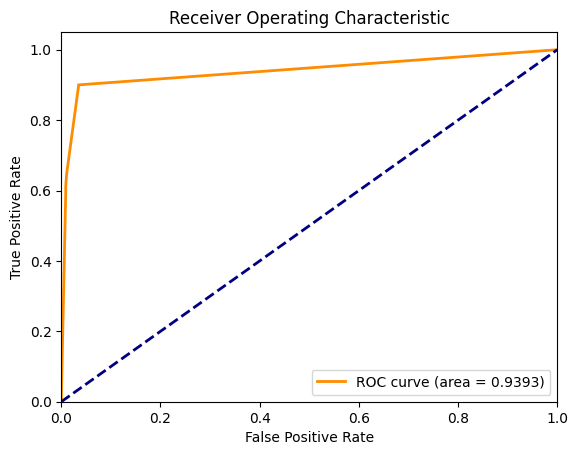

In [3]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(unsw_nb15.X_train, unsw_nb15.y_train)
y_pred_dt = dt_model.predict(unsw_nb15.X_test)
y_pred_prob_dt = dt_model.predict_proba(unsw_nb15.X_test)

dt_results = evaluate(unsw_nb15.y_test, y_pred_prob_dt[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
dt_results['attackwise_accuracy']

### Train and evaluate Random Forest Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.964802          1687604               1628203   
1           Worms  1.000000              190                   190   
2       Shellcode  0.810224             1428                  1157   
3  Reconnaissance  0.987079            11377                 11230   
4         Generic  0.961299             5452                  5241   
5         Fuzzers  0.827316            19000                 15719   
6        Exploits  0.962596            37697                 36287   
7             DoS  0.948957             4937                  4685   
8       Backdoors  0.867347              490                   425   
9        Analysis  0.671724              725                   487   

   misclassified  
0          59401  
1              0  
2            271  
3            147  
4            211  
5           3281  
6           1410  
7            252  
8             65  
9            238

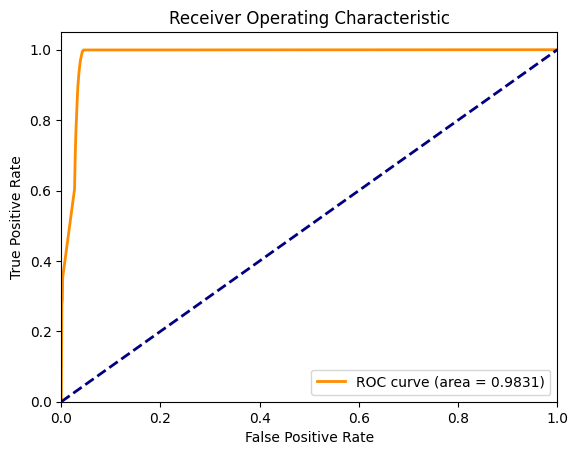

In [4]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(unsw_nb15.X_train, unsw_nb15.y_train)
y_pred_prob_rf = rf_model.predict_proba(unsw_nb15.X_test)

rf_results = evaluate(unsw_nb15.y_test, y_pred_prob_rf[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
rf_results['attackwise_accuracy']

### Train and evaluate eXtreme Gradient Boosting Baseline Model

/apps/conda/aespindola/envs/aespindola-base/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:27:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:1, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


category  accuracy  total_instances  correctly_classified  \
0          normal  0.958292          1687604               1617217   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  0.999473            11377                 11371   
4         Generic  0.994681             5452                  5423   
5         Fuzzers  0.990053            19000                 18811   
6        Exploits  0.995888            37697                 37542   
7             DoS  0.994126             4937                  4908   
8       Backdoors  0.983673              490                   482   
9        Analysis  0.875862              725                   635   

   misclassified  
0          70387  
1              0  
2              0  
3              6  
4             29  
5            189  
6            155  
7             29  
8              8  
9             90

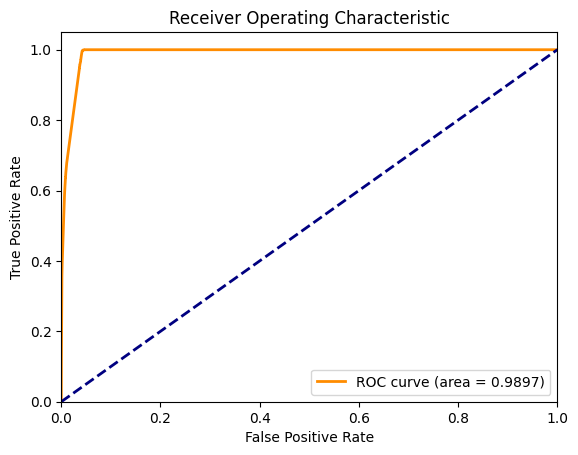

In [5]:
# threating the unbalanced dataset
scale_pos_weight = unsw_nb15.y_train.value_counts()[0] / unsw_nb15.y_train.value_counts()[1]
xgb_model = XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', device='cuda:1', scale_pos_weight=scale_pos_weight)
xgb_model.fit(unsw_nb15.X_train, unsw_nb15.y_train)
y_pred_prob_xgb = xgb_model.predict_proba(unsw_nb15.X_test)

xgb_results = evaluate(unsw_nb15.y_test, y_pred_prob_xgb[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
xgb_results['attackwise_accuracy']

### Load and evaluate Multilayer Perceptron Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.958505          1687604               1617577   
1           Worms  0.968421              190                   184   
2       Shellcode  0.933473             1428                  1333   
3  Reconnaissance  0.990595            11377                 11270   
4         Generic  0.968269             5452                  5279   
5         Fuzzers  0.976526            19000                 18554   
6        Exploits  0.990954            37697                 37356   
7             DoS  0.969820             4937                  4788   
8       Backdoors  0.965306              490                   473   
9        Analysis  0.965517              725                   700   

   misclassified  
0          70027  
1              6  
2             95  
3            107  
4            173  
5            446  
6            341  
7            149  
8             17  
9             25

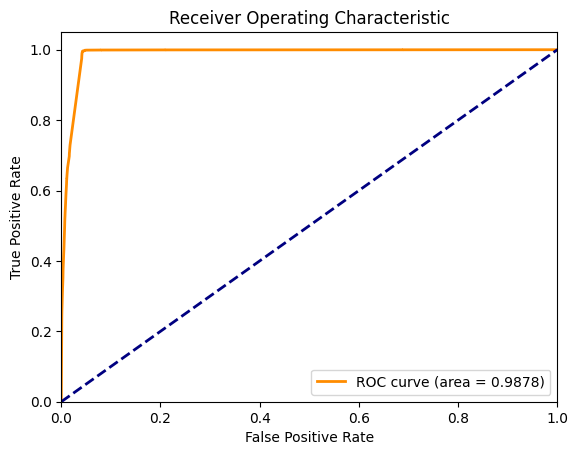

In [6]:
mlp_model = load_mlp(input_dim = unsw_nb15.X_train.shape[1], device_type='cpu')
y_pred_prob_mlp = get_probabilities(mlp_model, unsw_nb15.X_test, device='cpu')

mlp_results = evaluate(unsw_nb15.y_test, y_pred_prob_mlp, unsw_nb15.y_test_multiclass, threshold=0.3)
mlp_results['attackwise_accuracy']

### Load and evaluate Tabular Deep Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.958292          1687604               1617217   
1           Worms  0.984211              190                   187   
2       Shellcode  0.966387             1428                  1380   
3  Reconnaissance  0.980751            11377                 11158   
4         Generic  0.967168             5452                  5273   
5         Fuzzers  0.929947            19000                 17669   
6        Exploits  0.966576            37697                 36437   
7             DoS  0.955033             4937                  4715   
8       Backdoors  0.959184              490                   470   
9        Analysis  0.969655              725                   703   

   misclassified  
0          70387  
1              3  
2             48  
3            219  
4            179  
5           1331  
6           1260  
7            222  
8             20  
9             22

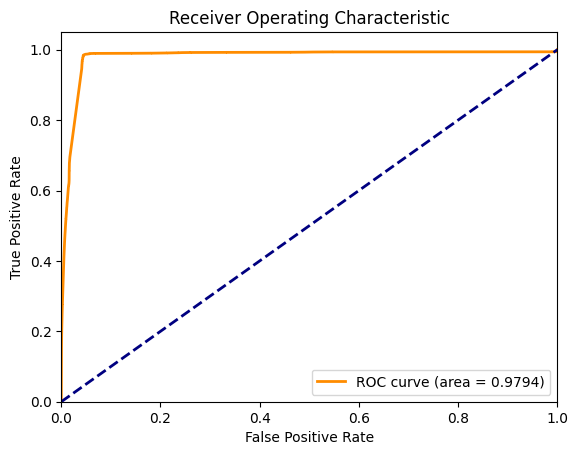

In [7]:
tabular_model = load_trained_tabular_deep_model(loader=unsw_nb15, layers=[512]*5, path='deep_5_512_fastai_default_usnw-nb15', device='cpu')
y_pred_prob_tabular = esp_utilities.predict_with_custom_threshold_deep(tabular_model.model, unsw_nb15.X_test, device='cpu', threshold=0.3, prob=True)

tabular_results = evaluate(unsw_nb15.y_test, y_pred_prob_tabular, unsw_nb15.y_test_multiclass, threshold=0.3)
tabular_results['attackwise_accuracy']

## Baseline Evolutionary Approaches - BEA (With Feature Selection)

### Train and evaluate Decision Tree Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.957030          1687604               1615088   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  0.999912            11377                 11376   
4         Generic  0.998716             5452                  5445   
5         Fuzzers  0.997158            19000                 18946   
6        Exploits  0.998780            37697                 37651   
7             DoS  0.999190             4937                  4933   
8       Backdoors  1.000000              490                   490   
9        Analysis  0.994483              725                   721   

   misclassified  
0          72516  
1              0  
2              0  
3              1  
4              7  
5             54  
6             46  
7              4  
8              0  
9              4

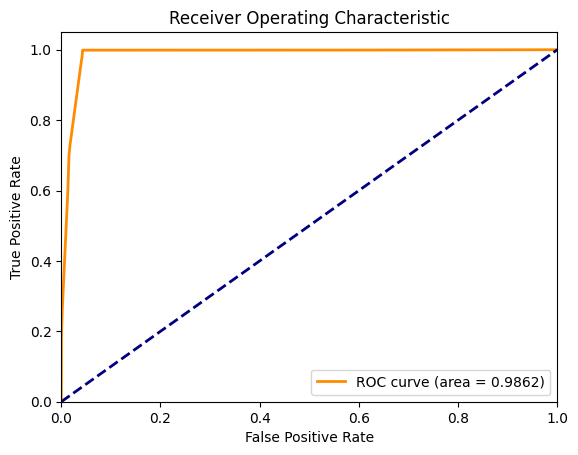

In [8]:
dt_ga_inf = get_ga_best_hyperparameters_and_features('dt', 'auc', data_loader=unsw_nb15, get_metrics=True)
dt_ga_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=dt_ga_inf['max_depth'])
dt_ga_feature_set = dt_ga_inf['selected_features_names']

dt_ga_model.fit(unsw_nb15.X_train[dt_ga_feature_set], unsw_nb15.y_train)
y_pred_dt = dt_ga_model.predict(unsw_nb15.X_test[dt_ga_feature_set])
y_pred_prob_dt_ga = dt_ga_model.predict_proba(unsw_nb15.X_test[dt_ga_feature_set])

dt_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_dt_ga[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
dt_ga_results['attackwise_accuracy']

In [9]:
print_optimization_infs(dt_ga_inf, 'dt')

Max depth: 6
Number TBF: 11
Number VBF: 10


### Train and evaluate Random Forest Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.957512          1687604               1615901   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  0.999824            11377                 11375   
4         Generic  0.999450             5452                  5449   
5         Fuzzers  0.998632            19000                 18974   
6        Exploits  0.999257            37697                 37669   
7             DoS  0.999595             4937                  4935   
8       Backdoors  0.997959              490                   489   
9        Analysis  0.993103              725                   720   

   misclassified  
0          71703  
1              0  
2              0  
3              2  
4              3  
5             26  
6             28  
7              2  
8              1  
9              5

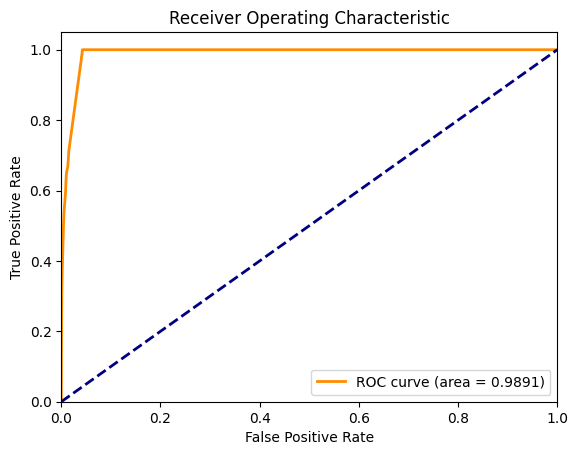

In [10]:
rf_ga_inf = get_ga_best_hyperparameters_and_features('rf', 'auc', data_loader=unsw_nb15, get_metrics=True)
rf_ga_model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=rf_ga_inf['max_depth'], n_estimators=rf_ga_inf['n_estimators'])
rf_ga_feature_set = rf_ga_inf['selected_features_names']

rf_ga_model.fit(unsw_nb15.X_train[rf_ga_feature_set], unsw_nb15.y_train)
y_pred_rf = rf_ga_model.predict(unsw_nb15.X_test[rf_ga_feature_set])
y_pred_prob_rf_ga = rf_ga_model.predict_proba(unsw_nb15.X_test[rf_ga_feature_set])

rf_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_rf_ga[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
rf_ga_results['attackwise_accuracy']

### Train and evaluate eXtreme Gradient Boosting Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.957615          1687604               1616075   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  0.999824            11377                 11375   
4         Generic  0.998166             5452                  5442   
5         Fuzzers  0.998421            19000                 18970   
6        Exploits  0.998674            37697                 37647   
7             DoS  0.997974             4937                  4927   
8       Backdoors  0.997959              490                   489   
9        Analysis  0.946207              725                   686   

   misclassified  
0          71529  
1              0  
2              0  
3              2  
4             10  
5             30  
6             50  
7             10  
8              1  
9             39

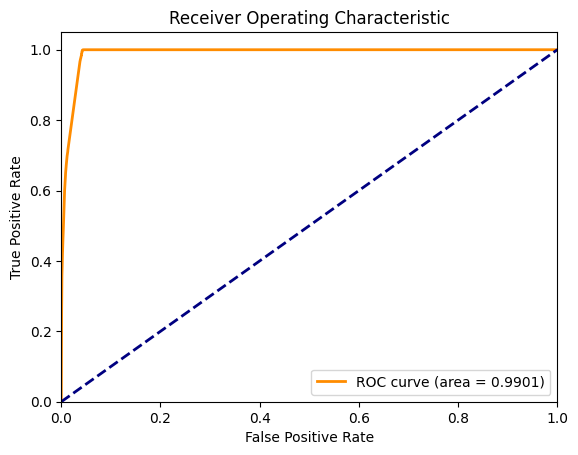

In [11]:
xgb_ga_inf = get_ga_best_hyperparameters_and_features('xgb', 'auc', data_loader=unsw_nb15, get_metrics=True)
scale_pos_weight = unsw_nb15.y_train.value_counts()[0] / unsw_nb15.y_train.value_counts()[1]
xgb_ga_model = XGBClassifier(
    random_state=42,
    max_depth=xgb_ga_inf['max_depth'], 
    n_estimators=xgb_ga_inf['n_estimators'], 
    tree_method='hist', 
    device='cuda:1', 
    scale_pos_weight=scale_pos_weight
    )

xgb_ga_feature_set = xgb_ga_inf['selected_features_names']
xgb_ga_model.fit(unsw_nb15.X_train[xgb_ga_feature_set], unsw_nb15.y_train)
y_pred_xgb = xgb_ga_model.predict(unsw_nb15.X_test[xgb_ga_feature_set])
y_pred_prob_xgb_ga = xgb_ga_model.predict_proba(unsw_nb15.X_test[xgb_ga_feature_set])

xgb_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_xgb_ga[:, 1], unsw_nb15.y_test_multiclass, threshold=0.5)
xgb_ga_results['attackwise_accuracy']

### Load and evaluate Multilayer Perceptron Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.957038          1687604               1615102   
1           Worms  1.000000              190                   190   
2       Shellcode  0.995798             1428                  1422   
3  Reconnaissance  0.998154            11377                 11356   
4         Generic  0.979090             5452                  5338   
5         Fuzzers  0.992789            19000                 18863   
6        Exploits  0.986445            37697                 37186   
7             DoS  0.981770             4937                  4847   
8       Backdoors  0.965306              490                   473   
9        Analysis  0.965517              725                   700   

   misclassified  
0          72502  
1              0  
2              6  
3             21  
4            114  
5            137  
6            511  
7             90  
8             17  
9             25

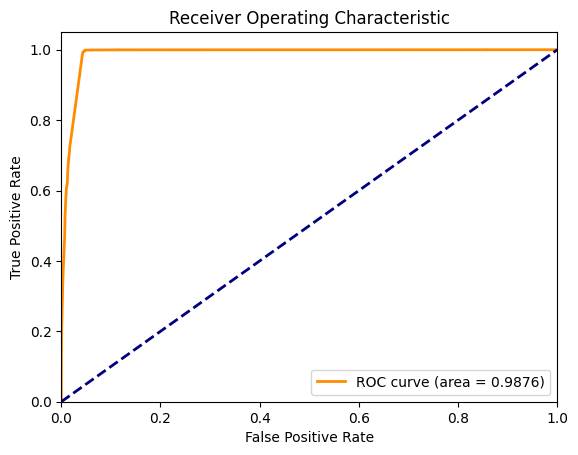

In [12]:
mlp_ga_inf = get_ga_best_hyperparameters_and_features('mlp', 'auc', data_loader=unsw_nb15, get_metrics=True)
mlp_ga_layer = mlp_ga_inf['n_layers']
mlp_ga_neuron = mlp_ga_inf['n_neurons']
mlp_ga_feature_set = mlp_ga_inf['selected_features_names']
mlp_ga_input_dim = len(mlp_ga_feature_set)
mlp_ga_model = load_mlp(input_dim=mlp_ga_input_dim, device_type='cpu', ga=True, num_layers=mlp_ga_layer, num_neuron=mlp_ga_neuron)

y_pred_prob_mlp_ga = get_probabilities(mlp_ga_model, unsw_nb15.X_test[mlp_ga_feature_set], device='cpu')

mlp_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_mlp_ga, unsw_nb15.y_test_multiclass, threshold=0.3)
mlp_ga_results['attackwise_accuracy']

### Load and evaluate Tabular Deep Baseline Model

category  accuracy  total_instances  correctly_classified  \
0          normal  0.954979          1687604               1611627   
1           Worms  0.994737              190                   189   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  0.999736            11377                 11374   
4         Generic  0.996515             5452                  5433   
5         Fuzzers  0.999842            19000                 18997   
6        Exploits  0.997745            37697                 37612   
7             DoS  0.997974             4937                  4927   
8       Backdoors  0.987755              490                   484   
9        Analysis  1.000000              725                   725   

   misclassified  
0          75977  
1              1  
2              0  
3              3  
4             19  
5              3  
6             85  
7             10  
8              6  
9              0

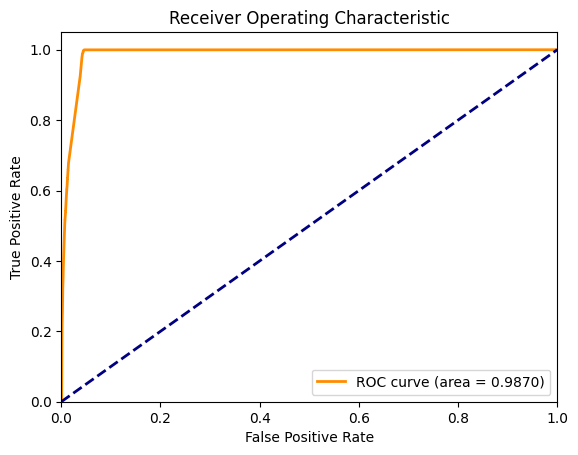

In [13]:
td_ga_inf = get_ga_best_hyperparameters_and_features('td', 'auc', data_loader=unsw_nb15, get_metrics=True)
td_ga_feature_set = td_ga_inf['selected_features_names']
# td_ga_input_dim = len(td_ga_feature_set)
td_ga_layers = [td_ga_inf['n_neurons']]*td_ga_inf['n_layers']
tabular_ga_path='deep_' + str(td_ga_inf['n_layers']) + '_' + str(td_ga_inf['n_neurons']) + '_fastai_ga_usnw-nb15'
tabular_ga_model = load_trained_tabular_deep_model(loader=unsw_nb15, layers=td_ga_layers, path=tabular_ga_path, device='cpu', feature_set=td_ga_feature_set)

y_pred_prob_tabular_ga = esp_utilities.predict_with_custom_threshold_deep(tabular_ga_model.model, unsw_nb15.X_test, device='cpu', threshold=0.3, prob=True, feature_set=td_ga_feature_set)
tabular_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_tabular_ga, unsw_nb15.y_test_multiclass, threshold=0.3)
tabular_ga_results['attackwise_accuracy']

category  accuracy  total_instances  correctly_classified  \
0          normal  0.957610          1687604               1616066   
1           Worms  0.978947              190                   186   
2       Shellcode  0.973389             1428                  1390   
3  Reconnaissance  0.982157            11377                 11174   
4         Generic  0.982575             5452                  5357   
5         Fuzzers  0.976053            19000                 18545   
6        Exploits  0.990105            37697                 37324   
7             DoS  0.975896             4937                  4818   
8       Backdoors  0.967347              490                   474   
9        Analysis  0.977931              725                   709   

   misclassified  
0          71538  
1              4  
2             38  
3            203  
4             95  
5            455  
6            373  
7            119  
8             16  
9             16

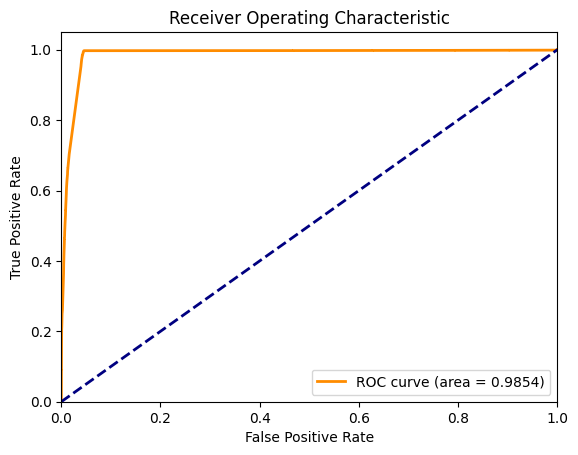

In [14]:
# td_ga_inf = get_ga_best_hyperparameters_and_features('td', 'auc', data_loader=unsw_nb15, get_metrics=True)
td_ga_inf = get_ga_best_hyperparameters_and_features('td', 'auc', data_loader=unsw_nb15, get_metrics=True, specific_solution=8)
td_ga_feature_set = td_ga_inf['selected_features_names']
# td_ga_input_dim = len(td_ga_feature_set)
td_ga_layers = [td_ga_inf['n_neurons']]*td_ga_inf['n_layers']
tabular_ga_path='deep_' + str(td_ga_inf['n_layers']) + '_' + str(td_ga_inf['n_neurons']) + '_fastai_ga_usnw-nb15'
tabular_ga_model = load_trained_tabular_deep_model(loader=unsw_nb15, layers=td_ga_layers, path=tabular_ga_path, device='cpu', feature_set=td_ga_feature_set)

y_pred_prob_tabular_ga = esp_utilities.predict_with_custom_threshold_deep(tabular_ga_model.model, unsw_nb15.X_test, device='cpu', threshold=0.3, prob=True, feature_set=td_ga_feature_set)
tabular_ga_results = evaluate(unsw_nb15.y_test, y_pred_prob_tabular_ga, unsw_nb15.y_test_multiclass, threshold=0.3)
tabular_ga_results['attackwise_accuracy']

## Compute BCA and BEA Ensemble Metrics

In [15]:
def ensemble_decision(y_pred_prob_dt, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_mlp, y_pred_prob_tabular):
    """
    Function to calculate binary classification results based on given thresholds and then 
    determine the ensemble decision using 'any vote' strategy.
    
    Parameters:
    y_pred_prob_dt (numpy.ndarray): Predicted probabilities from decision tree model.
    y_pred_prob_rf (numpy.ndarray): Predicted probabilities from random forest model.
    y_pred_prob_xgb (numpy.ndarray): Predicted probabilities from XGBoost model.
    y_pred_prob_mlp (pandas.Series): Predicted probabilities from MLP model.
    y_pred_prob_tabular (pandas.Series): Predicted probabilities from tabular model.
    
    Returns:
    pandas.DataFrame: DataFrame containing binary classification results for each model 
                      and the ensemble decision.
    """
    # Calculate binary results based on the given thresholds
    y_pred_dt = (y_pred_prob_dt[:, 1] > 0.5).astype(int)
    y_pred_rf = (y_pred_prob_rf[:, 1] > 0.5).astype(int)
    y_pred_xgb = (y_pred_prob_xgb[:, 1] > 0.5).astype(int)
    y_pred_mlp = (y_pred_prob_mlp > 0.3).astype(int)
    y_pred_tabular = (y_pred_prob_tabular > 0.3).astype(int)

    # Create DataFrame to store results
    results_df = pd.DataFrame({
        'y_pred_dt': y_pred_dt,
        'y_pred_rf': y_pred_rf,
        'y_pred_xgb': y_pred_xgb,
        'y_pred_mlp': y_pred_mlp,
        'y_pred_tabular': y_pred_tabular
    })
    
    # Calculate ensemble decision using 'any vote' strategy
    results_df['ensemble_decision'] = results_df.max(axis=1)
    
    return results_df


def prepare_data_for_accuracy_computation(y_pred_prob_dt, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_mlp, y_pred_prob_tabular):
    """
    Prepare data for compute_ensemble_attackwise_accuracy function.

    Parameters:
    - y_pred_prob_dt (numpy.ndarray): Predicted probabilities from decision tree model.
    - y_pred_prob_rf (numpy.ndarray): Predicted probabilities from random forest model.
    - y_pred_prob_xgb (numpy.ndarray): Predicted probabilities from XGBoost model.
    - y_pred_prob_mlp (pandas.Series): Predicted probabilities from MLP model.
    - y_pred_prob_tabular (pandas.Series): Predicted probabilities from tabular model.

    Returns:
    - dict: y_pred_dict containing predicted labels for each classifier.
    - dict: y_prob_dict containing predicted probabilities for each classifier.
    """
    # Calculate binary results based on the given thresholds
    y_pred_dt = (y_pred_prob_dt[:, 1] > 0.5).astype(int)
    y_pred_rf = (y_pred_prob_rf[:, 1] > 0.5).astype(int)
    y_pred_xgb = (y_pred_prob_xgb[:, 1] > 0.5).astype(int)
    y_pred_mlp = (y_pred_prob_mlp > 0.3).astype(int)
    y_pred_tabular = (y_pred_prob_tabular > 0.3).astype(int)
    
    # Prepare y_pred_dict
    y_pred_dict = {
        'dt': y_pred_dt,
        'rf': y_pred_rf,
        'xgb': y_pred_xgb,
        'mlp': y_pred_mlp,
        'td': y_pred_tabular
    }
    
    # Flatten the probability arrays to 1-dimensional for positive class
    y_prob_dict = {
        'dt': y_pred_prob_dt[:, 1],
        'rf': y_pred_prob_rf[:, 1],
        'xgb': y_pred_prob_xgb[:, 1],
        'mlp': y_pred_prob_mlp,
        'td': y_pred_prob_tabular
    }
    
    return y_pred_dict, y_prob_dict

In [16]:
bca_ensemble = ensemble_decision(y_pred_prob_dt, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_mlp, y_pred_prob_tabular)
bea_enesemble = ensemble_decision(y_pred_prob_dt_ga, y_pred_prob_rf_ga, y_pred_prob_xgb_ga, y_pred_prob_mlp_ga, y_pred_prob_tabular_ga)

In [17]:
esp_utilities.compute_attackwise_accuracy(unsw_nb15.y_test, bca_ensemble['ensemble_decision'], unsw_nb15.y_test_multiclass)

category  accuracy  total_instances  correctly_classified  \
0          normal  0.956364          1687604               1613964   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  1.000000            11377                 11377   
4         Generic  0.998349             5452                  5443   
5         Fuzzers  0.999632            19000                 18993   
6        Exploits  0.999761            37697                 37688   
7             DoS  0.999797             4937                  4936   
8       Backdoors  1.000000              490                   490   
9        Analysis  0.998621              725                   724   

   misclassified  
0          73640  
1              0  
2              0  
3              0  
4              9  
5              7  
6              9  
7              1  
8              0  
9              1

In [18]:
esp_utilities.compute_attackwise_accuracy(unsw_nb15.y_test, bea_enesemble['ensemble_decision'], unsw_nb15.y_test_multiclass)

category  accuracy  total_instances  correctly_classified  \
0          normal  0.956138          1687604               1613583   
1           Worms  1.000000              190                   190   
2       Shellcode  1.000000             1428                  1428   
3  Reconnaissance  1.000000            11377                 11377   
4         Generic  0.999817             5452                  5451   
5         Fuzzers  0.999947            19000                 18999   
6        Exploits  0.999973            37697                 37696   
7             DoS  0.999797             4937                  4936   
8       Backdoors  1.000000              490                   490   
9        Analysis  1.000000              725                   725   

   misclassified  
0          74021  
1              0  
2              0  
3              0  
4              1  
5              1  
6              1  
7              1  
8              0  
9              0

In [19]:
bca_y_pred_dict, bca_y_prob_dict = prepare_data_for_accuracy_computation(y_pred_prob_dt, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_mlp, y_pred_prob_tabular)
bea_y_pred_dict, bea_y_prob_dict = prepare_data_for_accuracy_computation(y_pred_prob_dt_ga, y_pred_prob_rf_ga, y_pred_prob_xgb_ga, y_pred_prob_mlp_ga, y_pred_prob_tabular_ga)

In [20]:
bca_attackwise = esp_utilities.compute_ensemble_attackwise_accuracy(y=unsw_nb15.y_test, y_multiclass=unsw_nb15.y_test_multiclass, y_pred_dict=bca_y_pred_dict, strategy='any', clf_name=None, y_prob_dict=bca_y_prob_dict, y_prob_train_dict=None, y_train=None)
bca_attackwise

category total_instances  dt_accuracy  rf_accuracy  xgb_accuracy  \
0           normal         1687604     0.964850     0.964802      0.958292   
1            Worms             190     0.921053     1.000000      1.000000   
2        Shellcode            1428     0.726891     0.810224      1.000000   
3   Reconnaissance           11377     0.973631     0.987079      0.999473   
4          Generic            5452     0.933602     0.961299      0.994681   
5          Fuzzers           19000     0.779947     0.827316      0.990053   
6         Exploits           37697     0.941322     0.962596      0.995888   
7              DoS            4937     0.926879     0.948957      0.994126   
8        Backdoors             490     0.818367     0.867347      0.983673   
9         Analysis             725     0.713103     0.671724      0.875862   
10             AUC               -     0.939328     0.983086      0.989671   

    mlp_accuracy  td_accuracy  ensemble_accuracy  
0       0.958505     0.958292           0.956364  
1       0.968421     0.984211           1.000000  
2       0.933473     0.966387           1.000000  
3       0.990595     0.980751           1.000000  
4       0.968269     0.967168           0.998349  
5       0.976526     0.929947           0.999632  
6       0.990954     0.966576           0.999761  
7       0.969820     0.955033           0.999797  
8       0.965306     0.959184           1.000000  
9       0.965517     0.969655           0.998621  
10      0.987817     0.979440           0.988252

In [21]:
bea_attackwise = esp_utilities.compute_ensemble_attackwise_accuracy(y=unsw_nb15.y_test, y_multiclass=unsw_nb15.y_test_multiclass, y_pred_dict=bea_y_pred_dict, strategy='any', clf_name=None, y_prob_dict=bea_y_prob_dict, y_prob_train_dict=None, y_train=None)
bea_attackwise

category total_instances  dt_accuracy  rf_accuracy  xgb_accuracy  \
0           normal         1687604     0.957030     0.957512      0.957615   
1            Worms             190     1.000000     1.000000      1.000000   
2        Shellcode            1428     1.000000     1.000000      1.000000   
3   Reconnaissance           11377     0.999912     0.999824      0.999824   
4          Generic            5452     0.998716     0.999450      0.998166   
5          Fuzzers           19000     0.997158     0.998632      0.998421   
6         Exploits           37697     0.998780     0.999257      0.998674   
7              DoS            4937     0.999190     0.999595      0.997974   
8        Backdoors             490     1.000000     0.997959      0.997959   
9         Analysis             725     0.994483     0.993103      0.946207   
10             AUC               -     0.986247     0.989060      0.990070   

    mlp_accuracy  td_accuracy  ensemble_accuracy  
0       0.957038     0.957610           0.956138  
1       1.000000     0.978947           1.000000  
2       0.995798     0.973389           1.000000  
3       0.998154     0.982157           1.000000  
4       0.979090     0.982575           0.999817  
5       0.992789     0.976053           0.999947  
6       0.986445     0.990105           0.999973  
7       0.981770     0.975896           0.999797  
8       0.965306     0.967347           1.000000  
9       0.965517     0.977931           1.000000  
10      0.987575     0.985411           0.988634

In [22]:
import pandas as pd

def weighted_accuracy(data):
    """
    Calculate the weighted accuracy of the given data.
    
    Parameters:
    - data (dict): Dictionary containing the following keys:
        - 'category' (list): List of attack categories.
        - 'total_instances' (list): List of total instances for each attack category.
        - 'ensemble_accuracy' (list): List of ensemble accuracy values for each attack category.
    
    Returns:
    - float: Weighted accuracy of the given data.
    """
    # Create a DataFrame from the given data
    df = pd.DataFrame(data)
    
    # Filter the categories of attack (excluding 'normal')
    df_attacks = df[df['category'] != 'normal']
    
    # Calculate the weighted accuracy of the attacks
    weighted_accuracy = (df_attacks['ensemble_accuracy'] * df_attacks['total_instances']).sum() / df_attacks['total_instances'].sum()
    
    return weighted_accuracy

# Dados da tabela fornecida
bea = {
    'category': ['normal', 'Worms', 'Shellcode', 'Reconnaissance', 'Generic', 'Fuzzers', 'Exploits', 'DoS', 'Backdoors', 'Analysis'],
    'total_instances': [1687604, 190, 1428, 11377, 5452, 19000, 37697, 4937, 490, 725],
    'ensemble_accuracy': [0.956138, 1.000000, 1.000000, 1.000000, 0.999817, 0.999947, 0.999973, 0.999797, 1.000000, 1.000000]
}

dea = {
    'category': ['normal', 'Worms', 'Shellcode', 'Reconnaissance', 'Generic', 'Fuzzers', 'Exploits', 'DoS', 'Backdoors', 'Analysis'],
    'total_instances': [1687604, 190, 1428, 11377, 5452, 19000, 37697, 4937, 490, 725],
    'ensemble_accuracy': [0.957048, 1.000000, 1.000000, 0.999912, 0.997799, 0.997474, 0.998170, 0.995341, 1.000000, 0.994483]
}
print(f'bea: {weighted_accuracy(bea)}')
print(f'dea: {weighted_accuracy(dea)}')

bea: 0.9999504926933676
dea: 0.9980690089795314


# Evaluation of Exploitable Scenarios.

## General results

In [23]:
import copy

def ensemble_attack_evaluation(df, strategy='majority', clf=None):
    ensemble_results = []

    # Agrupar o DataFrame por 'attack' e 'factor'
    grouped = df.groupby(['attack', 'factor'])

    for (attack, factor), group in grouped:
        # Extrair todas as predições y_hat para o grupo atual
        all_preds = np.array(group['y_hat'].tolist())

        probs = group[['model', 'y_prob']]

        # Transformar as listas de 'y_prob' em DataFrame
        probs_df = pd.DataFrame(probs['y_prob'].tolist(), index=probs['model'])
        
        # Transpor o DataFrame para que cada coluna seja um classificador
        probs_df = probs_df.transpose()
        
        # Calcular o voto da maioria para as predições
        if clf is None:
            y_vote = esp_utilities.voting_strategy(all_preds, strategy=strategy, test_probs=probs_df)
        else:
            y_vote = clf.predict(probs_df)
            y_vote = y_vote.astype(int)
        
        # Calcular o ASR para o y_vote (precisa do y_true)
        asr = esp_utilities.compute_evasion_rate(np.ones(len(y_vote)), y_vote)
        
        # Adicionar ao DataFrame de resultados do ensemble
        ensemble_results.append({
            'model': 'ensemble',
            'attack': attack,
            'factor': factor,
            'asr': asr,
            'y_hat': y_vote
        })

    # Converter a lista de resultados em um DataFrame
    ensemble_df = pd.DataFrame(ensemble_results)
    final_df = pd.concat([df, ensemble_df], ignore_index=True)
    final_df = final_df.sort_values(by=['attack', 'factor'])
    final_df.reset_index(drop=True, inplace=True)
    return ensemble_df, final_df

def update_dictionary_with_ensemble(ensemble_df, result_dict):
    """
    
    """
    updated_dict = copy.deepcopy(result_dict)
    
    for index, row in ensemble_df.iterrows():
        model = row['model']
        attack = row['attack']
        factor = row['factor']
        asr = row['asr']

        # Create key for 'model' if it doesn't exist
        if model not in updated_dict:
            updated_dict[model] = {}
        
        # Create key for 'attack' if it doesn't exist
        if attack not in updated_dict[model]:
            updated_dict[model][attack] = {}
        
        # Add the ASR value to the dictionary
        updated_dict[model][attack][factor] = asr

    return updated_dict

### BCA Robustness Evaluation Overview

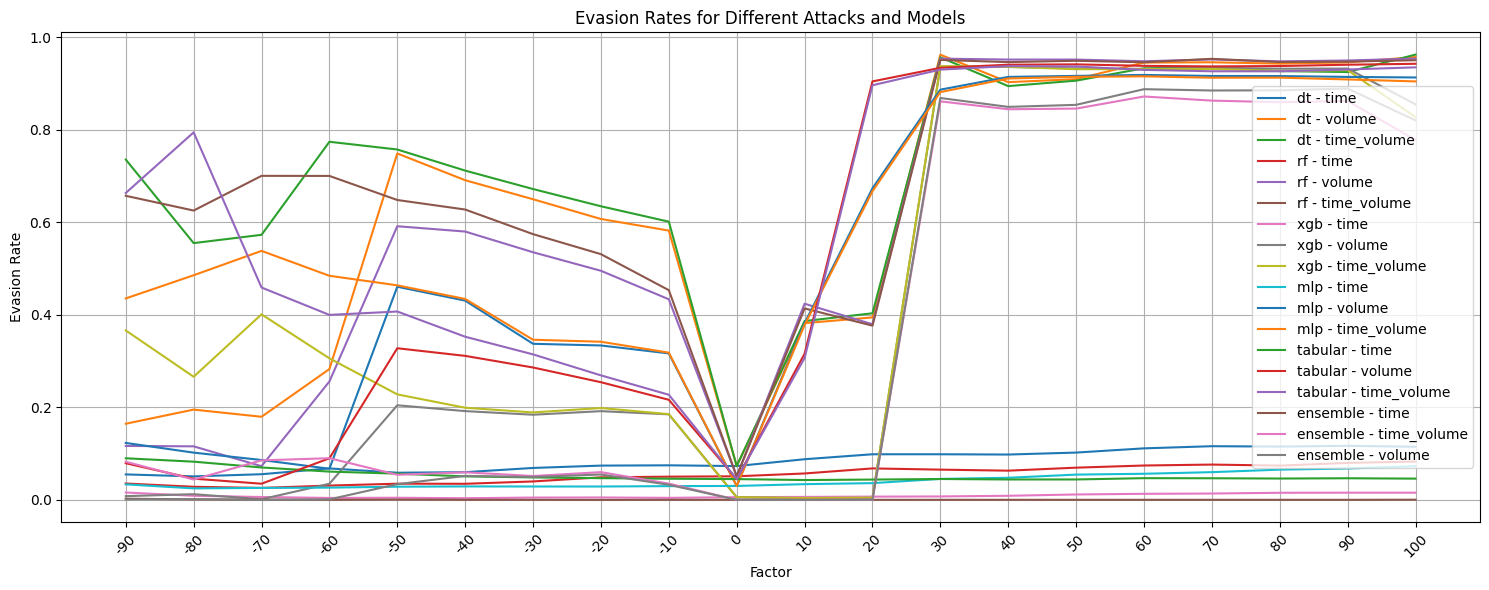

In [24]:
attack_datasets = esp_utilities.load_realistic_attacks(data_loader=unsw_nb15)

attack_evaluation_results_dict, attack_evaluation_results_df = esp_utilities.attack_evaluation(
    attack_datasets=attack_datasets, 
    models= {'dt': dt_model, 'rf': rf_model, 'xgb': xgb_model, 'mlp': mlp_model, 'tabular': tabular_model}, #'resnet': resnet18_model}, 
    nw_attack='DoS',
    feature_set=unsw_nb15.X_test.columns.to_list(),
    threshold=(0.5, 0.3), # 0.5 (default) for rf and xgb and 0.3 for mlp
    device='cpu'
    )

ensemble_df, attack_evaluation_results_df = ensemble_attack_evaluation(attack_evaluation_results_df, strategy='any')
attack_evaluation_results_dict = update_dictionary_with_ensemble(ensemble_df, attack_evaluation_results_dict)

plot_attack_evaluation(attack_evaluation_results_dict, figsize=(15, 6))
# esp_utilities.save_to_pickle(attack_evaluation_results_dict, '../results/realistic/realistic_no_feature_selection.pkl')

In [25]:
esp_utilities.save_to_pickle(attack_evaluation_results_dict, '../results/realistic/realistic_no_feature_selection_any.pkl')

### BEA Robustness Evaluation Overview

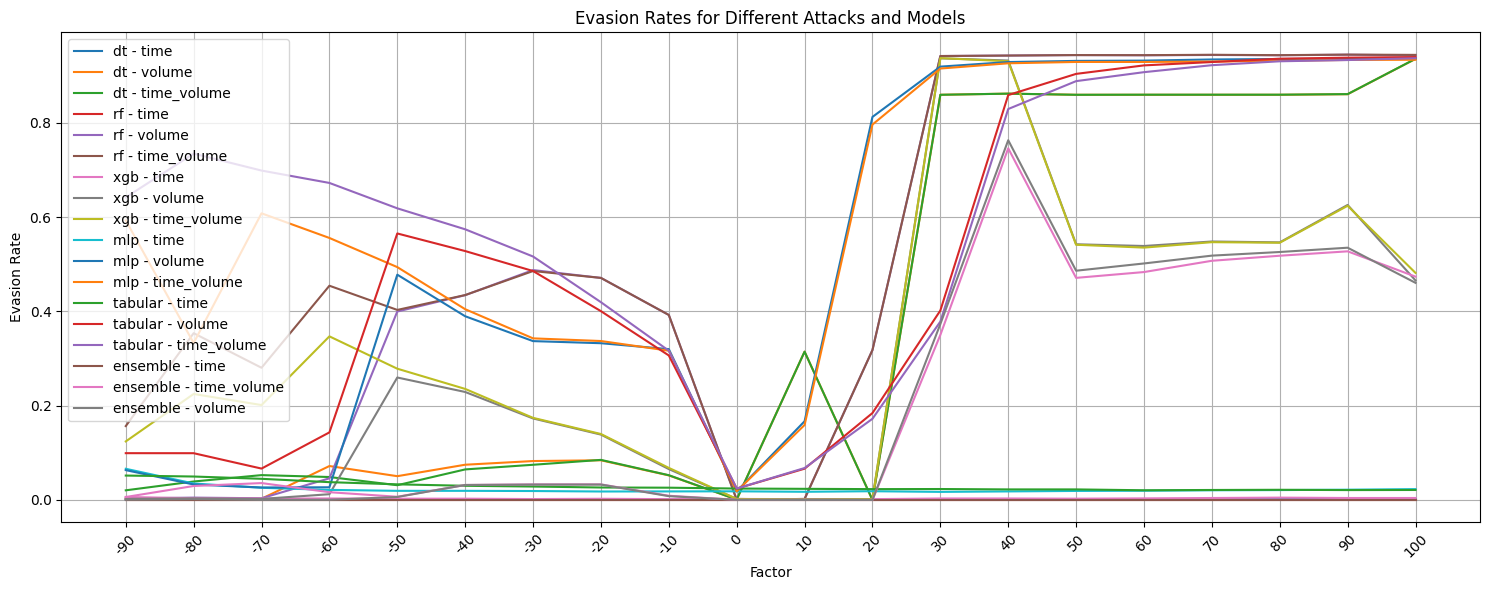

In [26]:
feature_set_dict = {
    'dt': dt_ga_inf['selected_features_names'],
    'rf': rf_ga_inf['selected_features_names'],
    'xgb': xgb_ga_inf['selected_features_names'],
    'mlp': mlp_ga_inf['selected_features_names'],
    'tabular': td_ga_inf['selected_features_names']
}

attack_datasets = esp_utilities.load_realistic_attacks(data_loader=unsw_nb15)
attack_evaluation_results_dict_ga, attack_evaluation_results_df_ga  = esp_utilities.attack_evaluation(
    attack_datasets=attack_datasets, 
    models= {'dt': dt_ga_model, 'rf': rf_ga_model, 'xgb': xgb_ga_model, 'mlp': mlp_ga_model, 'tabular': tabular_ga_model},
    nw_attack='DoS',
    feature_set=unsw_nb15.X_test.columns.to_list(),
    threshold=(0.5, 0.3), # 0.5 (default) for rf and xgb and 0.3 for mlp
    feature_set_dict=feature_set_dict,
    device='cpu'
    )

ensemble_df_ga, attack_evaluation_results_df_ga = ensemble_attack_evaluation(attack_evaluation_results_df_ga, strategy='any')
attack_evaluation_results_dict_ga = update_dictionary_with_ensemble(ensemble_df_ga, attack_evaluation_results_dict_ga)

plot_attack_evaluation(attack_evaluation_results_dict_ga, figsize=(15, 6))
# esp_utilities.save_to_pickle(attack_evaluation_results_dict_ga, '../results/realistic/realistic_ga_feature_selection.pkl')

In [27]:
esp_utilities.save_to_pickle(attack_evaluation_results_dict_ga, '../results/realistic/realistic_ga_feature_selection_any.pkl')

## BCA Robustness Evaluation - Exploitable

In [28]:
# Plot settings
color_scheme = ['#73C698', '#DBB84D', '#1A6FDF', '#F14040', '#756BB1', '#d62728'] # colors based on a paper
marker_scheme = ['^', 'o', 's', 'D', 'P', '*']
# classifier_color = {'time': color_scheme[0], 'volume': color_scheme[1], 'time_volume': color_scheme[2]}
classifier_marker = {'rf': marker_scheme[0], 'xgb': marker_scheme[1], 'mlp': marker_scheme[2], 'tabular': marker_scheme[3], 'dt': marker_scheme[4], 'ensemble': marker_scheme[5]}
classifier_color = {'rf': color_scheme[0], 'xgb': color_scheme[1], 'mlp': color_scheme[2], 'tabular': color_scheme[3], 'dt': color_scheme[4], 'ensemble': color_scheme[5]}
all_attacks = ['time', 'volume', 'time_volume']

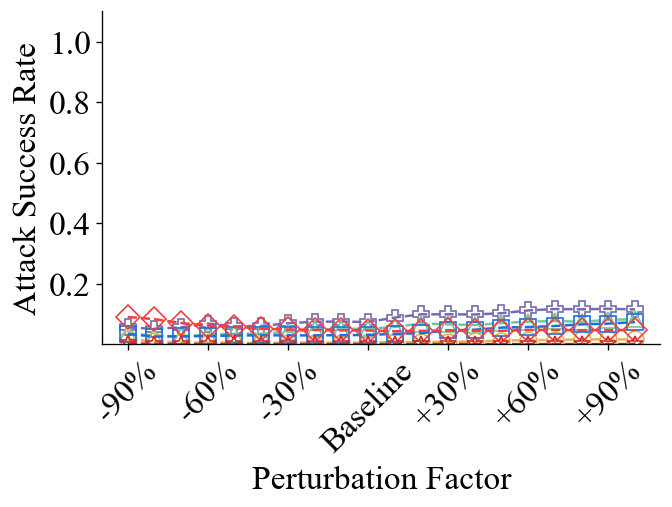

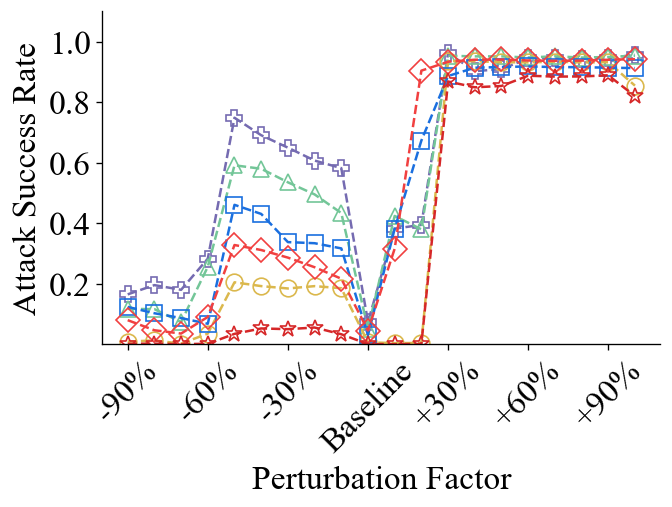

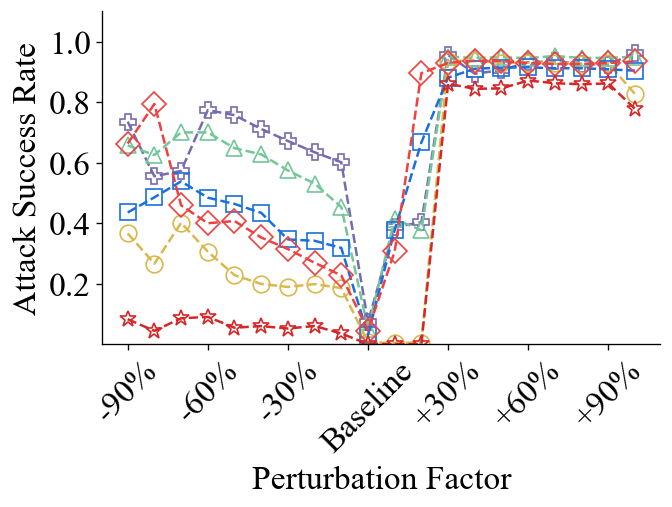

In [29]:
esp_utilities.plot_legend_by_attack(classifier_color, classifier_marker, line_width=3, symbol_size=12, fig_width=18, fig_height=0.15, output_filename=None, ours=False)# output_filename='legend_feasible_by_attack.pdf')
for attack in all_attacks:
    attack_data = {}  # Dicionário para armazenar dados de todos os classificadores para este ataque
    for classifier, attacks in attack_evaluation_results_dict.items():
        if attack in attacks:
            attack_data[classifier] = attacks[attack]

    if attack_data:  # Verifica se há dados para este tipo de ataque
        esp_utilities.line_plot_by_attack(
            attack_data,
            classifier_color,
            classifier_marker,
            # output_filename=f'feasible_full_features_{attack}.pdf',
            dpi=120,
            fig_size=(6, 3.6),
            global_font_size=20,
            xlabel='Perturbation Factor',
            plot_fake=False
        )
# path = '../results/realistic/figures/'

## BEA Robustness Evaluation - Exploitable

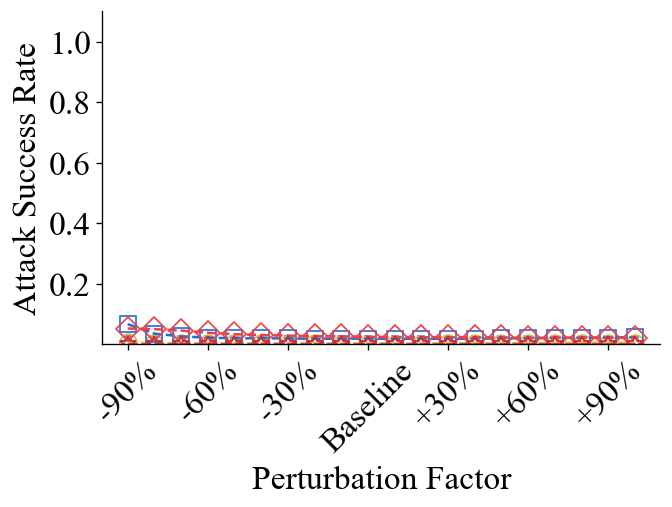

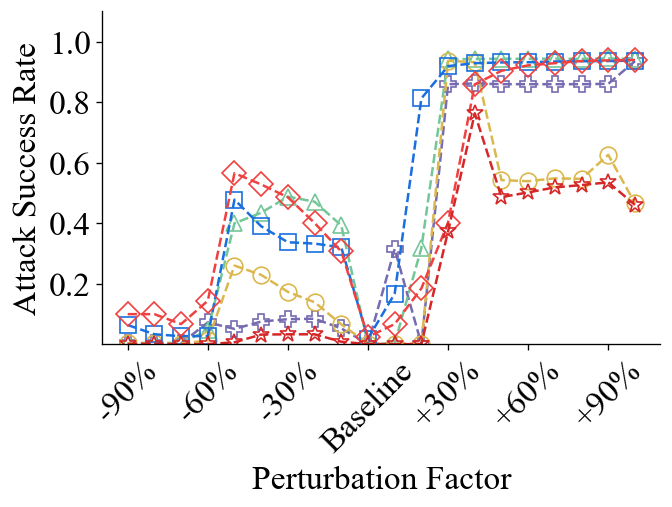

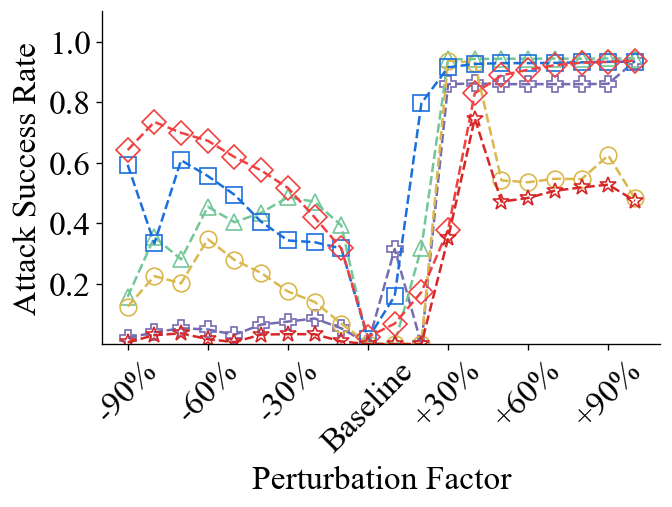

In [30]:
esp_utilities.plot_legend_by_attack(classifier_color, classifier_marker, line_width=3, symbol_size=12, fig_width=18, fig_height=0.15, output_filename=None, ours=False)# output_filename='legend_feasible_by_attack.pdf')
for attack in all_attacks:
    attack_data = {}  # Dicionário para armazenar dados de todos os classificadores para este ataque
    for classifier, attacks in attack_evaluation_results_dict_ga.items():
        if attack in attacks:
            attack_data[classifier] = attacks[attack]

    if attack_data:  # Verifica se há dados para este tipo de ataque
        esp_utilities.line_plot_by_attack(
            attack_data,
            classifier_color,
            classifier_marker,
            # output_filename=f'feasible_ga_features_{attack}.pdf',
            dpi=120,
            fig_size=(6, 3.6),
            global_font_size=20,
            xlabel='Perturbation Factor',
            plot_fake=False
        )
# path = '../results/realistic/figures/'

# Evaluation of Unexploitable Scenarios

## BCA Robustness Evaluation - Unexploitable

In [31]:
mlp_adv_time_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_adv_exp_target_DoS_time_based_features.pkl')
mlp_adv_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_adv_exp_target_DoS_volume_based_features.pkl') 
mlp_adv_time_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_adv_exp_target_DoS_mixed_features.pkl') 

mlp_result_time = model_evaluation(mlp_adv_time_dos, model=None, threshold=0.3, detected_attacks_only=True)
mlp_result_volume = model_evaluation(mlp_adv_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)
mlp_result_time_volume = model_evaluation(mlp_adv_time_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)


tabular_adv_time_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_5_512_fastai_adv_exp_target_DoS_time_based_features.pkl')
tabular_adv_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_5_512_fastai_adv_exp_target_DoS_volume_based_features.pkl') 
tabular_adv_time_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_5_512_fastai_adv_exp_target_DoS_mixed_features.pkl') 

tabular_result_time = model_evaluation(tabular_adv_time_dos, model=None, threshold=0.3, detected_attacks_only=True)
tabular_result_volume = model_evaluation(tabular_adv_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)
tabular_result_time_volume = model_evaluation(tabular_adv_time_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)


classifier_color = {
    'mlp_FGSM': color_scheme[0],
    'mlp_PGD': color_scheme[1],
    'td_FGSM': color_scheme[2],
    'td_PGD': color_scheme[3]
}

classifier_marker = {
    'mlp_FGSM': marker_scheme[0],
    'mlp_PGD': marker_scheme[1],
    'td_FGSM': marker_scheme[2],
    'td_PGD': marker_scheme[3]
}

classifier_color = {
    'FGSM (MLP)': color_scheme[0],
    'PGD (MLP)': color_scheme[1],
    'FGSM (TD)': color_scheme[2],
    'PGD (TD)': color_scheme[3]
}

classifier_marker = {
    'FGSM (MLP)': marker_scheme[0],
    'PGD (MLP)': marker_scheme[1],
    'FGSM (TD)': marker_scheme[2],
    'PGD (TD)': marker_scheme[3]
}

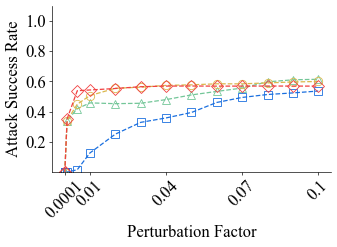

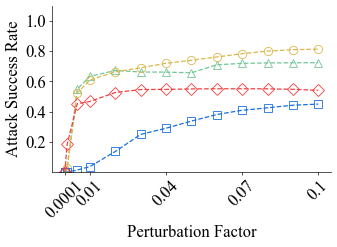

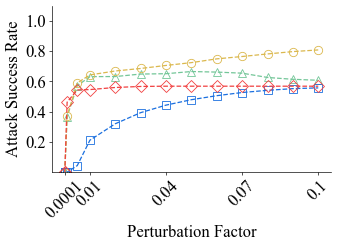

In [32]:
esp_utilities.plot_legend_by_attack(classifier_color, classifier_marker, line_width=3, symbol_size=12, fig_width=14.5, fig_height=0.15, output_filename=None)# output_filename='legend_unfeasible_by_attack.pdf')
for mlp_r, tabular_r, att in zip([mlp_result_time, mlp_result_volume, mlp_result_time_volume], [tabular_result_time, tabular_result_volume, tabular_result_time_volume], ['time', 'volume', 'time_volume']):
    combined_data = {
        'FGSM (MLP)': mlp_r['FGSM'],
        'PGD (MLP)': mlp_r['PGD'],
        'FGSM (TD)': tabular_r['FGSM'],
        'PGD (TD)': tabular_r['PGD']
    }

    esp_utilities.line_plot_by_attack(
        combined_data,
        classifier_color,  # Este dicionário precisa ter cores para 'mlp_FGSM', 'mlp_PGD', 'tabular_FGSM', 'tabular_PGD'
        classifier_marker, # Este dicionário precisa ter marcadores para 'mlp_FGSM', 'mlp_PGD', 'tabular_FGSM', 'tabular_PGD'
        # output_filename=f'unfeasible_full_features_{att}.pdf',
        dpi=60,
        fig_size=(6, 3.6),
        global_font_size=20,
        xlabel='Perturbation Factor',
        plot_fake=False,
        linestyle='--',
        fillstyle='none',
        markersize=10, 
        linewidth=1.5,
        ignore_first_xstick=True
    )

## BEA Robustness Evaluation - Unexploitable

In [33]:
# t = unsw_nb15.get_full_test_set()
# t = t.loc[t['attackCategory']=='DoS']

mlp_ga_adv_time_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_ga_adv_exp_target_DoS_time_based_features.pkl')
mlp_ga_adv_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_ga_adv_exp_target_DoS_volume_based_features.pkl') 
mlp_ga_adv_time_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_mlp_ga_adv_exp_target_DoS_mixed_features.pkl') 

mlp_ga_result_time = model_evaluation(mlp_ga_adv_time_dos, model=None, threshold=0.3, detected_attacks_only=True)
mlp_ga_result_volume = model_evaluation(mlp_ga_adv_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)
mlp_ga_result_time_volume = model_evaluation(mlp_ga_adv_time_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)



tabular_ga_adv_time_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_ga_fastai_adv_exp_target_DoS_time_based_features.pkl')
tabular_ga_adv_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_ga_fastai_adv_exp_target_DoS_volume_based_features.pkl') 
tabular_ga_adv_time_volume_dos = esp_utilities.load_from_pickle('../datasets/unrealistic_attacks/unsw-nb15_tabular_deep_ga_fastai_adv_exp_target_DoS_mixed_features.pkl') 

tabular_ga_result_time = model_evaluation(tabular_ga_adv_time_dos, model=None, threshold=0.3, detected_attacks_only=True)
tabular_ga_result_volume = model_evaluation(tabular_ga_adv_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)
tabular_ga_result_time_volume = model_evaluation(tabular_ga_adv_time_volume_dos, model=None, threshold=0.3, detected_attacks_only=True)


classifier_color = {
    'mlp_FGSM': color_scheme[0],
    'mlp_PGD': color_scheme[1],
    'td_FGSM': color_scheme[2],
    'td_PGD': color_scheme[3]
}

classifier_marker = {
    'mlp_FGSM': marker_scheme[0],
    'mlp_PGD': marker_scheme[1],
    'td_FGSM': marker_scheme[2],
    'td_PGD': marker_scheme[3]
}

classifier_color = {
    'FGSM (MLP)': color_scheme[0],
    'PGD (MLP)': color_scheme[1],
    'FGSM (TD)': color_scheme[2],
    'PGD (TD)': color_scheme[3]
}

classifier_marker = {
    'FGSM (MLP)': marker_scheme[0],
    'PGD (MLP)': marker_scheme[1],
    'FGSM (TD)': marker_scheme[2],
    'PGD (TD)': marker_scheme[3]
}

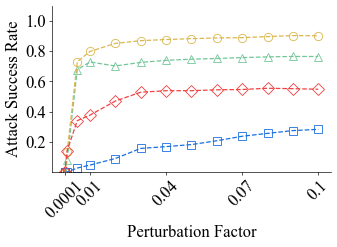

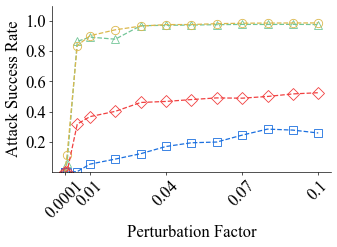

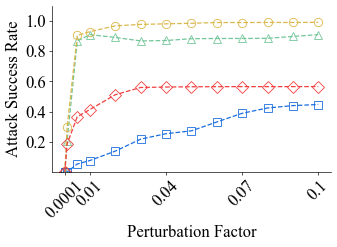

In [34]:
esp_utilities.plot_legend_by_attack(classifier_color, classifier_marker, line_width=3, symbol_size=12, fig_width=14.5, fig_height=0.15, output_filename=None)# output_filename='legend_unfeasible_by_attack.pdf')
for mlp_r, tabular_r, att in zip([mlp_ga_result_time, mlp_ga_result_volume, mlp_ga_result_time_volume], [tabular_ga_result_time, tabular_ga_result_volume, tabular_ga_result_time_volume], ['time', 'volume', 'time_volume']):
    combined_data = {
        'FGSM (MLP)': mlp_r['FGSM'],
        'PGD (MLP)': mlp_r['PGD'],
        'FGSM (TD)': tabular_r['FGSM'],
        'PGD (TD)': tabular_r['PGD']
    }

    esp_utilities.line_plot_by_attack(
        combined_data,
        classifier_color,  # Este dicionário precisa ter cores para 'mlp_FGSM', 'mlp_PGD', 'tabular_FGSM', 'tabular_PGD'
        classifier_marker, # Este dicionário precisa ter marcadores para 'mlp_FGSM', 'mlp_PGD', 'tabular_FGSM', 'tabular_PGD'
        # output_filename=f'unfeasible_ga_features_{att}.pdf',
        dpi=60,
        fig_size=(6, 3.6),
        global_font_size=20,
        xlabel='Perturbation Factor',
        plot_fake=False,
        linestyle='--',
        fillstyle='none',
        markersize=10, 
        linewidth=1.5,
        ignore_first_xstick=True
    )

# Feature Selection Analysis

In [35]:
def get_features_used_per_view(feature_set_dict, time_based_features=time_based_features, volume_based_features=volume_based_features, sorted_features=sorted_features):
    used_features = {}
    for key, value in feature_set_dict.items():
        time_intersection = list(set(value) & set(time_based_features))
        volume_intersection = list(set(value) & set(volume_based_features))
        
        used_features[key.upper()] = {
            'time': sorted([sorted_features.index(item) for item in time_intersection if item in sorted_features]),
            'volume': sorted([sorted_features.index(item) for item in volume_intersection if item in sorted_features]),
            'time count': len(time_intersection),
            'volume count': len(volume_intersection),
            'total count': len(value)
        }
    return pd.DataFrame(used_features).T

def get_count_features_usage(feature_set_dict, sorted_features=sorted_features):
    count_usage = {f: {'count': 0, 'clf': []} for f in sorted_features}

    for key, value in feature_set_dict.items():
        for item in value:
            count_usage[item]['count'] += 1
            count_usage[item]['clf'].append(key)
    
    result_list = [[feature, count_usage[feature]['count'], count_usage[feature]['clf']] for feature in sorted_features]
    result_df = pd.DataFrame(result_list, columns=['feature', 'count', 'classifiers'])
    return result_df

In [36]:
df_features_used_per_view = get_features_used_per_view(feature_set_dict)
df_features_used_per_view

time  \
DT                                   [1, 5, 6, 8, 10, 13, 16, 17, 19, 20, 22]   
RF                                                       [13, 14, 15, 17, 22]   
XGB                                     [3, 6, 8, 12, 13, 14, 16, 18, 20, 22]   
MLP      [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 23]   
TABULAR                        [0, 1, 3, 5, 6, 7, 10, 12, 17, 19, 20, 21, 22]   

                                                                       volume  \
DT                                   [24, 28, 30, 35, 38, 40, 41, 42, 43, 44]   
RF                           [27, 28, 29, 33, 35, 38, 40, 41, 42, 43, 45, 47]   
XGB          [24, 27, 29, 30, 32, 35, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48]   
MLP              [24, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 41, 45, 47]   
TABULAR  [26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 44, 46, 48]   

        time count volume count total count  
DT              11           10          21  
RF               5           12          17  
XGB             10           16          26  
MLP             19           15          34  
TABULAR         13           17          30

In [37]:
df_count_features_usage = get_count_features_usage(feature_set_dict)
df_count_features_usage.sort_values(by='count', ascending=False)

feature  count                  classifiers
35              ipTotalLengthStdevFwd      5  [dt, rf, xgb, mlp, tabular]
38               maximumIpTotalLength      5  [dt, rf, xgb, mlp, tabular]
22       interPacketTimeSecondsSumFwd      5  [dt, rf, xgb, mlp, tabular]
29                   ipTotalLengthFwd      4      [rf, xgb, mlp, tabular]
28                      ipTotalLength      4       [dt, rf, mlp, tabular]
27                        fwdBytesAvg      4      [rf, xgb, mlp, tabular]
43            minimumIpTotalLengthBwd      4       [dt, rf, xgb, tabular]
20     interPacketTimeSecondsStdevFwd      4      [dt, xgb, mlp, tabular]
40            maximumIpTotalLengthBwd      4       [dt, rf, xgb, tabular]
17      interPacketTimeSecondsMeanFwd      4       [dt, rf, mlp, tabular]
41               minimumIpTotalLength      4           [dt, rf, xgb, mlp]
24                        bwdBytesAvg      3               [dt, xgb, mlp]
33               ipTotalLengthMeanBwd      3           [rf, mlp, tabular]
37                   ipTotalLengthVar      3          [xgb, mlp, tabular]
1          activeTimeMeanMilliseconds      3           [dt, mlp, tabular]
19        interPacketTimeSecondsStdev      3           [dt, mlp, tabular]
16         interPacketTimeSecondsMean      3               [dt, xgb, mlp]
14       interPacketTimeSecondsMaxFwd      3               [rf, xgb, mlp]
13          interPacketTimeSecondsMax      3                [dt, rf, xgb]
12  interPacketTimeMillisecondsSumFwd      3          [xgb, mlp, tabular]
42            minimumIpTotalLengthFwd      3                [dt, rf, xgb]
10   interPacketTimeMillisecondsStdev      3           [dt, mlp, tabular]
8         interPacketTimeMilliseconds      3               [dt, xgb, mlp]
44                    octetTotalCount      3           [dt, xgb, tabular]
6                idleMeanMilliseconds      3           [dt, xgb, tabular]
5                 idleMaxMilliseconds      3           [dt, mlp, tabular]
3               bwdJitterMilliseconds      3          [xgb, mlp, tabular]
47                          packetLen      3               [rf, xgb, mlp]
39            maximumIpTotalLengthFwd      2                   [xgb, mlp]
36              ipTotalLengthStdevBwd      2               [mlp, tabular]
45                 octetTotalCountFwd      2                    [rf, mlp]
34                 ipTotalLengthStdev      2               [mlp, tabular]
48                       packetLenAvg      2               [xgb, tabular]
32               ipTotalLengthMeanFwd      2               [xgb, tabular]
30                   ipTotalLengthBwd      2                    [dt, xgb]
26            flowBytesByMicroseconds      2               [mlp, tabular]
15       interPacketTimeSecondsMaxBwd      2                    [rf, mlp]
7                 idleStdMilliseconds      2               [mlp, tabular]
31                  ipTotalLengthMean      1                    [tabular]
23       interPacketTimeSecondsSumBwd      1                        [mlp]
21     interPacketTimeSecondsStdevBwd      1                    [tabular]
18      interPacketTimeSecondsMeanBwd      1                        [xgb]
11     interPacketTimeMillisecondsSum      1                        [mlp]
9      interPacketTimeMillisecondsMax      1                        [mlp]
4            flowDurationMilliseconds      1                        [mlp]
46                 octetTotalCountBwd      1                    [tabular]
2           activeTimeStdMilliseconds      1                        [mlp]
0           activeTimeMaxMilliseconds      1                    [tabular]
25            bwdBytesPerMicroseconds      0                           []

# Why Adversarial Evasion Attacks May or May Not Be Exploitable: Assessing Real-World Implementation 

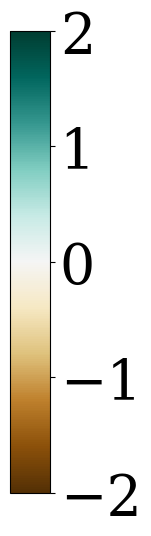

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Define o tamanho e o estilo da fonte
font_size = 40
font_family = 'serif'

# Cria uma figura e um eixo auxiliar
fig, ax = plt.subplots(figsize=(1, 6))
fig.subplots_adjust(left=0.5)

# Cria um objeto ScalarMappable com o mapa de cores BrBG
cmap = mpl.cm.BrBG
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

# Ajusta as configurações da fonte para a barra de cores
cb1.ax.tick_params(labelsize=font_size)
plt.setp(cb1.ax.get_yticklabels(), family=font_family)
fig.savefig("../results/realistic/figures/heatmap/colorbar_brbr.pdf", bbox_inches='tight')

plt.show()


ic| u_method: 'FGSM', model_name: 'mlp'


baseline


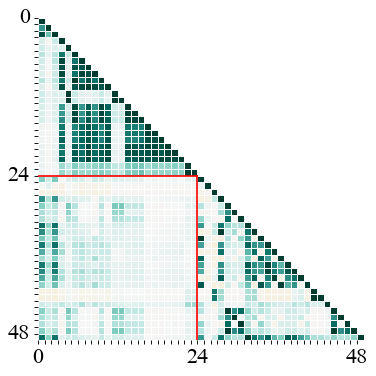

feasible


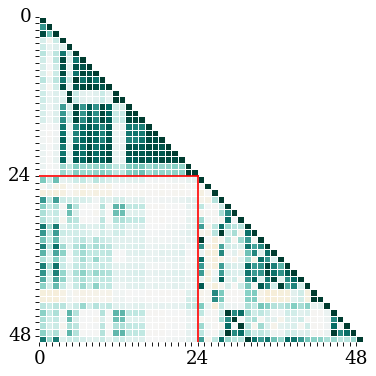

unfeasible


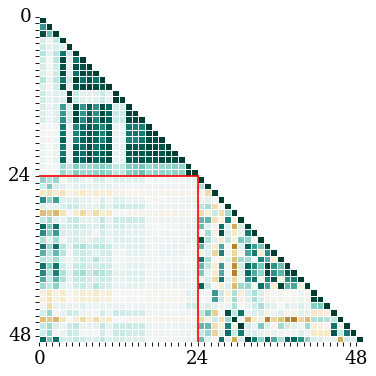

diff: feasible


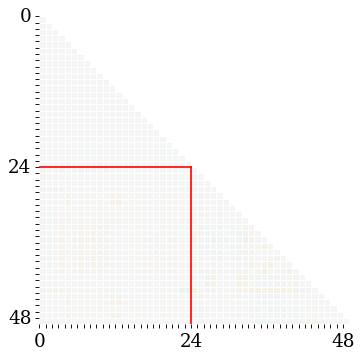

diff: unfeasible


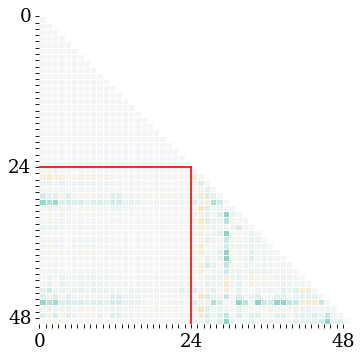

ic| u_method: 'FGSM', model_name: 'td'


baseline


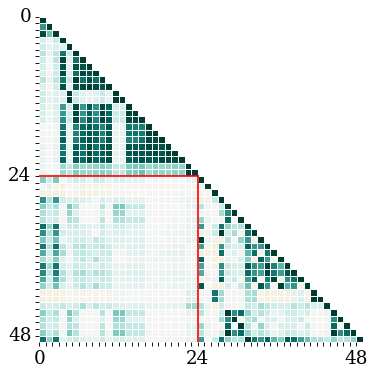

feasible


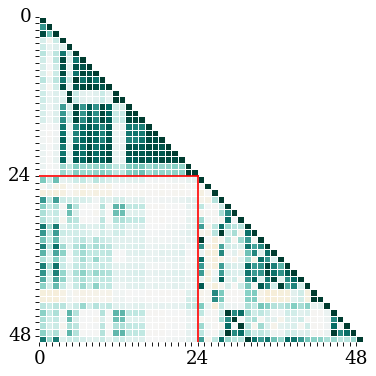

unfeasible


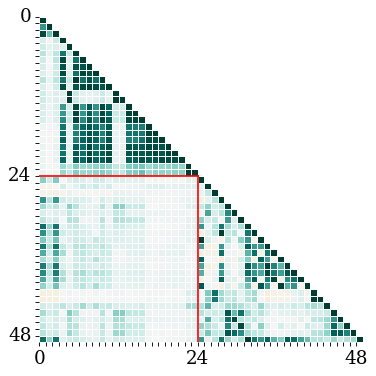

diff: feasible


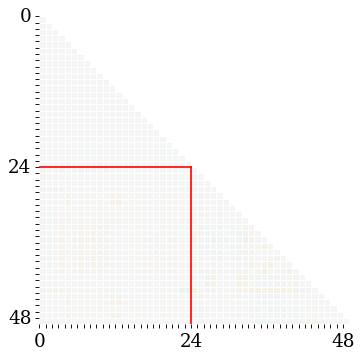

diff: unfeasible


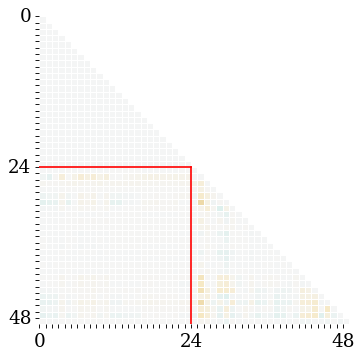

ic| u_method: 'PGD', model_name: 'mlp'


baseline


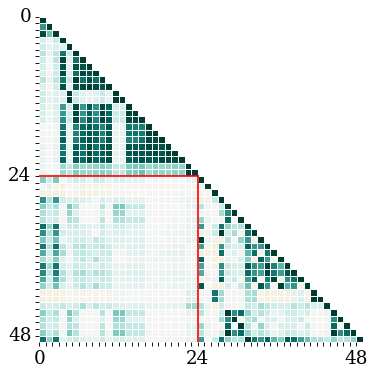

feasible


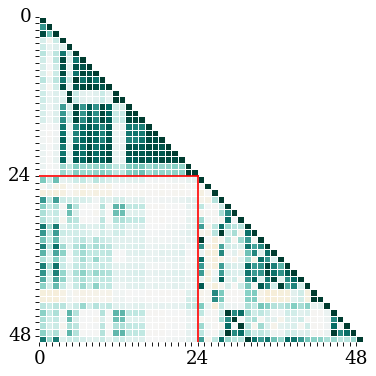

unfeasible


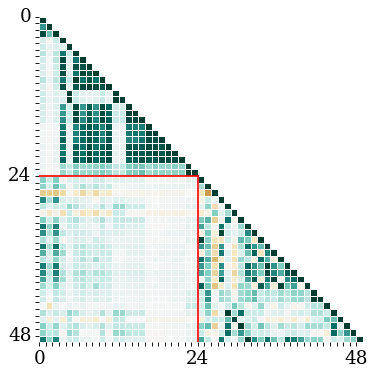

diff: feasible


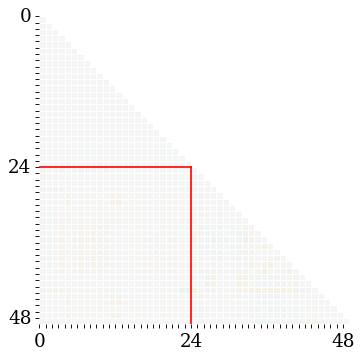

diff: unfeasible


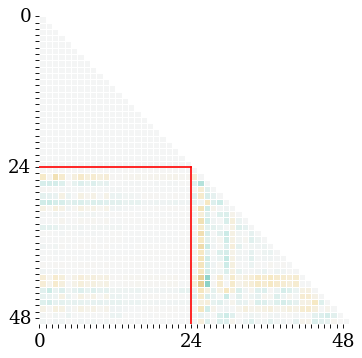

ic| u_method: 'PGD', model_name: 'td'


baseline


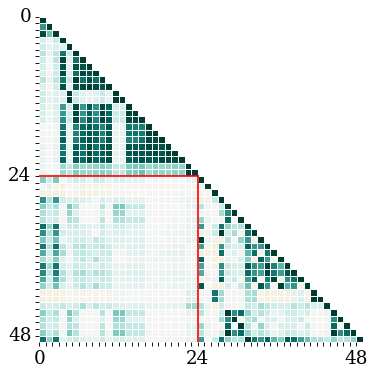

feasible


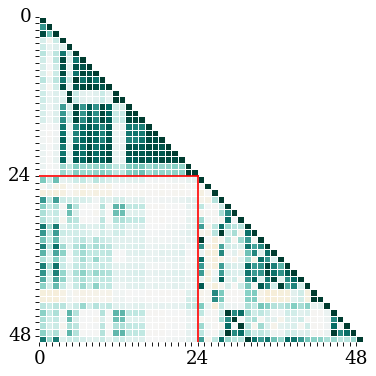

unfeasible


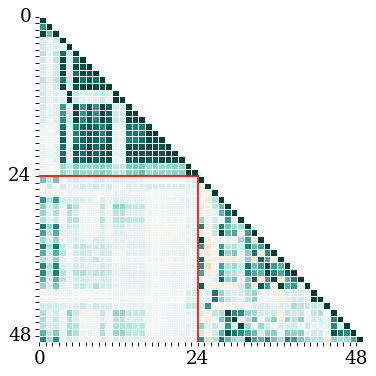

diff: feasible


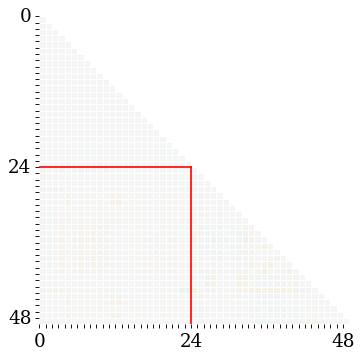

diff: unfeasible


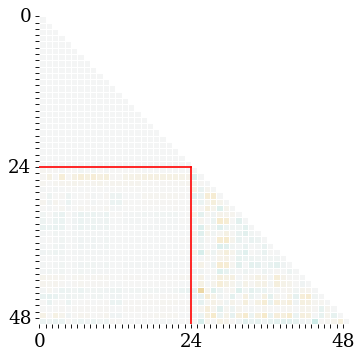

In [39]:
for u_method in ['FGSM', 'PGD']:
    for model_name in ['mlp', 'td']:
        ic(u_method, model_name)
        save_heatmap_to_pdf(data_loader=unsw_nb15, nw_attack='DoS', r_factor=100, u_factor=0.1, perturbation_based='volume', u_method=u_method, model_name=model_name, sorted_features=sorted_features, line_position=24, save=False, figsize=(5, 5), cmap='BrBG', font_size=16.5, show_colorbar=False, dpi=80)

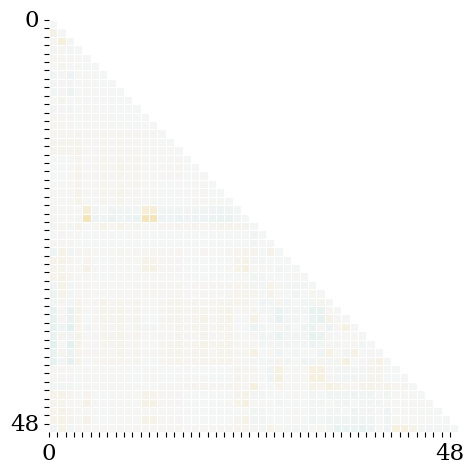

In [40]:
plot_corr_diff(data_loader=unsw_nb15, nw_attack='DoS', r_factor=100, u_factor=0.1, perturbation_based='time_volume', u_method='PGD', model_name='td', sorted_features=sorted_features, figsize=(5, 5), line_position=None, cmap='BrBG', font_size=15, show_colorbar=False)

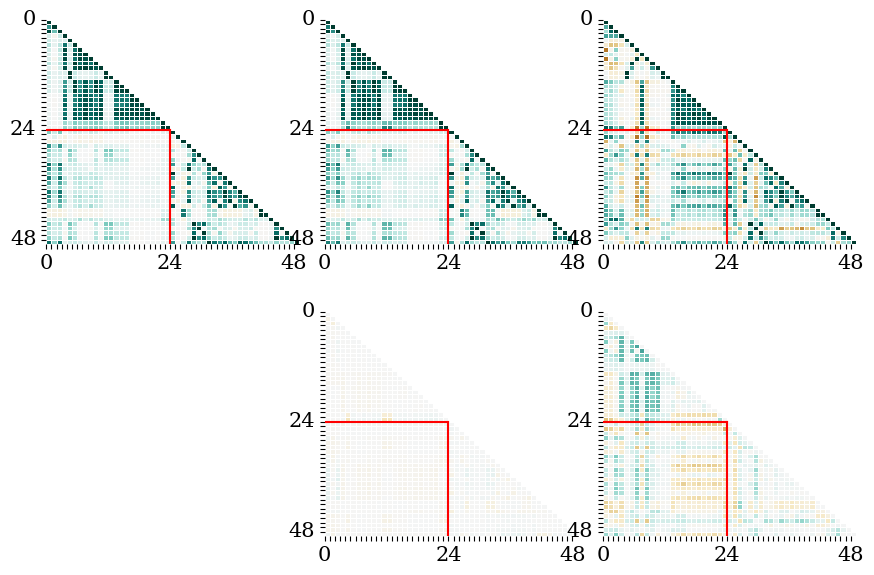

In [41]:
heatmap_comparison(data_loader=unsw_nb15, nw_attack='DoS', r_factor=100, u_factor=0.1, perturbation_based='time_volume', u_method='PGD', diff=True, model_name='mlp', sorted_features=sorted_features, line_position=24, cmap='BrBG', font_size=15, show_colorbar=False)

In [42]:
b, r, u = load_comparison_dfs(
    data_loader=unsw_nb15, 
    nw_attack='DoS', 
    r_factor=100, 
    u_factor=0.1, 
    perturbation_based='time_volume', 
    u_method='PGD', 
    model_name='td', 
    sorted_features=sorted_features
)

In [43]:
df_dist_u = compute_distance_corr(b, u)
# df_dist_u.sort_values('Difference', ascending=False)[:30] #585, 586, 587, 285, 282, 287, 283
df_dist_u.loc[~df_dist_u['Feature1'].isin(['bwdJitterMilliseconds'])].sort_values('Difference', ascending=False)[:30]


#287	idleMeanMilliseconds	interPacketTimeSecondsStdevBwd	0.781959	-0.307371	1.089330

Feature1                        Feature2  \
546         interPacketTimeSecondsMax    interPacketTimeSecondsMaxFwd   
437  interPacketTimeMillisecondsStdev       interPacketTimeSecondsMax   
648        interPacketTimeSecondsMean   interPacketTimeSecondsMeanFwd   
445  interPacketTimeMillisecondsStdev  interPacketTimeSecondsStdevBwd   
549         interPacketTimeSecondsMax   interPacketTimeSecondsMeanFwd   
368       interPacketTimeMilliseconds  interPacketTimeSecondsStdevBwd   
360       interPacketTimeMilliseconds       interPacketTimeSecondsMax   
585      interPacketTimeSecondsMaxFwd     interPacketTimeSecondsStdev   
279              idleMeanMilliseconds       interPacketTimeSecondsMax   
443  interPacketTimeMillisecondsStdev     interPacketTimeSecondsStdev   
287              idleMeanMilliseconds  interPacketTimeSecondsStdevBwd   
681     interPacketTimeSecondsMeanFwd     interPacketTimeSecondsStdev   
683     interPacketTimeSecondsMeanFwd  interPacketTimeSecondsStdevBwd   
587      interPacketTimeSecondsMaxFwd  interPacketTimeSecondsStdevBwd   
315               idleStdMilliseconds     interPacketTimeMilliseconds   
273              idleMeanMilliseconds             idleStdMilliseconds   
1           activeTimeMaxMilliseconds       activeTimeStdMilliseconds   
366       interPacketTimeMilliseconds     interPacketTimeSecondsStdev   
282              idleMeanMilliseconds      interPacketTimeSecondsMean   
399    interPacketTimeMillisecondsMax       interPacketTimeSecondsMax   
285              idleMeanMilliseconds     interPacketTimeSecondsStdev   
440  interPacketTimeMillisecondsStdev      interPacketTimeSecondsMean   
363       interPacketTimeMilliseconds      interPacketTimeSecondsMean   
680     interPacketTimeSecondsMeanFwd   interPacketTimeSecondsMeanBwd   
367       interPacketTimeMilliseconds  interPacketTimeSecondsStdevFwd   
682     interPacketTimeSecondsMeanFwd  interPacketTimeSecondsStdevFwd   
365       interPacketTimeMilliseconds   interPacketTimeSecondsMeanBwd   
286              idleMeanMilliseconds  interPacketTimeSecondsStdevFwd   
405    interPacketTimeMillisecondsMax     interPacketTimeSecondsStdev   
284              idleMeanMilliseconds   interPacketTimeSecondsMeanBwd   

       Corr_1    Corr_2  Difference  
546  0.976123 -0.618989    1.595112  
437  0.797365 -0.660913    1.458279  
648  0.956654 -0.409761    1.366415  
445  0.911657 -0.447487    1.359144  
549  0.731565 -0.626117    1.357682  
368  0.791511 -0.564554    1.356065  
360  0.619782 -0.720184    1.339966  
585  0.862783 -0.470878    1.333661  
279  0.603972 -0.729051    1.333023  
443  0.899399 -0.430025    1.329424  
287  0.781959 -0.546421    1.328380  
681  0.925045 -0.364139    1.289184  
683  0.868451 -0.410449    1.278900  
587  0.822617 -0.452080    1.274698  
315  0.895070 -0.378311    1.273381  
273  0.885005 -0.376131    1.261136  
1    0.926670 -0.287214    1.213884  
366  0.755954 -0.447528    1.203482  
282  0.775338 -0.415954    1.191292  
399  0.934579 -0.254366    1.188945  
285  0.751229 -0.433656    1.184885  
440  0.849829 -0.333623    1.183452  
363  0.761475 -0.411504    1.172978  
680  0.907561 -0.239242    1.146803  
367  0.786094 -0.360110    1.146204  
682  0.942881 -0.202116    1.144997  
365  0.795097 -0.341917    1.137014  
286  0.757263 -0.358010    1.115273  
405  0.825528 -0.288472    1.113999  
284  0.796744 -0.309869    1.106613

In [44]:
df_dist_u = compute_distance_corr(b, r)
df_dist_u.sort_values('Difference', ascending=False)[:10]

Feature1                      Feature2  \
484     interPacketTimeMillisecondsSum  interPacketTimeSecondsSumBwd   
204           flowDurationMilliseconds  interPacketTimeSecondsSumBwd   
520  interPacketTimeMillisecondsSumFwd  interPacketTimeSecondsSumBwd   
203           flowDurationMilliseconds  interPacketTimeSecondsSumFwd   
483     interPacketTimeMillisecondsSum  interPacketTimeSecondsSumFwd   
519  interPacketTimeMillisecondsSumFwd  interPacketTimeSecondsSumFwd   
48          activeTimeMeanMilliseconds     activeTimeStdMilliseconds   
128          activeTimeStdMilliseconds         ipTotalLengthStdevBwd   
894                        bwdBytesAvg       minimumIpTotalLengthBwd   
37           activeTimeMaxMilliseconds          maximumIpTotalLength   

       Corr_1    Corr_2  Difference  
484  0.225847  0.674678    0.448832  
204  0.225128  0.673727    0.448599  
520  0.225367  0.673940    0.448573  
203  0.216010  0.458548    0.242538  
483  0.216714  0.459225    0.242511  
519  0.216237  0.458567    0.242330  
48   0.452464  0.648407    0.195943  
128  0.392206  0.216834    0.175372  
894  0.258362  0.433355    0.174993  
37   0.655115  0.484832    0.170283

In [45]:
noise = get_perturbations(unsw_nb15, adv=mlp_adv_time_volume_dos)
df_dist_noise =compute_distance_corr(b, noise)
df_dist_noise.sort_values('Difference', ascending=False)[:10]

Feature1                        Feature2  \
651         interPacketTimeSecondsMean  interPacketTimeSecondsStdevFwd   
440   interPacketTimeMillisecondsStdev      interPacketTimeSecondsMean   
1168                   octetTotalCount                       packetLen   
1070              ipTotalLengthMeanBwd                    packetLenAvg   
949                        fwdBytesAvg            ipTotalLengthMeanFwd   
1084                ipTotalLengthStdev                    packetLenAvg   
965                        fwdBytesAvg                    packetLenAvg   
952                        fwdBytesAvg           ipTotalLengthStdevFwd   
140          activeTimeStdMilliseconds                    packetLenAvg   
956                        fwdBytesAvg         maximumIpTotalLengthFwd   

        Corr_1    Corr_2  Difference  
651   0.896755 -0.647790    1.544545  
440   0.849829 -0.635345    1.485174  
1168  0.999957 -0.443185    1.443143  
1070  0.598202 -0.843001    1.441204  
949   0.999902 -0.435652    1.435554  
1084  0.803721 -0.626611    1.430332  
965   0.729048 -0.696212    1.425260  
952   0.759477 -0.620703    1.380180  
140   0.735576 -0.634168    1.369745  
956   0.833274 -0.529869    1.363143

In [46]:
df_dist_r = compute_distance_corr(b, r)
df_dist_r.sort_values('Difference', ascending=False)[:10]

Feature1                      Feature2  \
484     interPacketTimeMillisecondsSum  interPacketTimeSecondsSumBwd   
204           flowDurationMilliseconds  interPacketTimeSecondsSumBwd   
520  interPacketTimeMillisecondsSumFwd  interPacketTimeSecondsSumBwd   
203           flowDurationMilliseconds  interPacketTimeSecondsSumFwd   
483     interPacketTimeMillisecondsSum  interPacketTimeSecondsSumFwd   
519  interPacketTimeMillisecondsSumFwd  interPacketTimeSecondsSumFwd   
48          activeTimeMeanMilliseconds     activeTimeStdMilliseconds   
128          activeTimeStdMilliseconds         ipTotalLengthStdevBwd   
894                        bwdBytesAvg       minimumIpTotalLengthBwd   
37           activeTimeMaxMilliseconds          maximumIpTotalLength   

       Corr_1    Corr_2  Difference  
484  0.225847  0.674678    0.448832  
204  0.225128  0.673727    0.448599  
520  0.225367  0.673940    0.448573  
203  0.216010  0.458548    0.242538  
483  0.216714  0.459225    0.242511  
519  0.216237  0.458567    0.242330  
48   0.452464  0.648407    0.195943  
128  0.392206  0.216834    0.175372  
894  0.258362  0.433355    0.174993  
37   0.655115  0.484832    0.170283

ic| 'Baseline'


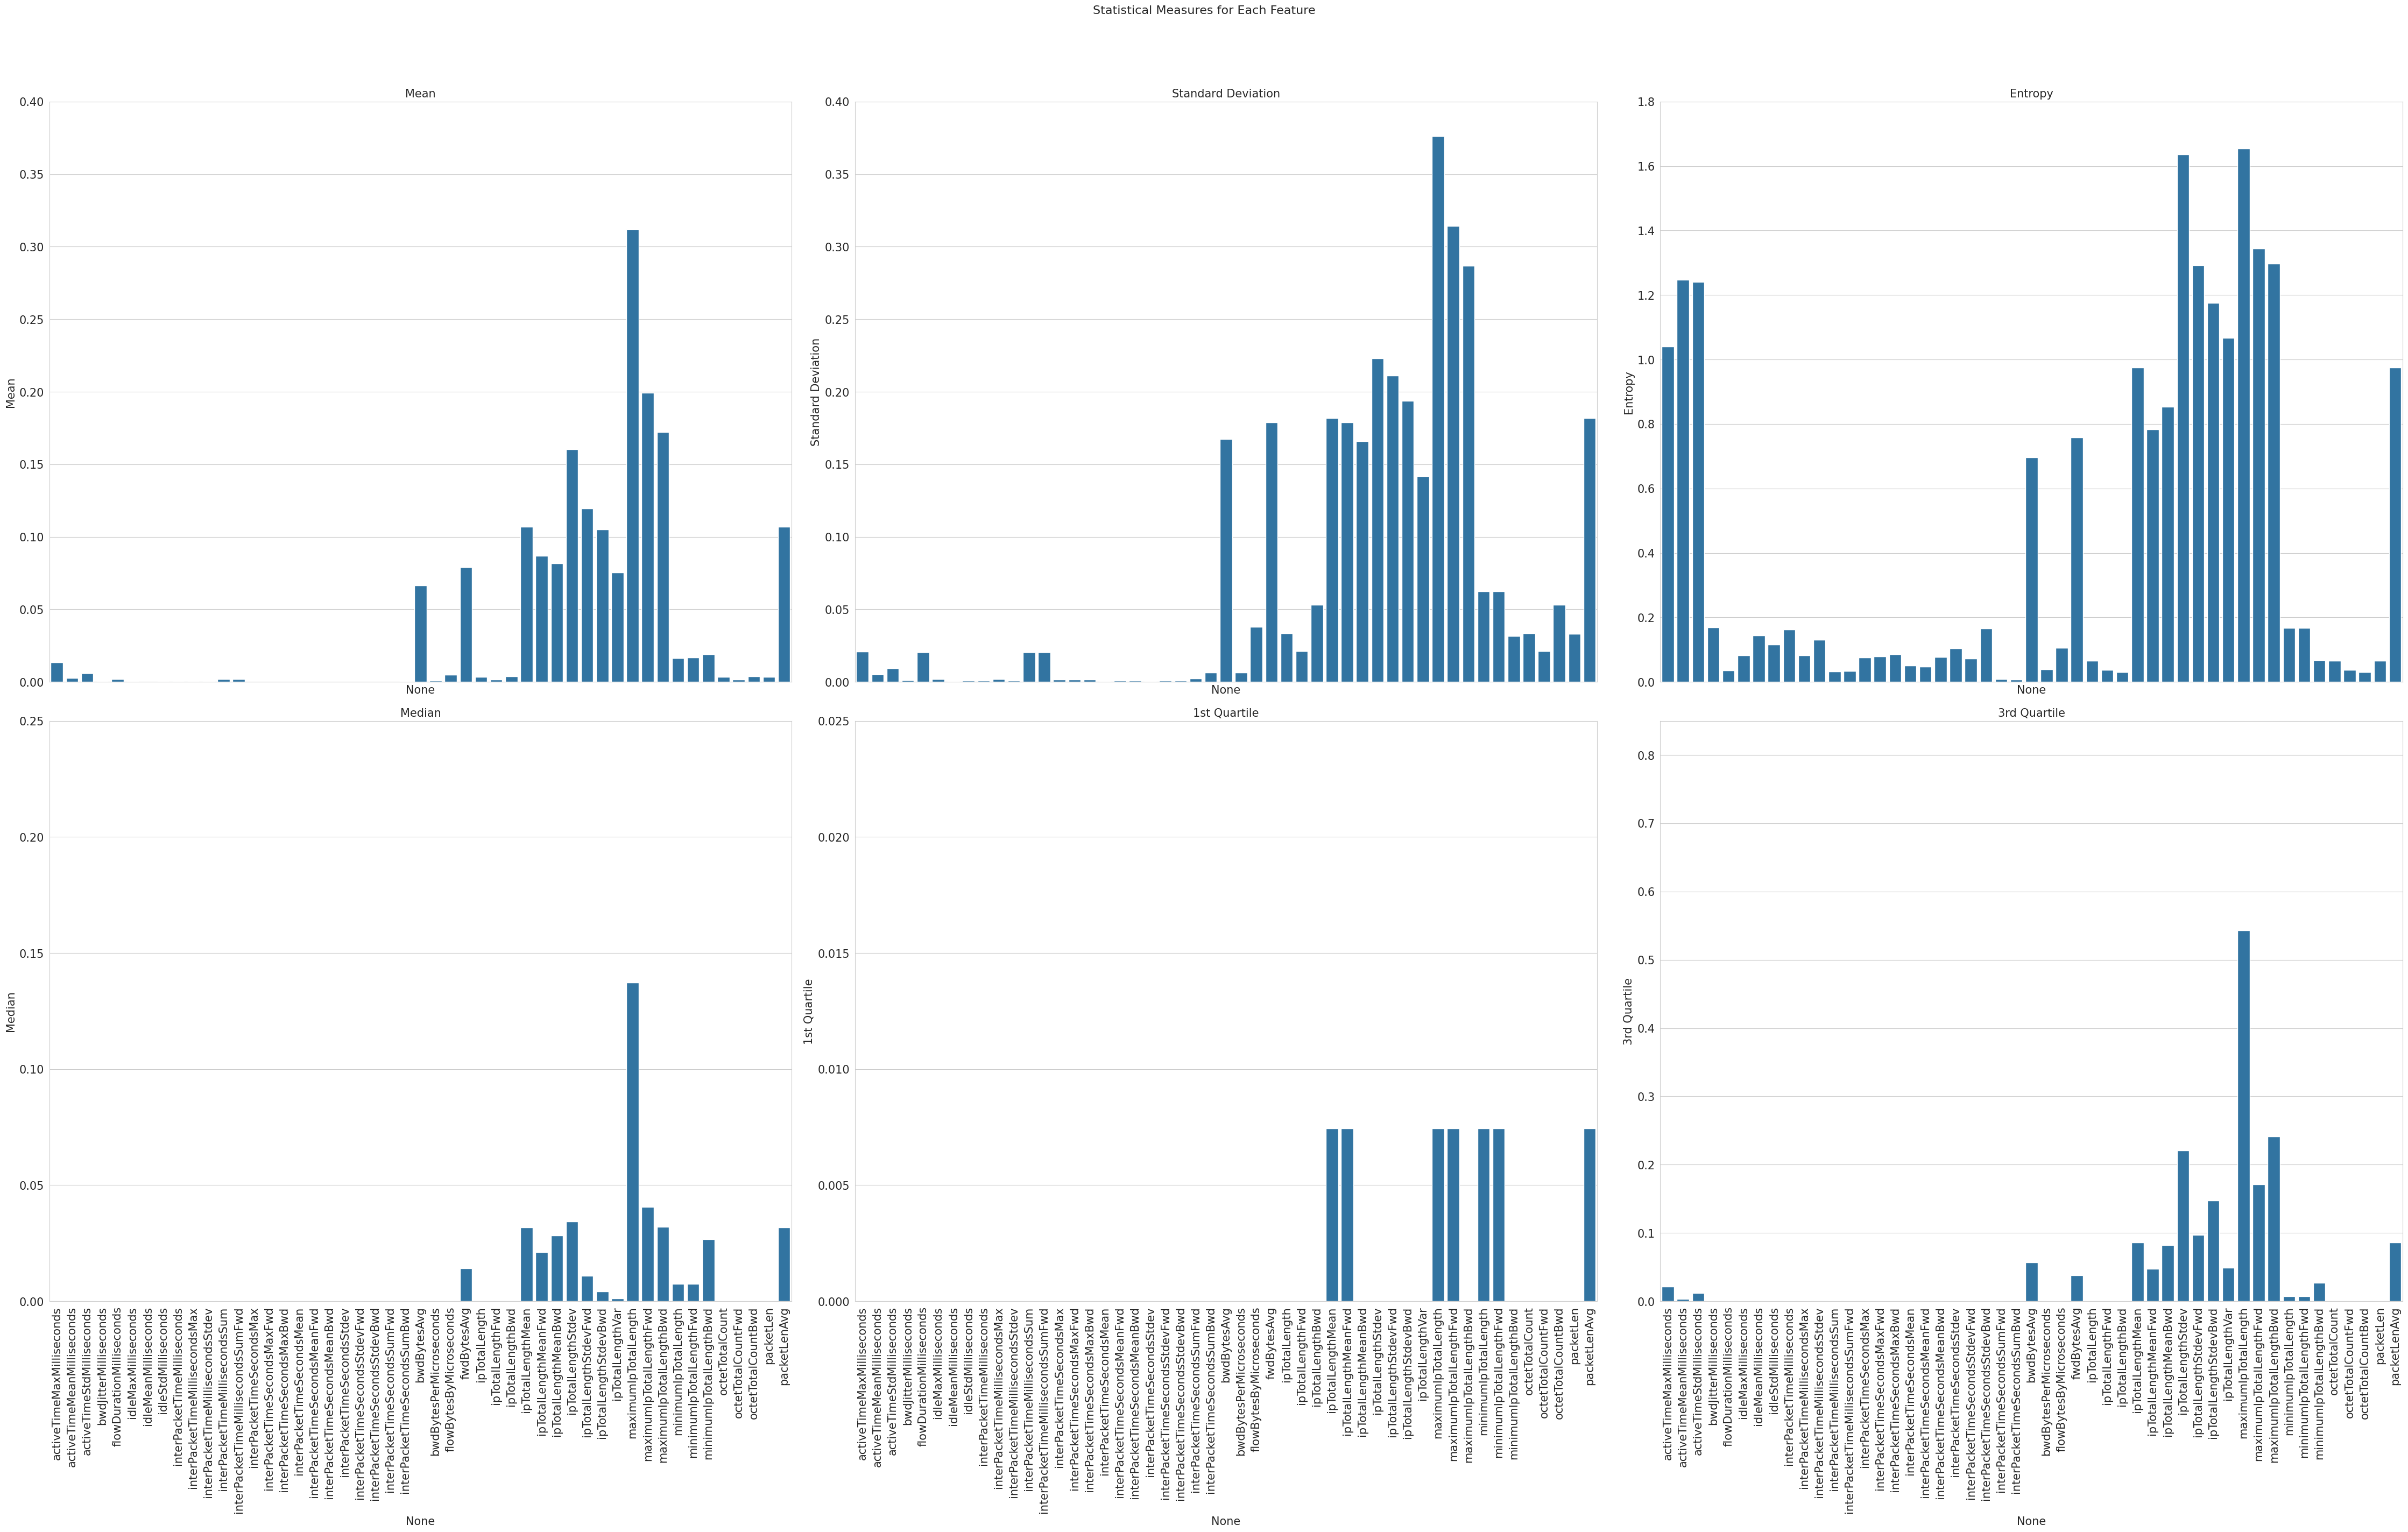

ic| 'Realistic'


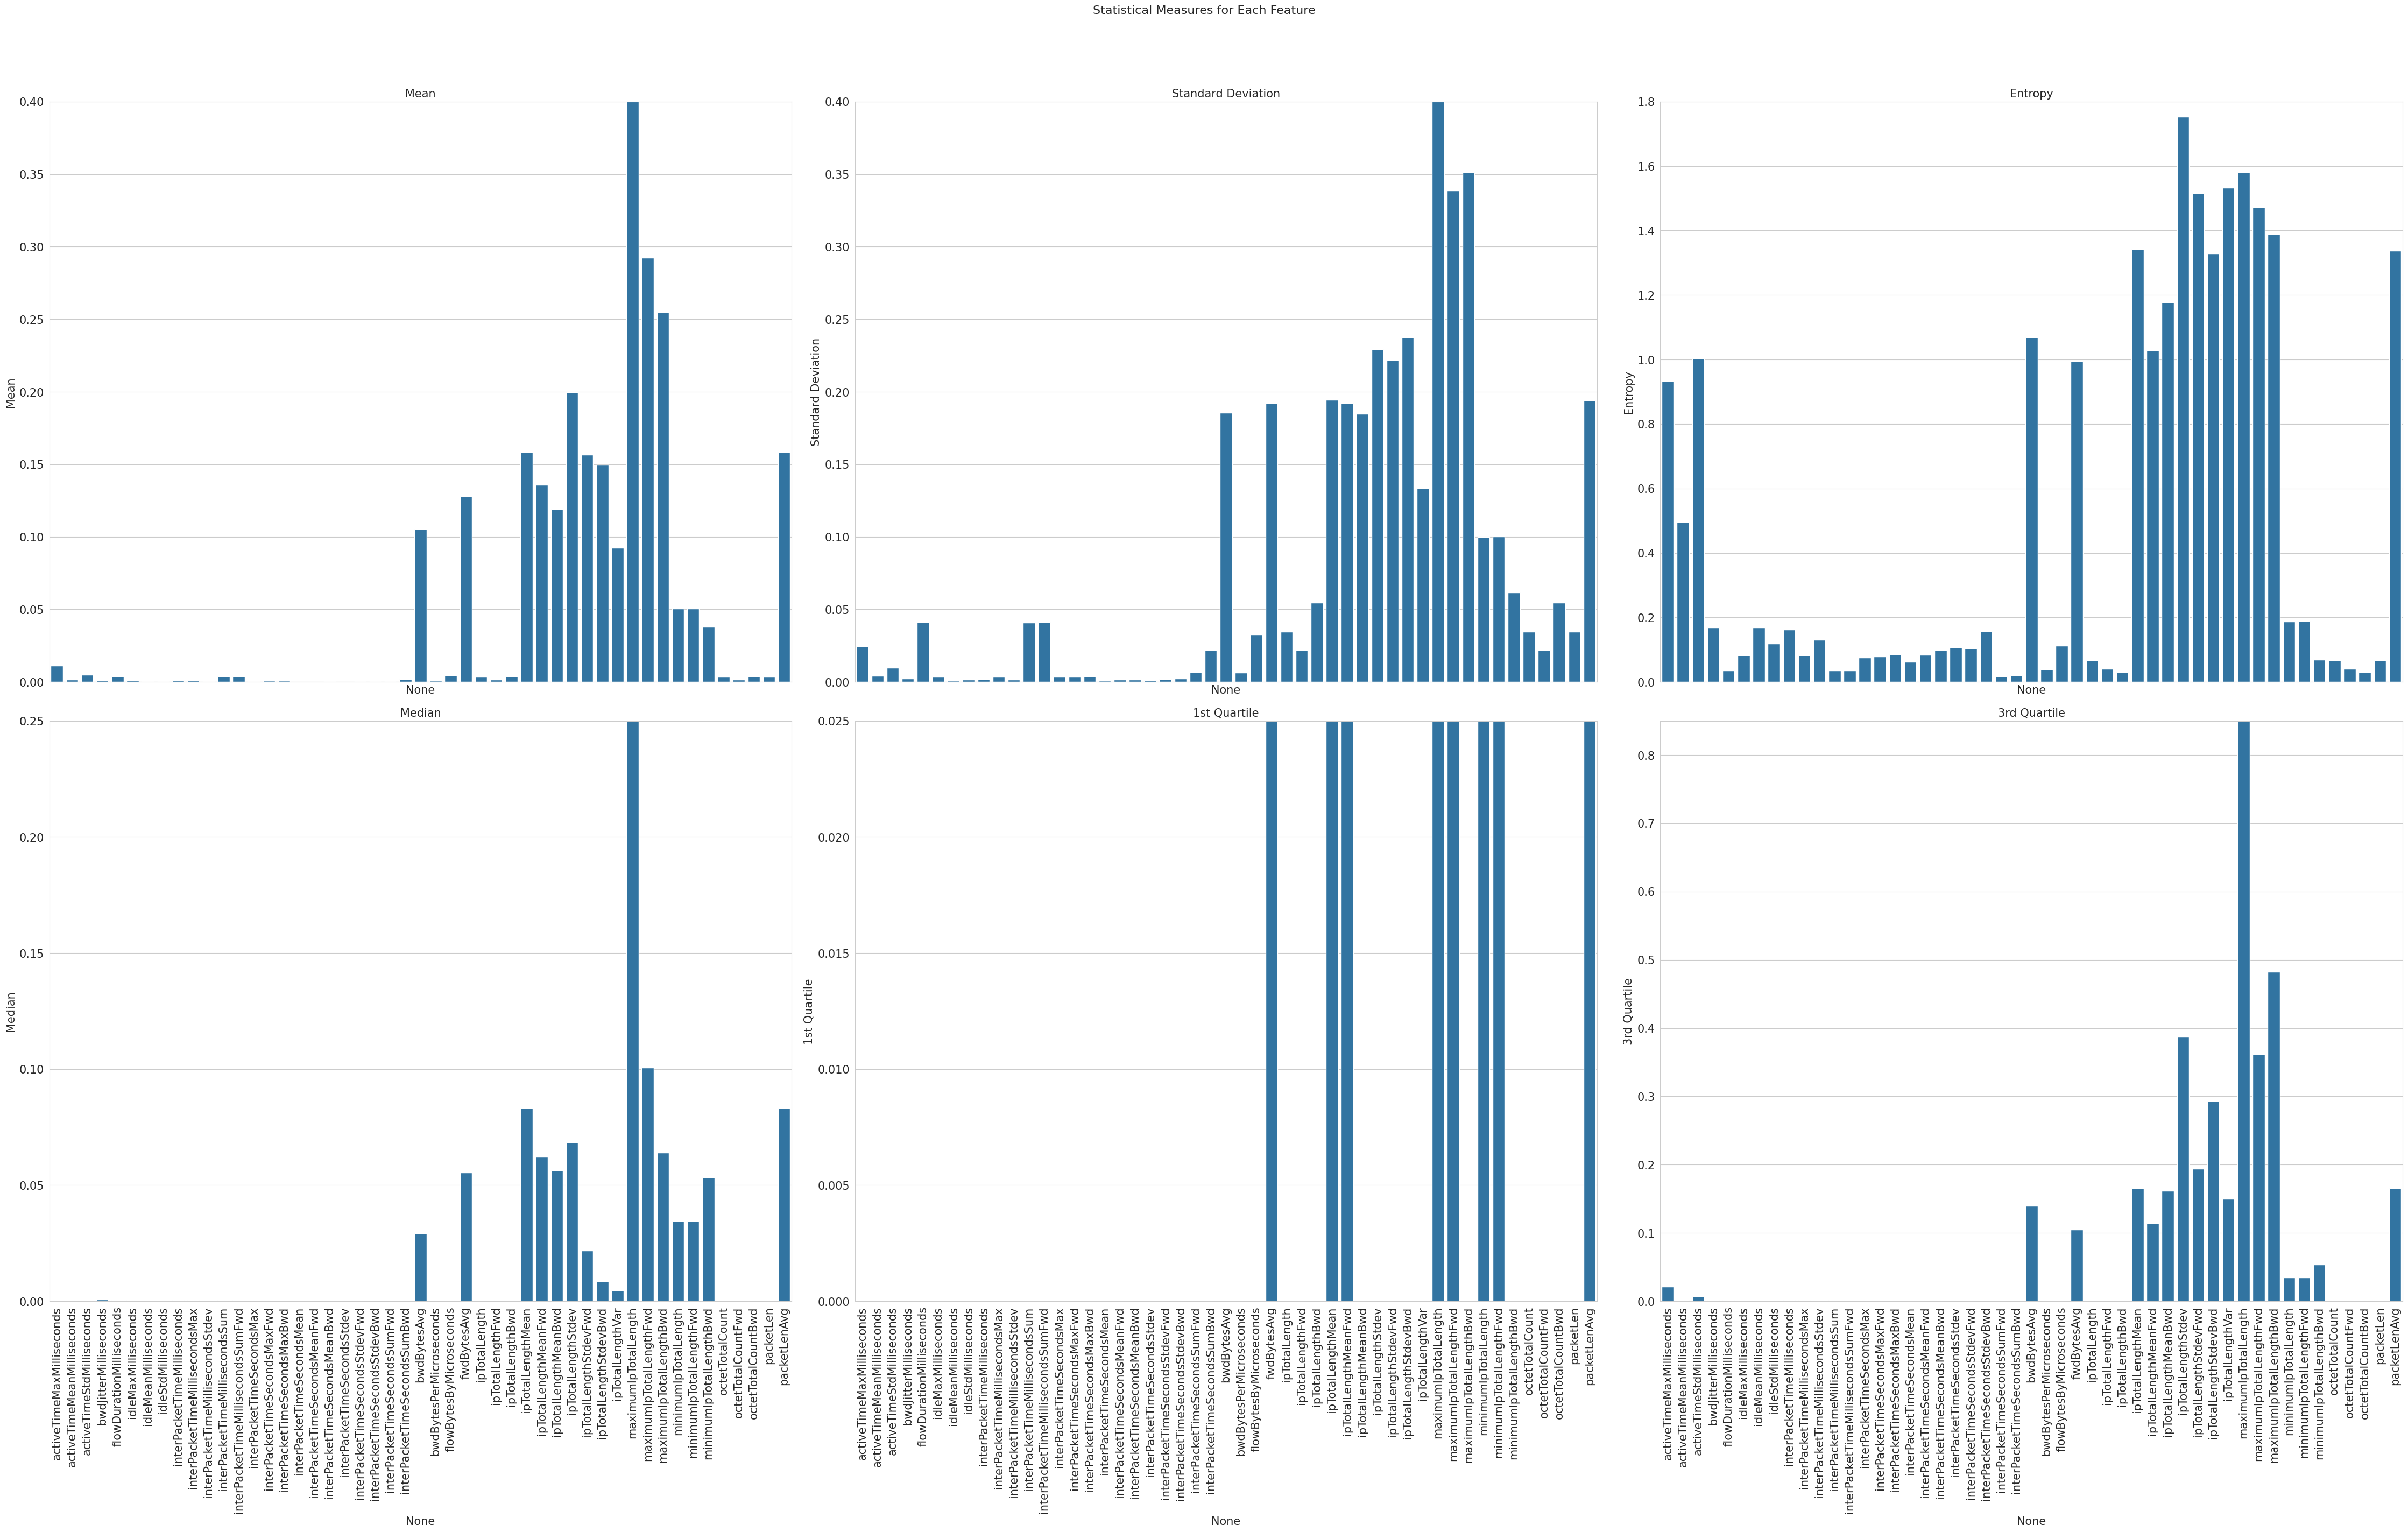

ic| 'Unrealistic'


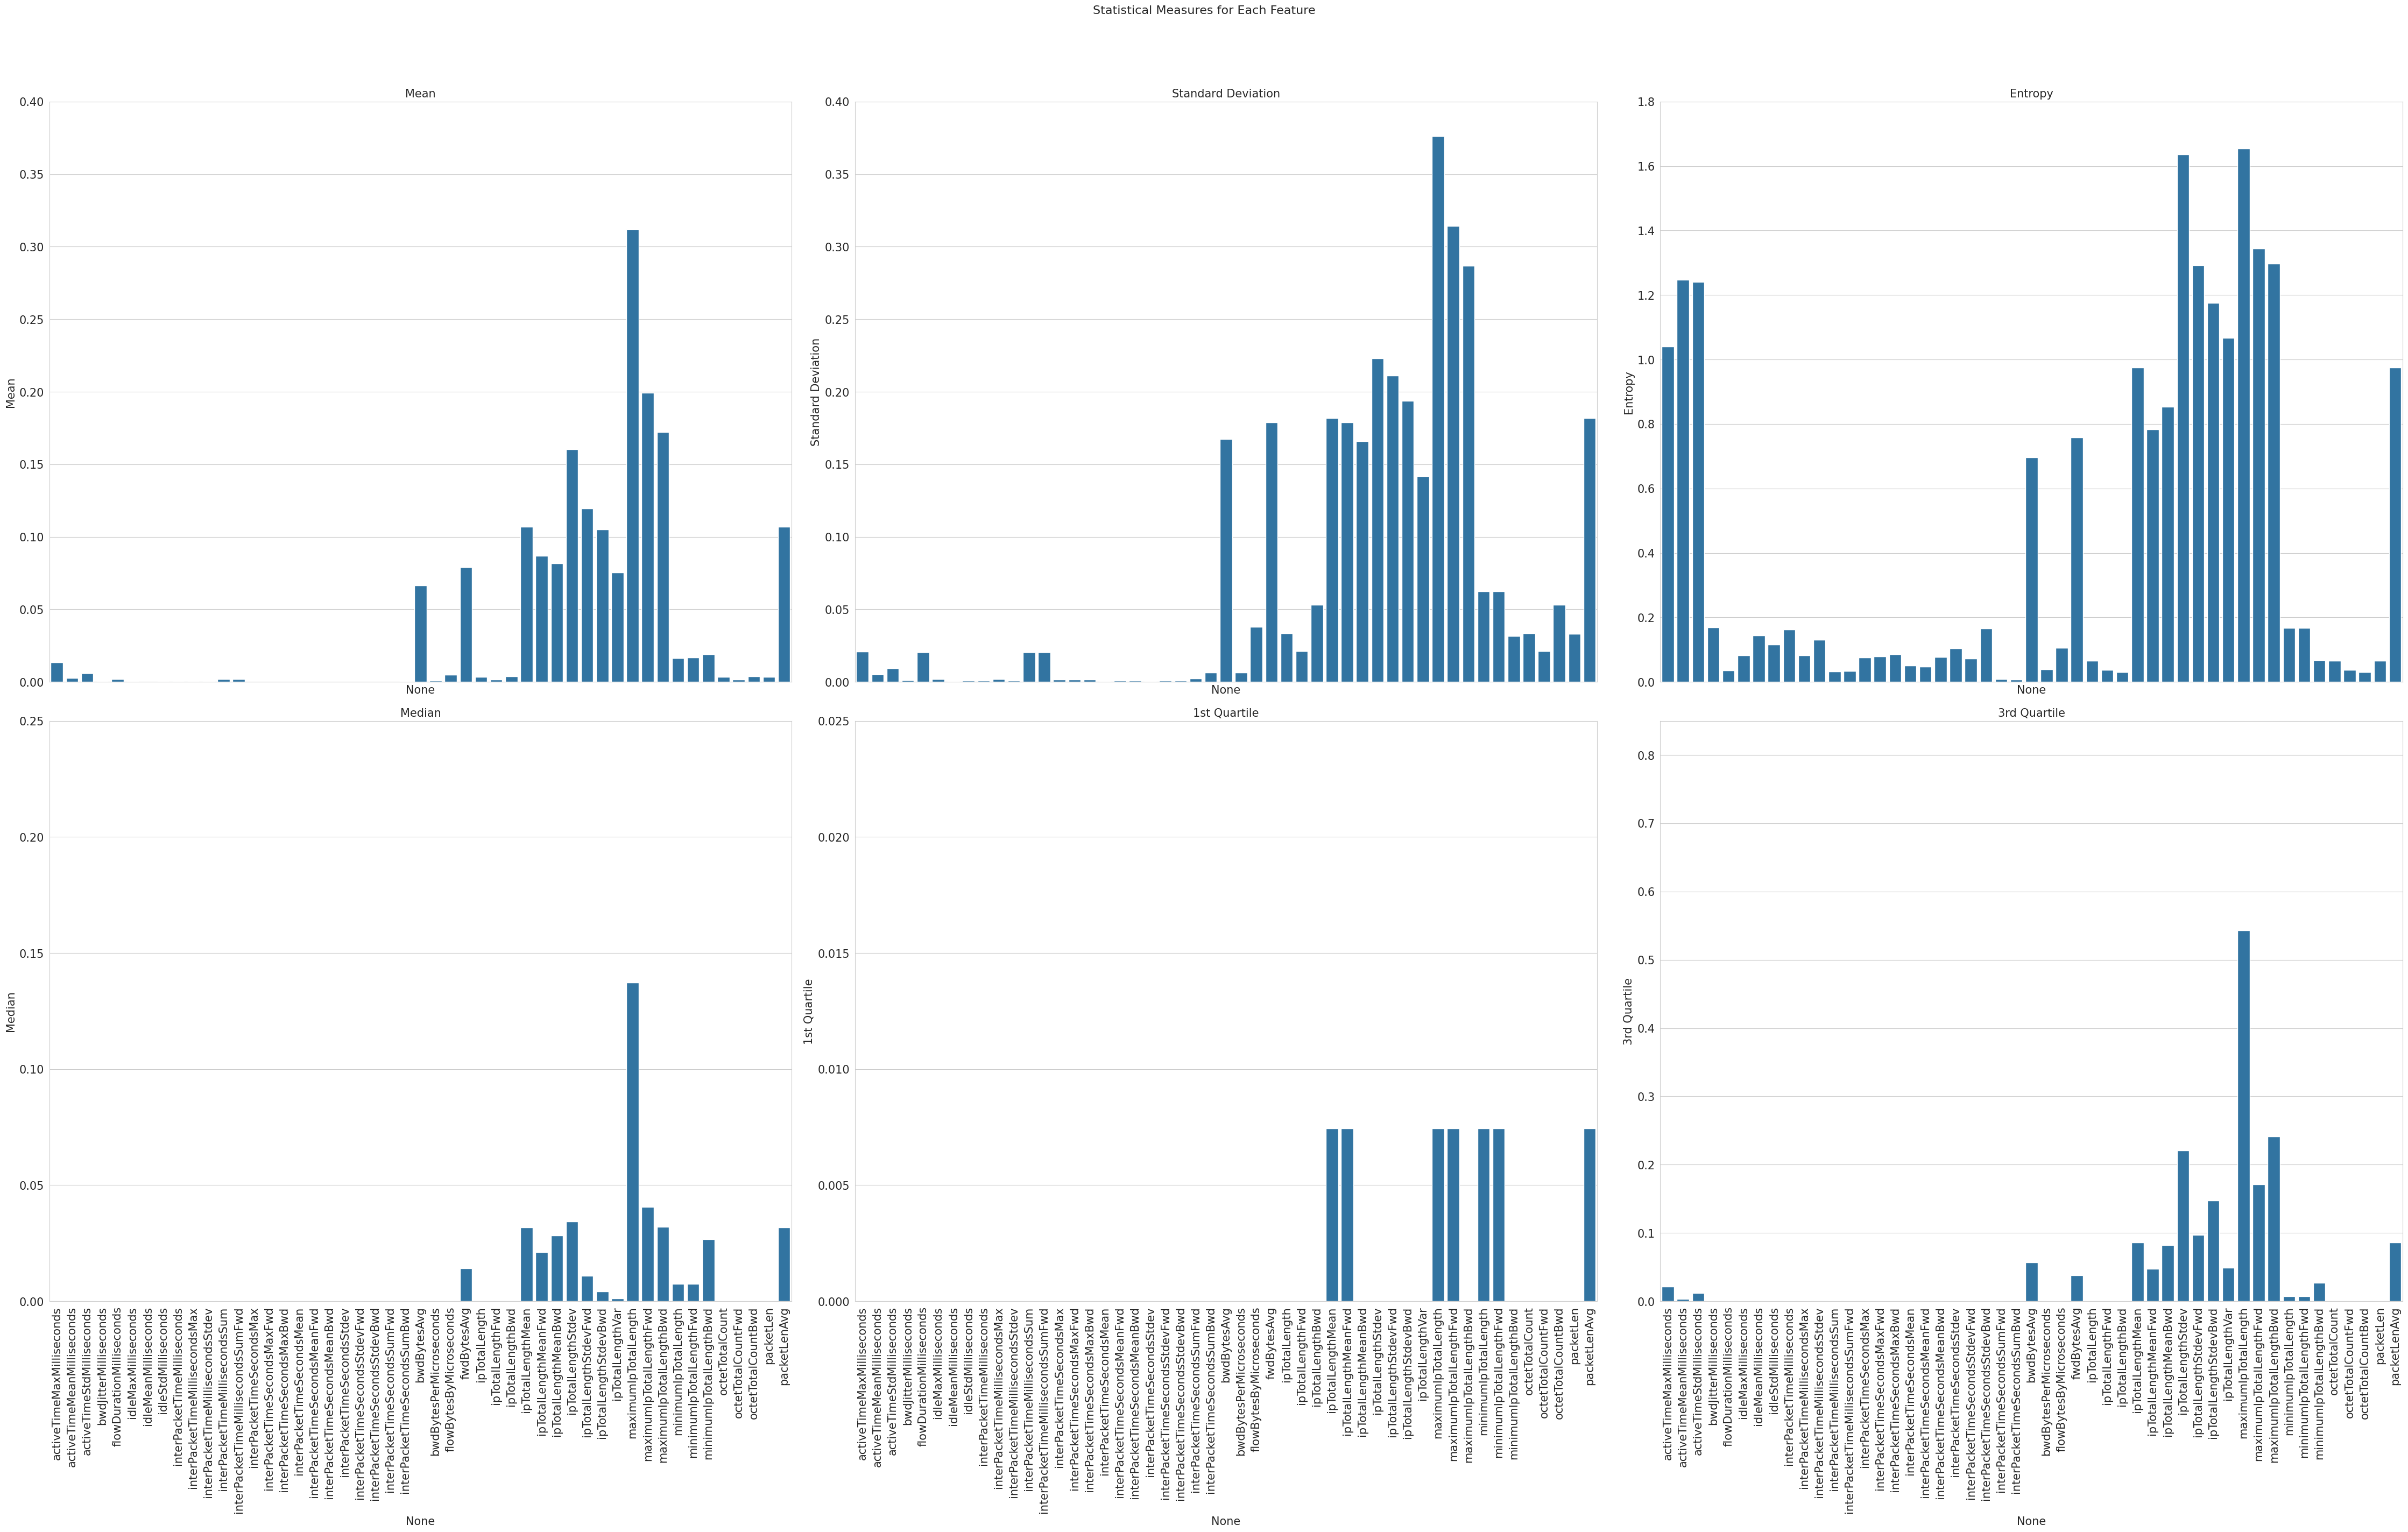

ic| 'Baseline - Realistic'


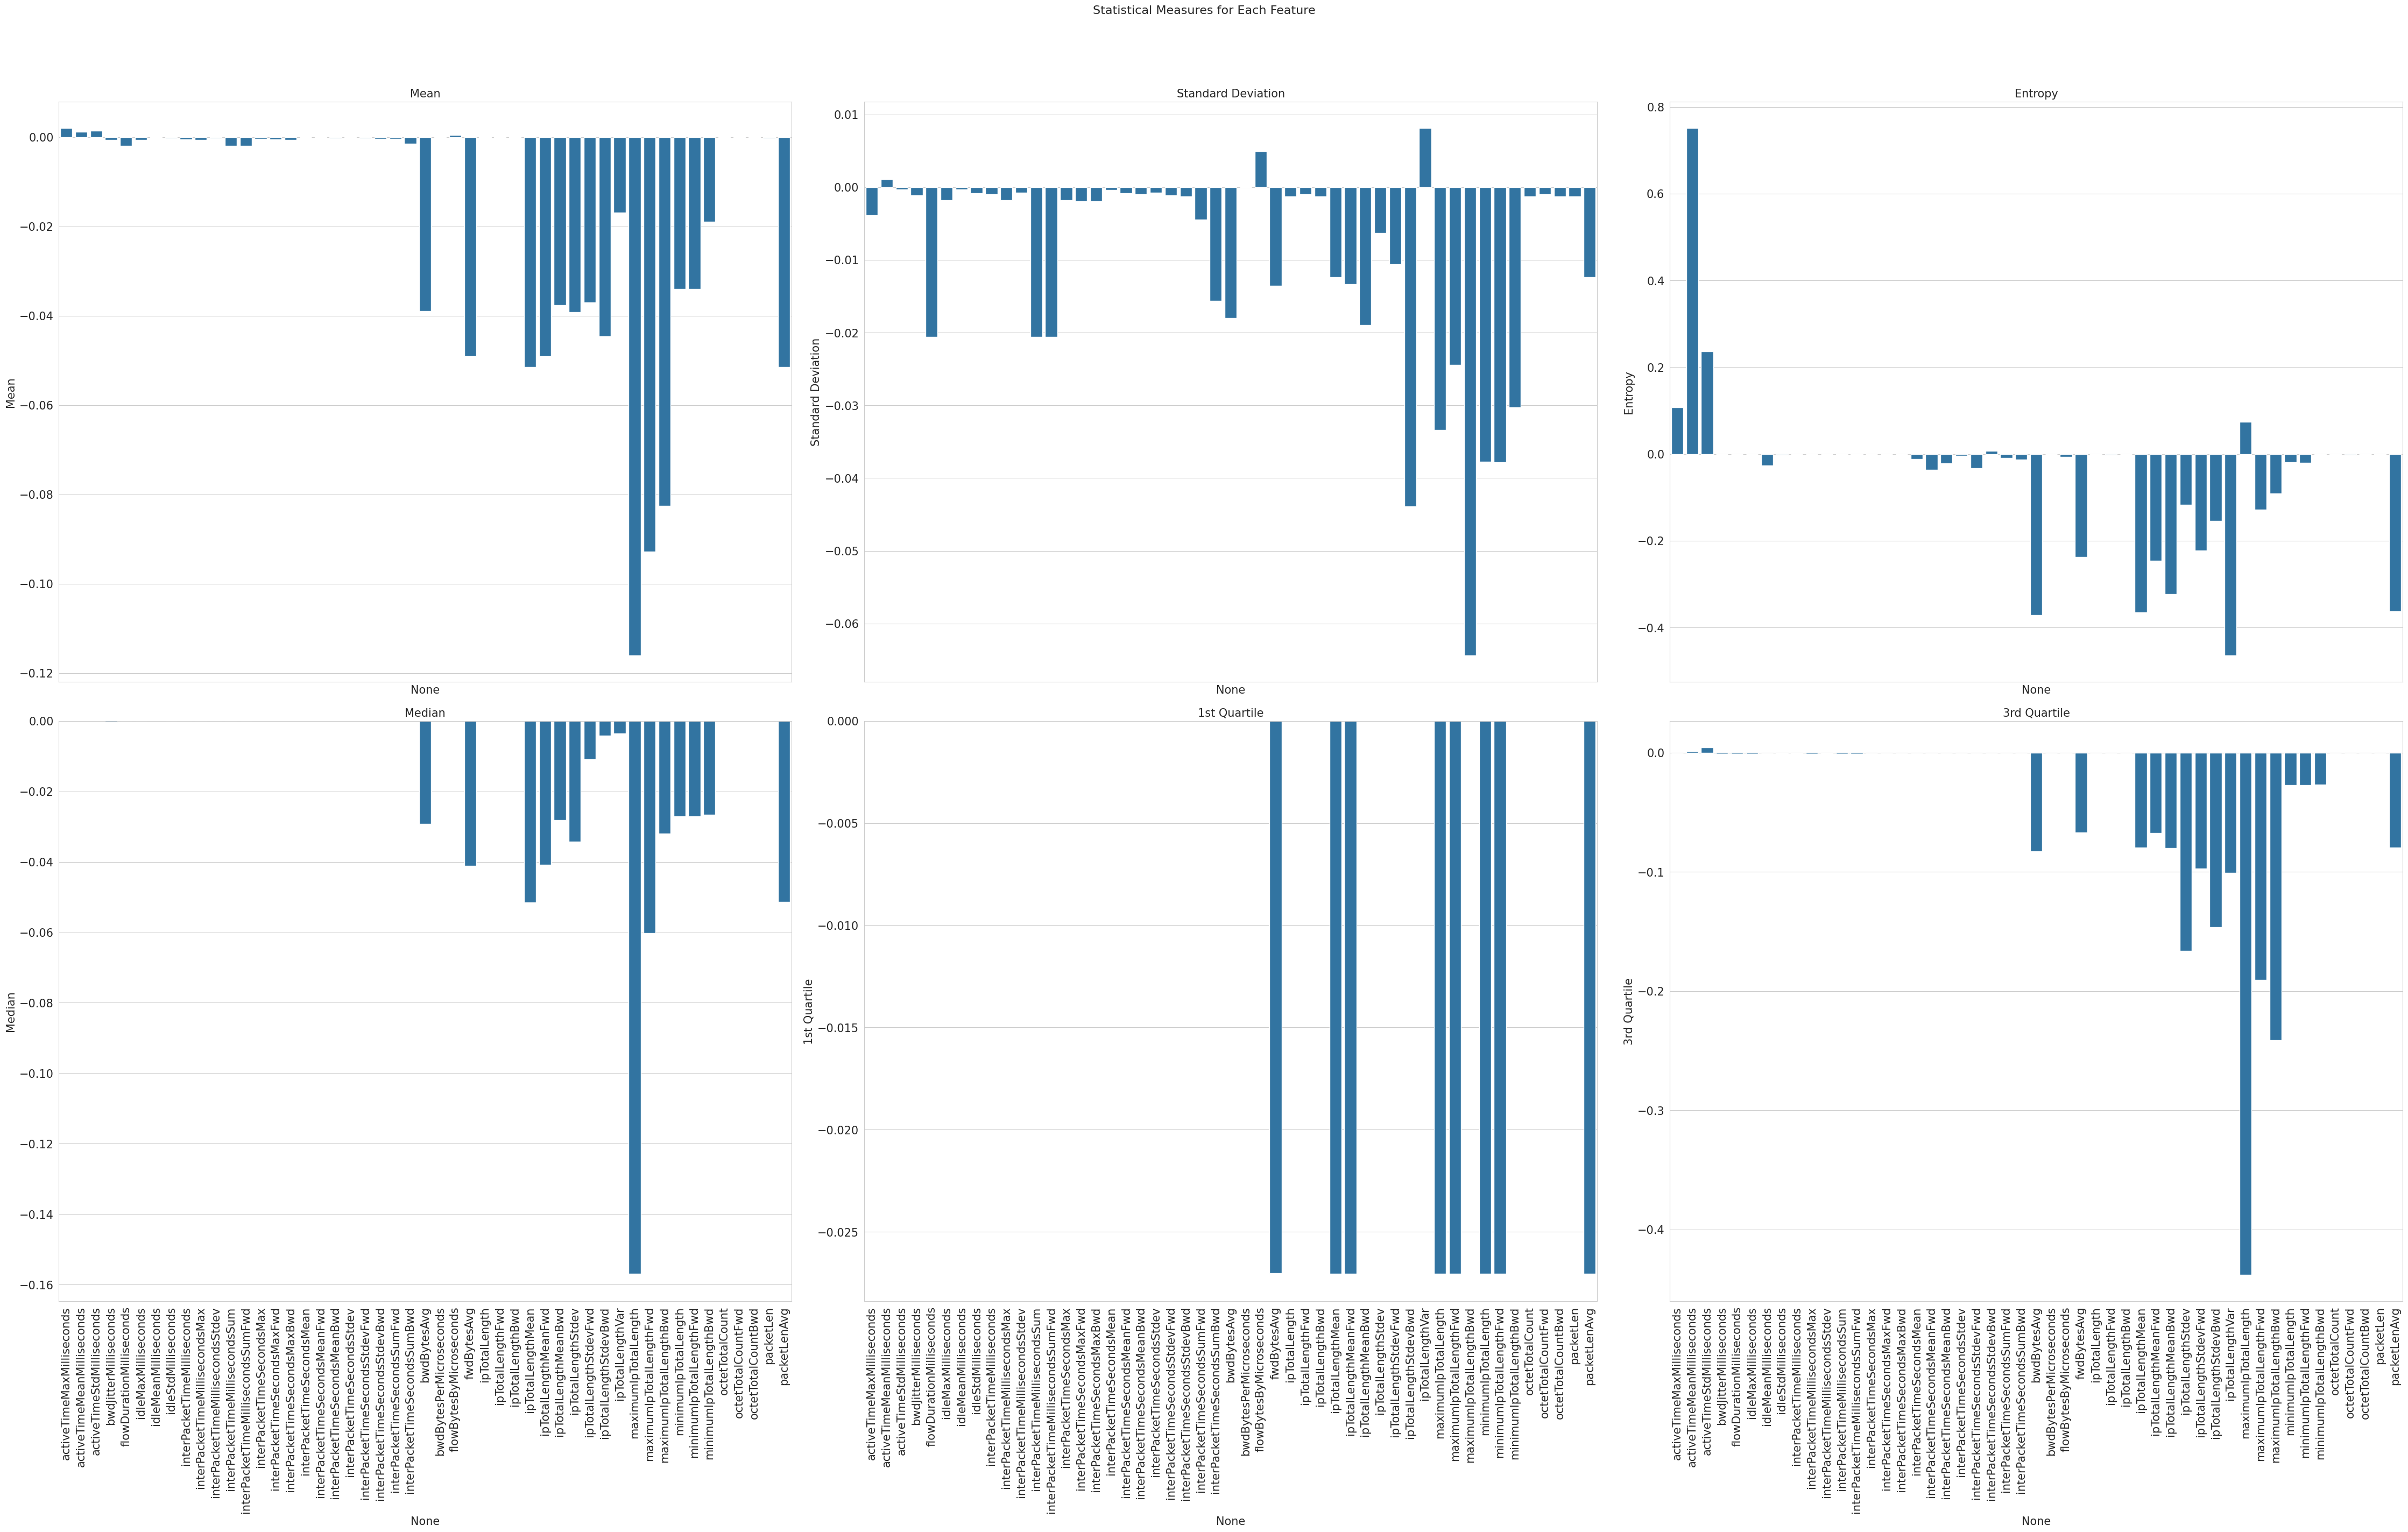

ic| 'Baseline - Unrealistic'


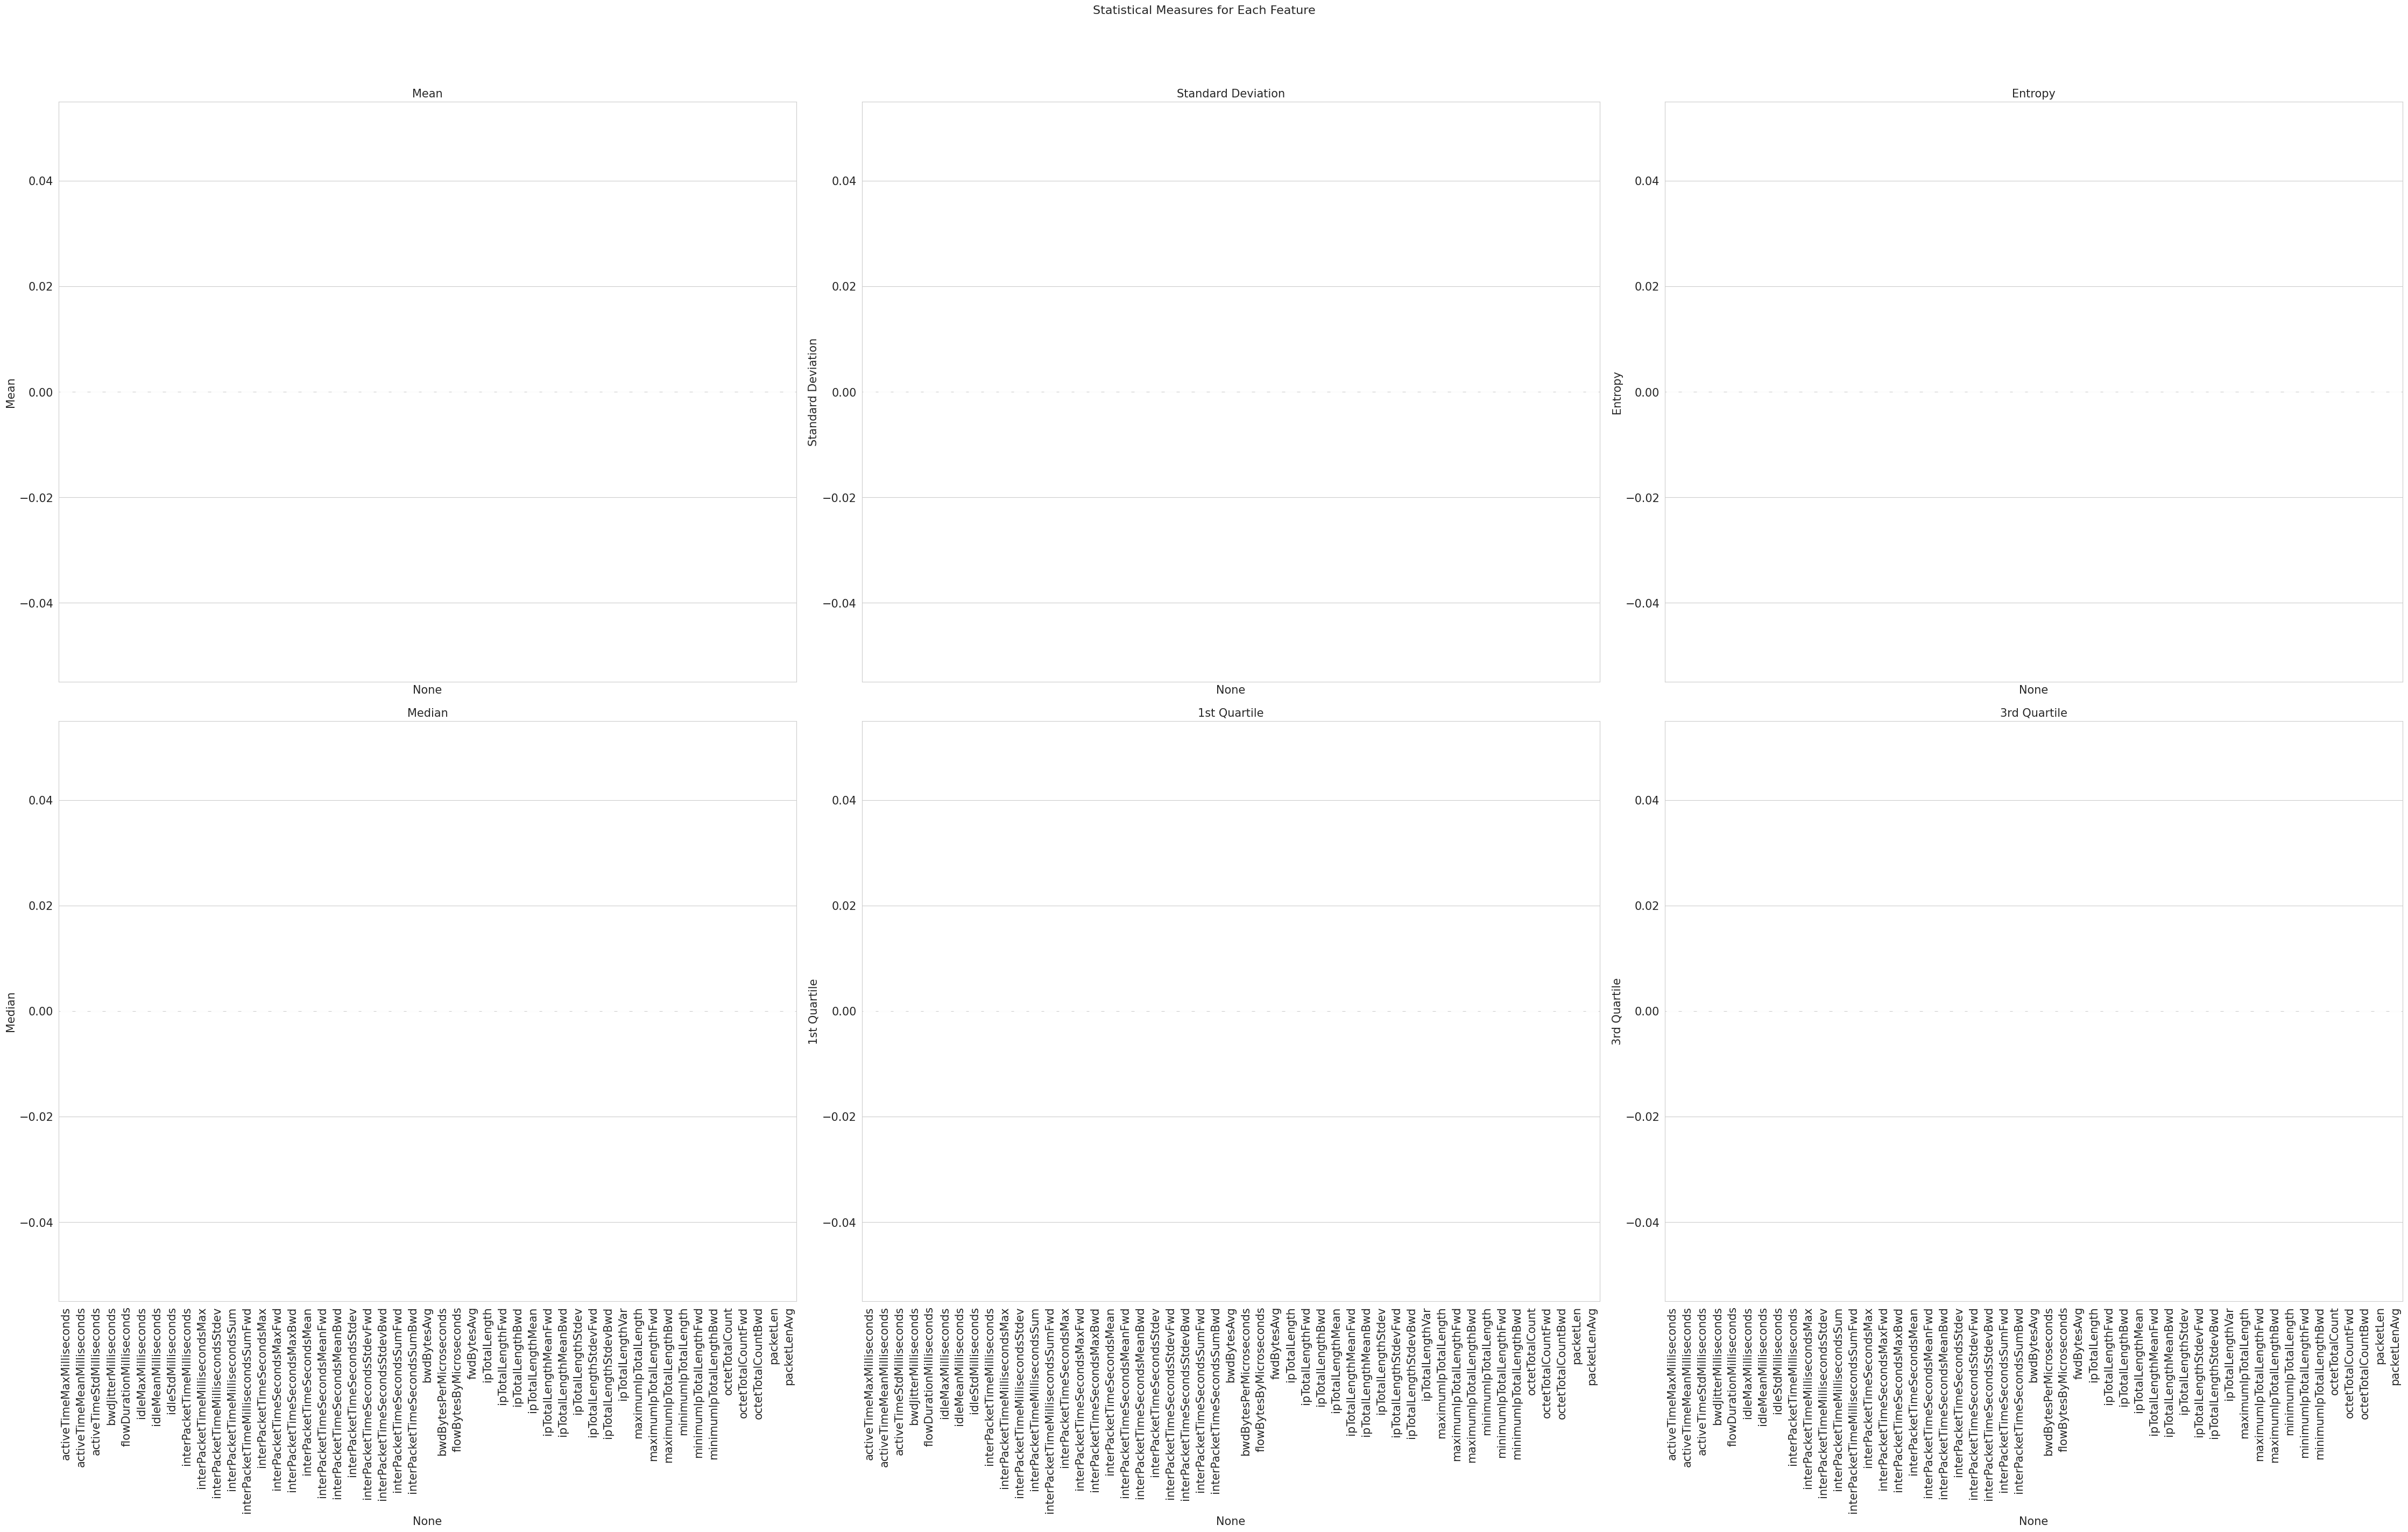

In [47]:
y_limits = [(0, 0.4), (0, 0.4), (0, 1.8), (0, .25), (0, 0.025), (0, 0.85)]
ic('Baseline')
statistics_b = calculate_statistics(b)
plot_statistics(statistics_b, y_limits)

ic('Realistic')
statistics_r = calculate_statistics(r)
plot_statistics(statistics_r, y_limits)

ic('Unrealistic')
statistics_u = calculate_statistics(b)
plot_statistics(statistics_u, y_limits)

ic('Baseline - Realistic')
plot_statistics(statistics_b - statistics_r)

ic('Baseline - Unrealistic')
plot_statistics(statistics_b - statistics_u)


# Understanding the Resilience of the models to Time-Based Evasion Techniques

In [48]:
# Calculate your data
# data = noise.mean().abs().sort_values()[::-1]

# # Define your custom x-axis values (this should have the same length as 'data')
# x_values = range(len(data))  # Example: numerical range

# # Create the plot
# plt.plot(x_values, data)

# # Customize the plot (e.g., labels, title)
# plt.xlabel('Features')
# plt.ylabel('Mean Perturbation')
# plt.title('Mean Noise Perturbation')

# # Show the plot
# plt.show()

In [49]:
unsw_nb15_no_norm = esp_utilities.DatasetLoader('unsw-nb15', scale_data=False, scale_on_full_dataset=False)
df_n, df_a = get_norm_and_attack(unsw_nb15_no_norm, drop_labels=True, nw_attack='DoS')

In [50]:
df_n[['interPacketTimeMilliseconds',
'interPacketTimeMillisecondsMax',
'interPacketTimeMillisecondsStdev',
'interPacketTimeMillisecondsSum',
'interPacketTimeMillisecondsSumFwd']]

interPacketTimeMilliseconds  interPacketTimeMillisecondsMax  \
0                           0.008065                             0.0   
1                           0.000000                             0.0   
2                          44.500000                            89.0   
3                           0.000000                             0.0   
4                           0.463415                             5.0   
...                              ...                             ...   
1768893                     0.000000                             0.0   
1768894                     5.271186                            19.0   
1768895                     2.363636                            25.0   
1768896                     0.000000                             0.0   
1768898                   149.571429                           470.0   

         interPacketTimeMillisecondsStdev  interPacketTimeMillisecondsSum  \
0                                0.000000                             0.0   
1                                0.000000                             0.0   
2                               44.500000                            89.0   
3                                0.000000                             0.0   
4                                0.768256                            13.0   
...                                   ...                             ...   
1768893                          0.000000                             0.0   
1768894                          4.889194                           299.0   
1768895                          5.103104                            25.0   
1768896                          0.000000                             0.0   
1768898                        155.078690                          1045.0   

         interPacketTimeMillisecondsSumFwd  
0                                      1.0  
1                                      0.0  
2                                     89.0  
3                                      0.0  
4                                     19.0  
...                                    ...  
1768893                                0.0  
1768894                              311.0  
1768895                               26.0  
1768896                                0.0  
1768898                             1047.0  

[1687604 rows x 5 columns]

In [51]:
ft = 'interPacketTimeMillisecondsMax'
pd.DataFrame(df_n[ft].value_counts(normalize=True).nlargest(10))

proportion
interPacketTimeMillisecondsMax            
0.0                               0.487155
1.0                               0.157842
2.0                               0.039308
999.0                             0.029051
5.0                               0.025765
3.0                               0.022704
4.0                               0.022516
6.0                               0.013734
7.0                               0.007800
8.0                               0.004999

In [52]:
pd.DataFrame(df_a[ft].value_counts(normalize=True).nlargest(10))

proportion
interPacketTimeMillisecondsMax            
0.0                               0.426575
1.0                               0.012558
61.0                              0.010938
62.0                              0.007900
63.0                              0.007494
64.0                              0.006887
60.0                              0.006887
59.0                              0.005671
66.0                              0.004456
57.0                              0.004456

In [53]:
pd.DataFrame(attack_datasets['time'][100][ft].value_counts(normalize=True).nlargest(10))

proportion
interPacketTimeMillisecondsMax            
0.000000                          0.393268
0.000003                          0.034580
0.000007                          0.010282
0.000413                          0.002432
0.000420                          0.002187
0.000423                          0.002187
0.000416                          0.002137
0.000426                          0.002137
0.000430                          0.002015
0.000409                          0.001904

Análise Descritiva para interPacketTimeSecondsSumBwd:
Normal:
count    1.687604e+06
mean     1.114047e-01
std      1.408642e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.890000e+02
Name: interPacketTimeSecondsSumBwd, dtype: float64

Attack:
count    4937.000000
mean        0.122544
std         1.887693
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       120.000000
Name: interPacketTimeSecondsSumBwd, dtype: float64


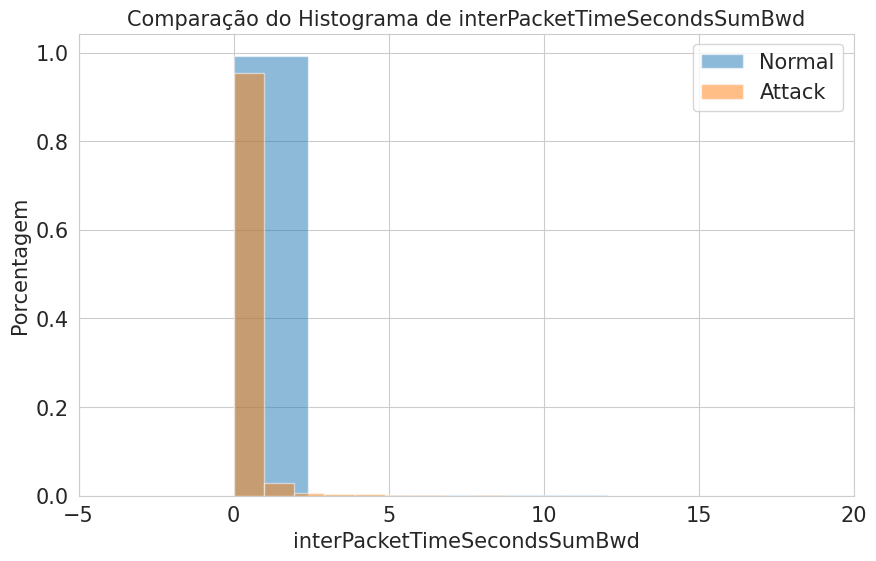

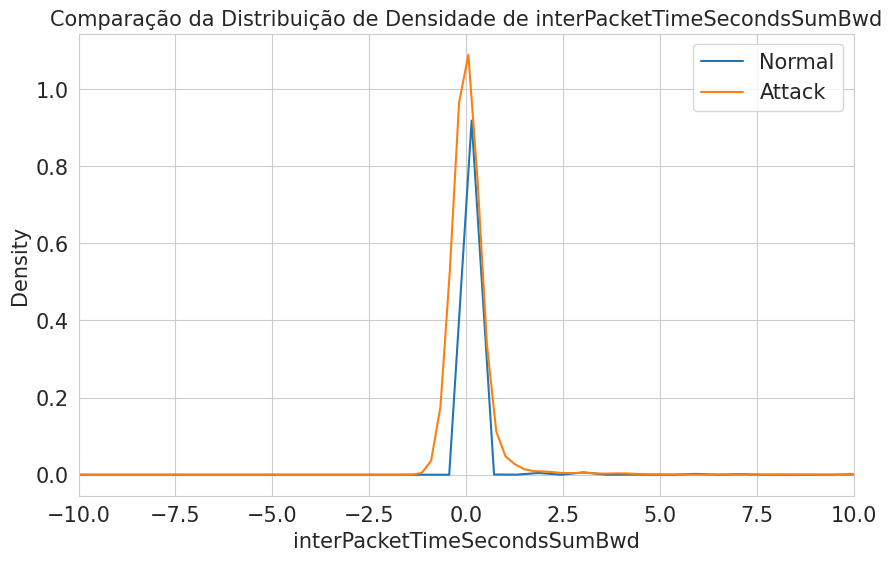

Análise Descritiva para interPacketTimeSecondsSumFwd:
Normal:
count    1.687604e+06
mean     1.876317e-01
std      8.355176e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.616000e+03
Name: interPacketTimeSecondsSumFwd, dtype: float64

Attack:
count    4937.000000
mean        0.118898
std         1.897773
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       119.000000
Name: interPacketTimeSecondsSumFwd, dtype: float64


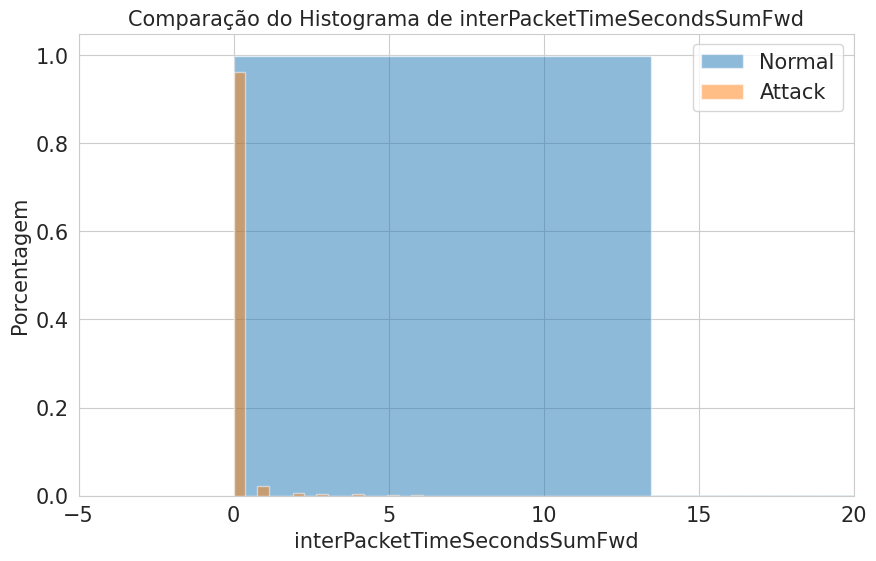

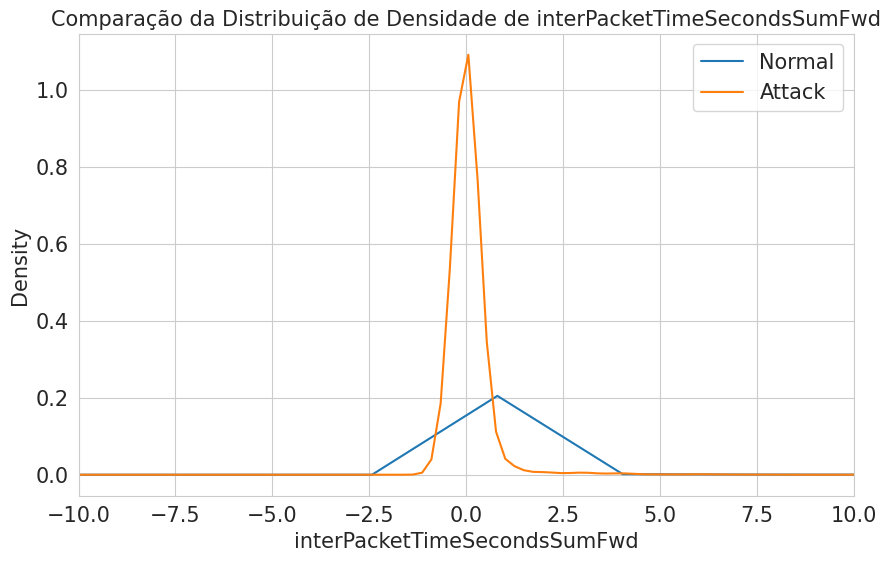

In [54]:
compare_feature_distribution(df_n, df_a, ['interPacketTimeSecondsSumBwd', 'interPacketTimeSecondsSumFwd'], percentage=True, xlim_hist=(-5, 20), xlim_density=(-10, 10), use_fd_rule=True)

Análise Descritiva para interPacketTimeMillisecondsMax:
Normal:
count    1.687604e+06
mean     1.922569e+02
std      3.256512e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      5.000000e+00
max      2.963270e+05
Name: interPacketTimeMillisecondsMax, dtype: float64

Attack:
count     4937.000000
mean       192.674094
std        530.611666
min          0.000000
25%          0.000000
50%         62.000000
75%        236.000000
max      18875.000000
Name: interPacketTimeMillisecondsMax, dtype: float64


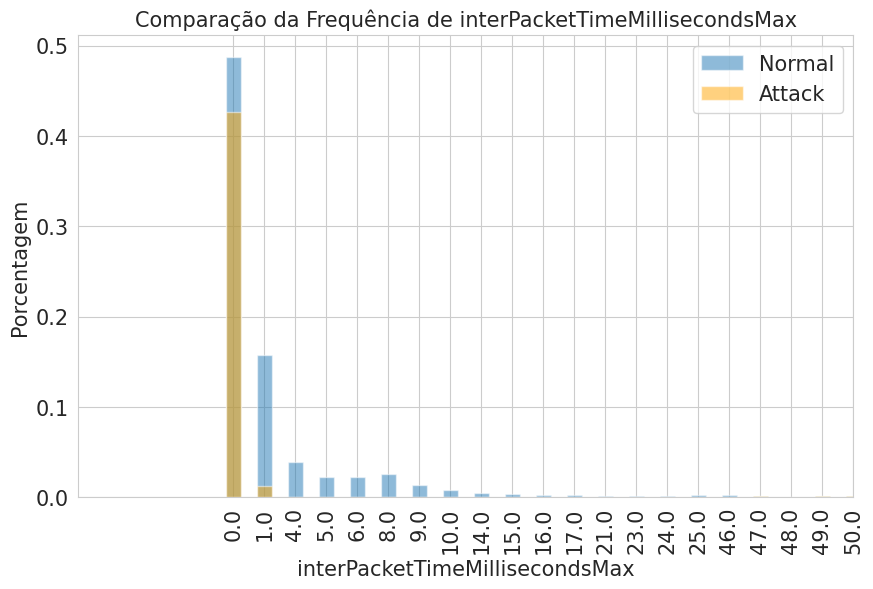

Análise Descritiva para interPacketTimeSecondsSumFwd:
Normal:
count    1.687604e+06
mean     1.876317e-01
std      8.355176e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.616000e+03
Name: interPacketTimeSecondsSumFwd, dtype: float64

Attack:
count    4937.000000
mean        0.118898
std         1.897773
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       119.000000
Name: interPacketTimeSecondsSumFwd, dtype: float64


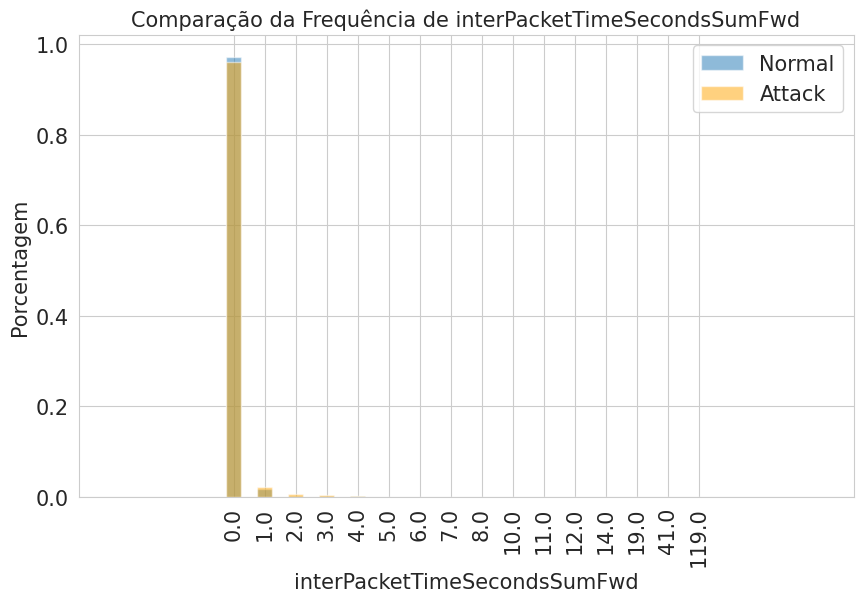

In [55]:
compare_feature_distribution2(df_n, df_a, ['interPacketTimeMillisecondsMax', 'interPacketTimeSecondsSumFwd'], percentage=True, xlim_hist=(-5, 20), xlim_density=(-10, 10))